# Replication File for the Term Paper
## Maksim Mitskevich

In [1]:
!pip install pingouin
!pip install linearmodels
!pip install pysummaries
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
import re
import statsmodels.formula.api as statf
from linearmodels import RandomEffects
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pysummaries import get_table_summary, get_sample_data
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_breusch_godfrey
from statsmodels.stats.anova import anova_lm

## Data Preprocessing

In [2]:
#Written fully by ChatGPT
def check_heteroskedasticity_autocorrelation(ols_model, lags=1):
    """
    Run standard tests for heteroskedasticity and autocorrelation.

    Parameters:
    -----------
    ols_model : statsmodels.regression.linear_model.RegressionResultsWrapper
        A fitted OLS model (result of sm.OLS(...).fit()).
    lags : int
        Number of lags for Breusch-Godfrey autocorrelation test.

    Returns:
    --------
    dict : Dictionary with test names and their results (test statistic and p-value).
    """

    results = {}

    # --- Heteroskedasticity Tests ---
    bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
    results['Breusch-Pagan'] = dict(zip(['LM stat', 'LM p-value', 'F stat', 'F p-value'], bp_test))

    # --- Autocorrelation Test ---
    bg_test = acorr_breusch_godfrey(ols_model, nlags=lags)
    results['Breusch-Godfrey'] = dict(zip(['LM stat', 'LM p-value', 'F stat', 'F p-value'], bg_test))

    return results
from __future__ import annotations
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

##############################################################################
# SUMMARY-COL FOR statsmodels MixedLMResults  ── REVISED, NO STRING BUG
##############################################################################
import numpy as np
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col


class _MixedLMPatched:
    """
    Minimal adapter so that summary_col() can digest a statsmodels MixedLMResults
    object.  It exposes: params, bse, tvalues, pvalues, conf_int(), nobs,
    rsquared (as NaN), and model.exog_names / model.endog_names.
    """
    def __init__(self, res, *, fe_only: bool = True):
        self._orig = res  # keep a handle to the original result

        # ▸ 1. choose which parameters to display
        if fe_only:
            self.params  = res.fe_params.copy()
            self.bse     = res.bse_fe.copy()
            self.pvalues = res.pvalues.loc[self.params.index].copy()
        else:
            self.params  = res.params.copy()
            self.bse     = res.bse.copy()    # attribute, not method
            self.pvalues = res.pvalues.copy()

        self.tvalues = self.params / self.bse

        # ▸ 2. items summary_col expects but MixedLM lacks
        self.nobs     = res.nobs
        self.rsquared = np.nan               # numeric placeholder, not a string

        # fake a tiny .model with exog_names / endog_names
        self.model = type(
            "DummyModel", (), {
                "exog_names": list(self.params.index),
                "endog_names": getattr(res.model, "endog_names", "y")
            }
        )()

    # summary_col calls .conf_int()
    def conf_int(self, alpha: float = 0.05):
        z = norm.ppf(1 - alpha / 2.0)
        lower = self.params - z * self.bse
        upper = self.params + z * self.bse
        return np.column_stack([lower, upper])


def summary_col_mixedlm(results, *, model_names=None,
                        fe_only=True, stars=True,
                        float_format="%.4f"):
    """
    Combine already-fitted MixedLMResults into one summary_col table.

    Parameters
    ----------
    results      : list[statsmodels.regression.mixed_linear_model.MixedLMResults]
    model_names  : list[str] | None
    fe_only      : bool  – show only fixed effects (default True)
    stars        : bool
    float_format : str
    """
    patched = [_MixedLMPatched(r, fe_only=fe_only) for r in results]

    info_dict = {
        "N": lambda x: f"{int(x.nobs)}"
        # R² intentionally omitted (not defined for MixedLM)
    }

    return summary_col(
        patched,
        model_names=model_names,
        stars=stars,
        info_dict=info_dict,
        float_format=float_format
    )

In [3]:
#Written fully by ChatGPT
def summary_col_random_effects(re_results, model_names=None, stars=True):
    """
    Build a summary_col table from linearmodels.panel RandomEffectsResults.

    Parameters
    ----------
    re_results  : list[RandomEffectsResults]
        The models you have already fitted (e.g. res = RandomEffects(...).fit()).
    model_names : list[str] | None
        Column headings in the output table.
    stars       : bool
        Whether to add significance stars.

    Returns
    -------
    statsmodels.iolib.summary2.Summary
    """
    for res in re_results:
        # ---- Patch attributes that statsmodels expects --------------------
        # 1. Standard errors & t-stats
        res.bse     = res.std_errors
        res.tvalues = res.tstats

        # 2. exog_names (summary_col calls r.model.exog_names)
        if not hasattr(res.model, "exog_names"):
            res.model.exog_names = list(res.params.index)

        # (Optional, but tidy) add endog name if missing
        if not hasattr(res.model, "endog_names"):
            res.model.endog_names = (
                res.model.dependent.vars[0] if hasattr(res.model, "dependent")
                else "dep"
            )

    info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'}

    return summary_col(
        re_results,
        stars=stars,
        model_names=model_names,
        regressor_order = keep_vars,
        drop_omitted = True,
        info_dict=info_dict,
        float_format="%.4f"
    )

In [4]:
sns.set_theme(style = 'darkgrid', context = 'paper')

In [5]:
#Written intially by ChatGPT. Assessed by the author.
data = pd.read_csv('https://raw.githubusercontent.com/mitskm/Thesis.-3rd-Year/refs/heads/main/master_table.csv', sep = ';')
pattern = (
    r"V(?P<Var>\d+)B(?P<Bill_1>\d+)T(?P<T_1>\d+),\s*"
    r"V(?P<Var_2>\d+)B(?P<Bill_2>\d+)T(?P<T_2>\d+),\s*"
    r"V(?P<Var_3>\d+)B(?P<Bill_3>\d+)T(?P<T_3>\d+)"
)
regex_df = data["RANDOM"].str.extract(pattern)

regex_df["Var"] = regex_df["Var"].fillna(regex_df["Var_2"]).fillna(regex_df["Var_3"])
regex_df = regex_df.drop(columns=["Var_2", "Var_3"])

for c in ["Var", "Bill_1", "T_1", "Bill_2", "T_2", "Bill_3", "T_3"]:
    regex_df[c] = regex_df[c].astype(int)

data = pd.concat([data, regex_df], axis=1)
data = data.drop(['RANDOM'], axis = 1)
data

,ID,Q1,Q3a,Q5a,Q5b,Q5c,Q5d,Q5e,Q5f,Q5g,...,RELIMP,RELQUANT,CONTROL,Var,Bill_1,T_1,Bill_2,T_2,Bill_3,T_3
0,94,1,3,3,4,4,4,4,4,4,...,4,7,True,5,3,0,1,1,2,1
1,95,1,3,3,4,4,3,4,4,4,...,2,7,True,6,3,0,2,1,1,2
2,96,1,3,5,5,5,5,5,5,5,...,2,5,True,1,1,2,2,1,3,1
3,97,1,3,5,5,5,5,5,5,5,...,3,6,True,2,1,1,3,0,2,1
4,98,1,3,4,4,3,2,1,3,4,...,2,5,True,3,2,2,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,864,1,3,5,5,5,5,5,5,5,...,2,4,True,1,1,1,2,0,3,0
519,865,1,3,3,3,3,3,3,3,3,...,3,6,True,2,1,2,3,0,2,2
520,868,1,3,2,2,2,2,2,3,2,...,3,7,True,5,3,0,1,1,2,2
521,869,1,3,3,5,5,4,5,5,5,...,3,4,True,6,3,1,2,0,1,0


In [6]:
#Written intially by ChatGPT. Assessed by the author.
variant_to_qcols = {
    1: {
        1: ["Q17",  "Q18",  "Q19",  "Q20a", "Q20b"],  # Variant 1 → Bill 1
        2: ["Q21",  "Q22",  "Q23",  "Q24a", "Q24b"],  # Variant 1 → Bill 2
        3: ["Q25",  "Q26",  "Q27",  "Q28a", "Q28b"],  # Variant 1 → Bill 3
    },
    2: {
        1: ["Q29",  "Q30",  "Q31",  "Q32a", "Q32b"],  # Variant 2 → Bill 1
        2: ["Q33",  "Q34",  "Q35",  "Q36a", "Q36b"],  # Variant 2 → Bill 2
        3: ["Q37",  "Q38",  "Q39",  "Q40a", "Q40b"],  # Variant 2 → Bill 3
    },
    3: {
        1: ["Q41",  "Q42",  "Q43",  "Q44a", "Q44b"],  # Variant 3 → Bill 1
        2: ["Q45",  "Q46",  "Q47",  "Q48a", "Q48b"],  # Variant 3 → Bill 2
        3: ["Q49",  "Q50",  "Q51",  "Q52a", "Q52b"],  # Variant 3 → Bill 3
    },
    4: {
        1: ["Q53",  "Q54",  "Q55",  "Q56a", "Q56b"],  # Variant 4 → Bill 1
        2: ["Q57",  "Q58",  "Q59",  "Q60a", "Q60b"],  # Variant 4 → Bill 2
        3: ["Q61",  "Q62",  "Q63",  "Q64a", "Q64b"],  # Variant 4 → Bill 3
    },
    5: {
        1: ["Q65",  "Q66",  "Q67",  "Q68a", "Q68b"],  # Variant 5 → Bill 1
        2: ["Q69",  "Q70",  "Q71",  "Q72a", "Q72b"],  # Variant 5 → Bill 2
        3: ["Q73",  "Q74",  "Q75",  "Q76a", "Q76b"],  # Variant 5 → Bill 3
    },
    6: {
        1: ["Q77",  "Q78",  "Q79",  "Q80a", "Q80b"],  # Variant 6 → Bill 1
        2: ["Q81",  "Q82",  "Q83",  "Q84a", "Q84b"],  # Variant 6 → Bill 2
        3: ["Q85",  "Q86",  "Q87",  "Q88a", "Q88b"],  # Variant 6 → Bill 3
    },
}
df = data
for bill_index in [1, 2, 3]:
    for q_index in [1, 2, 3, 4, 5]:

        new_col = f"Bill_{bill_index}_Q_{q_index}"
        df[new_col] = pd.NA
        for var_value, bill_map in variant_to_qcols.items():
            orig_qcol = bill_map[bill_index][q_index - 1]
            mask = df["Var"] == var_value
            df.loc[mask, new_col] = df.loc[mask, orig_qcol]

all_qcols = []
for bill_map in variant_to_qcols.values():
    for bill_list in bill_map.values():
        all_qcols.extend(bill_list)
data = df

In [7]:
#Written intially by ChatGPT. Assessed by the author.
bill1_qcols = [f"Bill_1_Q_{i}" for i in range(1, 6)]  # ["Bill_1_Q_1", ..., "Bill_1_Q_5"]

df1 = df.melt(
    id_vars=[
        "Var", "Bill_1", "T_1",
        "ID", "Q1", "Q3a",
        "Q5a", "Q5b", "Q5c", "Q5d", "Q5e", "Q5f", "Q5g", "Q5h", "Q5i", "Q5j",
        "Q5k", "Q5l", "Q5m", "Q5n", "Q5o", "Q5p", "Q5q", "Q5r",
        "Q6a", "Q6b", "Q6c", "Q6d", "Q6e", "Q6f", "Q6g", "Q6h", "Q6i", "Q6j",
        "Q6k", "Q6l", "Q6m", "Q6n", "Q6o", "Q6p", "Q6q", "Q6r",
        "Q7a", "Q7b", "Q7c", "Q7d", "Q7e", "Q7f",
        "Q8a", "Q8b", "Q8c", "Q8d", "Q8e", "Q8f",
        "Q9a", "Q9b", "Q9c", "Q9d",
        "Q10a", "Q10b", "Q10c",
        "Q11a", "Q11b", "Q11c", "Q11d", "Q11e", "Q11f", "Q11g",
        "Q12a", "Q12b", "Q12c", "Q12d",
        "Q13a", "Q13b", "Q13c", "Q13d", "Q13e", "Q13f", "Q13g", "Q13h", "Q13i", "Q13j",
        "Q14a", "Q14b", "Q14c",
        "Q15a",
        "GENDER", "AGE", "COUNTRY", "EDUC", "ECSTAT", "PLACE", "REGION", "POLINT", "RELIMP", "RELQUANT", "CONTROL"
    ],
    value_vars=bill1_qcols,
    var_name="question_col",
    value_name="answer"
)
df1["Position"] = 1
df1["question_index"] = (
    df1["question_col"]
      .str.rsplit("_", n=1)
      .str[-1]
      .astype(int)
)
df1 = df1.drop(columns=["question_col"]) \
         .rename(columns={"Bill_1": "Bill", "T_1": "Treatment"})


bill2_qcols = [f"Bill_2_Q_{i}" for i in range(1, 6)]

df2 = df.melt(
    id_vars=[
        "Var", "Bill_2", "T_2",
        "ID", "Q1", "Q3a",
        "Q5a", "Q5b", "Q5c", "Q5d", "Q5e", "Q5f", "Q5g", "Q5h", "Q5i", "Q5j",
        "Q5k", "Q5l", "Q5m", "Q5n", "Q5o", "Q5p", "Q5q", "Q5r",
        "Q6a", "Q6b", "Q6c", "Q6d", "Q6e", "Q6f", "Q6g", "Q6h", "Q6i", "Q6j",
        "Q6k", "Q6l", "Q6m", "Q6n", "Q6o", "Q6p", "Q6q", "Q6r",
        "Q7a", "Q7b", "Q7c", "Q7d", "Q7e", "Q7f",
        "Q8a", "Q8b", "Q8c", "Q8d", "Q8e", "Q8f",
        "Q9a", "Q9b", "Q9c", "Q9d",
        "Q10a", "Q10b", "Q10c",
        "Q11a", "Q11b", "Q11c", "Q11d", "Q11e", "Q11f", "Q11g",
        "Q12a", "Q12b", "Q12c", "Q12d",
        "Q13a", "Q13b", "Q13c", "Q13d", "Q13e", "Q13f", "Q13g", "Q13h", "Q13i", "Q13j",
        "Q14a", "Q14b", "Q14c",
        "Q15a",
        "GENDER", "AGE", "COUNTRY", "EDUC", "ECSTAT", "PLACE", "REGION", "POLINT", "RELIMP", "RELQUANT", "CONTROL"
    ],
    value_vars=bill2_qcols,
    var_name="question_col",
    value_name="answer"
)
df2["Position"] = 2
df2["question_index"] = (
    df2["question_col"]
      .str.rsplit("_", n=1)
      .str[-1]
      .astype(int)
)
df2 = df2.drop(columns=["question_col"]) \
         .rename(columns={"Bill_2": "Bill", "T_2": "Treatment"})


bill3_qcols = [f"Bill_3_Q_{i}" for i in range(1, 6)]

df3 = df.melt(
    id_vars=[
        "Var", "Bill_3", "T_3",
        "ID", "Q1", "Q3a",
        "Q5a", "Q5b", "Q5c", "Q5d", "Q5e", "Q5f", "Q5g", "Q5h", "Q5i", "Q5j",
        "Q5k", "Q5l", "Q5m", "Q5n", "Q5o", "Q5p", "Q5q", "Q5r",
        "Q6a", "Q6b", "Q6c", "Q6d", "Q6e", "Q6f", "Q6g", "Q6h", "Q6i", "Q6j",
        "Q6k", "Q6l", "Q6m", "Q6n", "Q6o", "Q6p", "Q6q", "Q6r",
        "Q7a", "Q7b", "Q7c", "Q7d", "Q7e", "Q7f",
        "Q8a", "Q8b", "Q8c", "Q8d", "Q8e", "Q8f",
        "Q9a", "Q9b", "Q9c", "Q9d",
        "Q10a", "Q10b", "Q10c",
        "Q11a", "Q11b", "Q11c", "Q11d", "Q11e", "Q11f", "Q11g",
        "Q12a", "Q12b", "Q12c", "Q12d",
        "Q13a", "Q13b", "Q13c", "Q13d", "Q13e", "Q13f", "Q13g", "Q13h", "Q13i", "Q13j",
        "Q14a", "Q14b", "Q14c",
        "Q15a",
        "GENDER", "AGE", "COUNTRY", "EDUC", "ECSTAT", "PLACE", "REGION", "POLINT", "RELIMP", "RELQUANT", "CONTROL"
    ],
    value_vars=bill3_qcols,
    var_name="question_col",
    value_name="answer"
)
df3["Position"] = 3
df3["question_index"] = (
    df3["question_col"]
      .str.rsplit("_", n=1)
      .str[-1]
      .astype(int)
)
df3 = df3.drop(columns=["question_col"]) \
         .rename(columns={"Bill_3": "Bill", "T_3": "Treatment"})


long_melted = pd.concat([df1, df2, df3], axis=0, ignore_index=True)


final_df = (
    long_melted
    .pivot_table(
        index=[
            "Var", "ID", "Q1", "Q3a",
            "Q5a", "Q5b", "Q5c", "Q5d", "Q5e", "Q5f", "Q5g", "Q5h", "Q5i", "Q5j",
            "Q5k", "Q5l", "Q5m", "Q5n", "Q5o", "Q5p", "Q5q", "Q5r",
            "Q6a", "Q6b", "Q6c", "Q6d", "Q6e", "Q6f", "Q6g", "Q6h", "Q6i", "Q6j",
            "Q6k", "Q6l", "Q6m", "Q6n", "Q6o", "Q6p", "Q6q", "Q6r",
            "Q7a", "Q7b", "Q7c", "Q7d", "Q7e", "Q7f",
            "Q8a", "Q8b", "Q8c", "Q8d", "Q8e", "Q8f",
            "Q9a", "Q9b", "Q9c", "Q9d",
            "Q10a", "Q10b", "Q10c",
            "Q11a", "Q11b", "Q11c", "Q11d", "Q11e", "Q11f", "Q11g",
            "Q12a", "Q12b", "Q12c", "Q12d",
            "Q13a", "Q13b", "Q13c", "Q13d", "Q13e", "Q13f", "Q13g", "Q13h", "Q13i", "Q13j",
            "Q14a", "Q14b", "Q14c",
            "Q15a",
            "GENDER", "AGE", "COUNTRY", "EDUC", "ECSTAT", "PLACE", "REGION", "POLINT", "RELIMP", "RELQUANT", "CONTROL",
            "Bill", "Treatment", "Position"
        ],
        columns="question_index",
        values="answer",
        aggfunc="first"
    )
    .reset_index()
)
final_df.columns = [
    "Var", "ID", "Q1", "Q3a",
    "Q5a", "Q5b", "Q5c", "Q5d", "Q5e", "Q5f", "Q5g", "Q5h", "Q5i", "Q5j",
    "Q5k", "Q5l", "Q5m", "Q5n", "Q5o", "Q5p", "Q5q", "Q5r",
    "Q6a", "Q6b", "Q6c", "Q6d", "Q6e", "Q6f", "Q6g", "Q6h", "Q6i", "Q6j",
    "Q6k", "Q6l", "Q6m", "Q6n", "Q6o", "Q6p", "Q6q", "Q6r",
    "Q7a", "Q7b", "Q7c", "Q7d", "Q7e", "Q7f",
    "Q8a", "Q8b", "Q8c", "Q8d", "Q8e", "Q8f",
    "Q9a", "Q9b", "Q9c", "Q9d",
    "Q10a", "Q10b", "Q10c",
    "Q11a", "Q11b", "Q11c", "Q11d", "Q11e", "Q11f", "Q11g",
    "Q12a", "Q12b", "Q12c", "Q12d",
    "Q13a", "Q13b", "Q13c", "Q13d", "Q13e", "Q13f", "Q13g", "Q13h", "Q13i", "Q13j",
    "Q14a", "Q14b", "Q14c",
    "Q15a",
    "GENDER", "AGE", "COUNTRY", "EDUC", "ECSTAT", "PLACE", "REGION", "POLINT", "RELIMP", "RELQUANT", "CONTROL",
    "Bill", "Treatment", "Position",
    "bill_Q1", "bill_Q2", "bill_Q3", "bill_Q4", "bill_Q5"
]

df = final_df.sort_values(by=["Var", "Position"]).reset_index(drop=True)

In [8]:
#Written intially by ChatGPT. Assessed by the author.
df = df.sort_values(by=["ID", "Position"])


df["is_t1"] = (df["Treatment"] == 1).astype(int)
df["is_t2"] = (df["Treatment"] == 2).astype(int)

df["shifted_t1"] = df.groupby("ID")["is_t1"].shift(fill_value=0)

df["shifted_t2"] = df.groupby("ID")["is_t2"].shift(fill_value=0)


df["prior_t1_count"] = df.groupby("ID")["shifted_t1"].cumsum()

df["prior_t2_count"] = df.groupby("ID")["shifted_t2"].cumsum()

def compute_tseen(row):
    if row["Treatment"] == 1 and row["prior_t1_count"] > 0:
        return 1
    elif row["Treatment"] == 2 and row["prior_t2_count"] > 0:
        return 1
    else:
        return 0

df["Tseen"] = df.apply(compute_tseen, axis=1)

df = df.drop(columns=["is_t1", "is_t2", "shifted_t1", "shifted_t2",
                      "prior_t1_count", "prior_t2_count"])
df = df.drop('CONTROL', axis = 1)
df = df.drop([])

In [9]:
#Written intially by ChatGPT. Assessed by the author.
bill_response_cols = ['bill_Q1', 'bill_Q2', 'bill_Q3', 'bill_Q4', 'bill_Q5']


long_df = df.melt(
    id_vars=['ID', 'Bill', 'Treatment', 'Position', 'Tseen'],
    value_vars=bill_response_cols,
    var_name='Question',
    value_name='Response'
)

long_df['Question'] = long_df['Question'].str.replace('bill_Q', 'Q')



static_cols = np.array(df.columns)[:94]
static_df = df[static_cols].drop_duplicates('ID')
long_df = long_df.merge(static_df, on='ID', how='left')


long_df

,ID,Bill,Treatment,Position,Tseen,Question,Response,Var,Q1,Q3a,...,GENDER,AGE,COUNTRY,EDUC,ECSTAT,PLACE,REGION,POLINT,RELIMP,RELQUANT
0,94,3,0,1,0,Q1,50,5,1,3,...,2,22,1,3,2,4,80,1,4,7
1,94,1,1,2,0,Q1,50,5,1,3,...,2,22,1,3,2,4,80,1,4,7
2,94,2,1,3,1,Q1,73,5,1,3,...,2,22,1,3,2,4,80,1,4,7
3,95,3,0,1,0,Q1,100,6,1,3,...,2,41,1,2,3,4,34,4,2,7
4,95,2,1,2,0,Q1,100,6,1,3,...,2,41,1,2,3,4,34,4,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,869,2,0,2,0,Q5,3,6,1,3,...,2,31,1,4,4,3,25,4,3,4
7841,869,1,0,3,0,Q5,7,6,1,3,...,2,31,1,4,4,3,25,4,3,4
7842,870,1,1,1,0,Q5,7,1,1,3,...,2,30,1,4,4,1,67,3,3,7
7843,870,2,2,2,0,Q5,2,1,1,3,...,2,30,1,4,4,1,67,3,3,7


In [10]:
long_df.to_csv('Master_long_df.csv') #Final dataframe for this research

In [11]:
df_q9 = long_df.drop_duplicates(subset='ID')[['Q9a', 'Q9b', 'Q9c',
       'Q9d']].dropna()
df_q10 = long_df.drop_duplicates(subset='ID')[['Q10a', 'Q10b', 'Q10c']].dropna()
df_q11 = long_df.drop_duplicates(subset='ID')[['Q11a', 'Q11b', 'Q11c', 'Q11d',
       'Q11e', 'Q11f']].dropna()

In [12]:
#
scaler1 = StandardScaler()
X_1 = scaler1.fit_transform(df_q9)

pca1 = PCA()
components1 = pca1.fit_transform(X_1)
print(pca1.explained_variance_ratio_)


scaler2 = StandardScaler()
X_2 = scaler2.fit_transform(df_q10)

pca2 = PCA()
components2 = pca2.fit_transform(X_2)
print(pca2.explained_variance_ratio_)


scaler3 = StandardScaler()
X_3 = scaler3.fit_transform(df_q11)

pca3 = PCA()
components3 = pca3.fit_transform(X_3)
print(pca3.explained_variance_ratio_)

[0.83623811 0.07083962 0.05477226 0.03815001]
[0.85193414 0.10023565 0.04783021]
[0.70833494 0.11971706 0.06268514 0.04515667 0.03511148 0.02899471]


In [13]:
print(round(pg.cronbach_alpha(df_q9)[0],2)) # for Q9a-Q9d
print(round(pg.cronbach_alpha(df_q10)[0],2)) #for Q10a-Q10c
print(round(pg.cronbach_alpha(df_q11)[0],2)) #for Q11a-11d

0.93
0.91
0.92


In [14]:
long_df['PolCompetence'] = long_df[['Q9a', 'Q9b', 'Q9c',
       'Q9d']].mean(axis = 1) - 1 #Creating a variable for Political Competence
long_df['PolTrust'] = long_df[['Q10a', 'Q10b', 'Q10c']].mean(axis = 1) - 1 #Creating a variable for Political Trust
long_df['PolInf'] = long_df[['Q11a', 'Q11b', 'Q11c', 'Q11d',
       'Q11e', 'Q11f']].mean(axis = 1) - 1 #creating a variable for Political Influence

In [15]:
# We drop all variables not required for this study
to_drop = ['Q1', 'Q3a', 'Q5a', 'Q5b', 'Q5c',
       'Q5d', 'Q5e', 'Q5f', 'Q5g', 'Q5h', 'Q5i', 'Q5j', 'Q5k', 'Q5l',
       'Q5m', 'Q5n', 'Q5o', 'Q5p', 'Q5q', 'Q5r', 'Q6a', 'Q6b', 'Q6c',
       'Q6d', 'Q6e', 'Q6f', 'Q6g', 'Q6h', 'Q6i', 'Q6j', 'Q6k', 'Q6l',
       'Q6m', 'Q6n', 'Q6o', 'Q6p', 'Q6q', 'Q6r', 'Q7a', 'Q7b', 'Q7c',
       'Q7d', 'Q7e', 'Q7f', 'Q8a', 'Q8b', 'Q8c', 'Q8d', 'Q8e', 'Q8f',
       'Q9a', 'Q9b', 'Q9c', 'Q9d', 'Q10a', 'Q10b', 'Q10c', 'Q11a', 'Q11b',
       'Q11c', 'Q11d', 'Q11e', 'Q11f', 'Q11g', 'Q12a', 'Q12b', 'Q12c',
       'Q12d', 'Q13a', 'Q13b', 'Q13c', 'Q13d', 'Q13e', 'Q13f', 'Q13g',
       'Q13h', 'Q13i', 'Q13j', 'Q14a', 'Q14b', 'Q14c',
           'Q15a', 'COUNTRY','EDUC', 'ECSTAT', 'PLACE', 'POLINT', 'RELIMP', 'RELQUANT', 'GENDER', 'AGE', 'REGION']
#extract 1 from all control variables for the interpretability of intercept
long_df['GovStrongLeader'] = long_df['Q14a'] - 1
long_df['GovExperts'] = long_df['Q14b'] - 1
long_df['GovDem'] = long_df['Q14c'] - 1
long_df['RightsVersusGov'] = long_df['Q15a'] - 1
long_df['Educ'] = long_df['EDUC'] - 1
long_df['Ecstat'] = long_df['ECSTAT'] - 1
long_df['Place'] = long_df['PLACE'] - 1
long_df['PolInt'] = long_df['POLINT'] - 1
long_df['RelImp'] = long_df['RELIMP'] - 1
long_df['RelQuant'] = long_df['RELQUANT'] - 1
long_df['GenderFemale'] = long_df['GENDER'] - 1
long_df['Age'] = long_df['AGE']
long_df = long_df.drop(to_drop, axis = 1)
long_df['Response'] = long_df['Response'].astype(int)

In [16]:
#Create auxilary dataframes
#–––––––––––––––––––––––––––––––––––––
long_df_Q1 = long_df[long_df['Question'] == 'Q1']
long_df_Q2 = long_df[long_df['Question']== 'Q2']
long_df_Q3 = long_df[long_df['Question']== 'Q3']
long_df_Q4 = long_df[long_df['Question']== 'Q4']
long_df_Q5 = long_df[long_df['Question']== 'Q5']
#–––––––––––––––––––––––––––––––––––––
long_df_bill_1  = long_df[long_df['Bill'] == 1]
long_df_bill_1_Q1 = long_df[(long_df['Bill'] == 1) & (long_df['Question'] == 'Q1')]
long_df_bill_1_Q2 = long_df[(long_df['Bill'] == 1) & (long_df['Question'] == 'Q2')]
long_df_bill_1_Q3 = long_df[(long_df['Bill'] == 1) & (long_df['Question'] == 'Q3')]
long_df_bill_1_Q4 = long_df[(long_df['Bill'] == 1) & (long_df['Question'] == 'Q4')]
long_df_bill_1_Q5 = long_df[(long_df['Bill'] == 1) & (long_df['Question'] == 'Q5')]
#–––––––––––––––––––––––––––––––––––––
long_df_bill_2  = long_df[long_df['Bill'] == 2]
long_df_bill_2_Q1 = long_df[(long_df['Bill'] == 2) & (long_df['Question'] == 'Q1')]
long_df_bill_2_Q2 = long_df[(long_df['Bill'] == 2) & (long_df['Question'] == 'Q2')]
long_df_bill_2_Q3 = long_df[(long_df['Bill'] == 2) & (long_df['Question'] == 'Q3')]
long_df_bill_2_Q4 = long_df[(long_df['Bill'] == 2) & (long_df['Question'] == 'Q4')]
long_df_bill_2_Q5 = long_df[(long_df['Bill'] == 2) & (long_df['Question'] == 'Q5')]
#–––––––––––––––––––––––––––––––––––––
long_df_bill_3  = long_df[long_df['Bill'] == 3]
long_df_bill_3_Q1 =long_df[(long_df['Bill'] == 3) & (long_df['Question'] == 'Q1')]
long_df_bill_3_Q2 =long_df[(long_df['Bill'] == 3) & (long_df['Question'] == 'Q2')]
long_df_bill_3_Q3 =long_df[(long_df['Bill'] == 3) & (long_df['Question'] == 'Q3')]
long_df_bill_3_Q4 =long_df[(long_df['Bill'] == 3) & (long_df['Question'] == 'Q4')]
long_df_bill_3_Q5 =long_df[(long_df['Bill'] == 3) & (long_df['Question'] == 'Q5')]
#–––––––––––––––––––––––––––––––––––––
long_df_Q1_T1 = long_df_Q1[(long_df_Q1['Treatment'] == 0) | (long_df_Q1['Treatment'] == 1)]
long_df_Q2_T1 = long_df_Q2[(long_df_Q2['Treatment'] == 0) | (long_df_Q2['Treatment'] == 1)]
long_df_Q3_T1 = long_df_Q3[(long_df_Q3['Treatment'] == 0) | (long_df_Q3['Treatment'] == 1)]
long_df_Q4_T1 = long_df_Q4[(long_df_Q4['Treatment'] == 0) | (long_df_Q4['Treatment'] == 1)]
long_df_Q5_T1 = long_df_Q5[(long_df_Q5['Treatment'] == 0) | (long_df_Q5['Treatment'] == 1)]
#–––––––––––––––––––––––––––––––––––––
long_df_Q1_T2 = long_df_Q1[(long_df_Q1['Treatment'] == 0) | (long_df_Q1['Treatment'] == 2)]
long_df_Q2_T2 = long_df_Q2[(long_df_Q2['Treatment'] == 0) | (long_df_Q2['Treatment'] == 2)]
long_df_Q3_T2 = long_df_Q3[(long_df_Q3['Treatment'] == 0) | (long_df_Q3['Treatment'] == 2)]
long_df_Q4_T2 = long_df_Q4[(long_df_Q4['Treatment'] == 0) | (long_df_Q4['Treatment'] == 2)]
long_df_Q5_T2 = long_df_Q5[(long_df_Q5['Treatment'] == 0) | (long_df_Q5['Treatment'] == 2)]
#–––––––––––––––––––––––––––––––––––––
long_df_Q2_T= long_df_Q2[(long_df_Q2['Treatment'] == 1) | (long_df_Q2['Treatment'] == 2)]
#–––––––––––––––––––––––––––––––––––––
group_Q1_T0 = long_df_Q1[long_df_Q1['Treatment'] == 0]['Response']
group_Q1_T1 = long_df_Q1[long_df_Q1['Treatment'] == 1]['Response']
group_Q1_T2 = long_df_Q1[long_df_Q1['Treatment'] == 2]['Response']

group_Q2_T0 = long_df_Q2[long_df_Q2['Treatment'] == 0]['Response']
group_Q2_T1 = long_df_Q2[long_df_Q2['Treatment'] == 1]['Response']
group_Q2_T2 = long_df_Q2[long_df_Q2['Treatment'] == 2]['Response']

group_Q3_T0 = long_df_Q3[long_df_Q3['Treatment'] == 0]['Response']
group_Q3_T1 = long_df_Q3[long_df_Q3['Treatment'] == 1]['Response']
group_Q3_T2 = long_df_Q3[long_df_Q3['Treatment'] == 2]['Response']

group_Q4_T0 = long_df_Q4[long_df_Q4['Treatment'] == 0]['Response']
group_Q4_T1 = long_df_Q4[long_df_Q4['Treatment'] == 1]['Response']
group_Q4_T2 = long_df_Q4[long_df_Q4['Treatment'] == 2]['Response']

group_Q5_T0 = long_df_Q5[long_df_Q5['Treatment'] == 0]['Response']
group_Q5_T1 = long_df_Q5[long_df_Q5['Treatment'] == 1]['Response']
group_Q5_T2 = long_df_Q5[long_df_Q5['Treatment'] == 2]['Response']

## Exploratory Data Analysis

### Control Variables Tables and Randomization Checks

In [17]:
long_df_Q2['Gender'] = long_df_Q2['GenderFemale'].apply(lambda x: 'Female' if x == 1 else 'Male') #Auxilary variable
include_1 = ['Age', 'Gender', 'Educ', 'Ecstat','PolCompetence', 'PolTrust',
             'PolInf', 'GovStrongLeader']
include_2 = ['GovExperts', 'GovDem', 'RightsVersusGov', 'Educ',
             'Ecstat', 'Place', 'PolInt', 'RelImp', 'RelQuant']
summary_table_1 = get_table_summary(long_df_Q2, strata='Treatment', columns_include = include_1,  backend='native')
summary_table_2 = get_table_summary(long_df_Q2, strata='Treatment', columns_include = include_2,  backend='native')
with open('summary_1.html','w') as r:
    r.write(summary_table_1.html)
with open('summary_2.html','w') as r:
    r.write(summary_table_2.html)

<ipython-input-17-43a86347379c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_df_Q2['Gender'] = long_df_Q2['GenderFemale'].apply(lambda x: 'Female' if x == 1 else 'Male') #Auxilary variable


Additional checks for randomization

In [18]:
for item in include_1:
  if item != 'Gender':
    print(item)
    print(pg.pairwise_tests(dv= item, between='Treatment', data=long_df_Q2, padjust='bonf'))

Age
    Contrast  A  B  Paired  Parametric         T          dof alternative  \
0  Treatment  0  1   False        True -0.920104  1013.390575   two-sided   
1  Treatment  0  2   False        True -0.570696   977.843768   two-sided   
2  Treatment  1  2   False        True  0.360317  1091.585261   two-sided   

      p-unc  p-corr p-adjust   BF10    hedges  
0  0.357738     1.0     bonf  0.106 -0.056988  
1  0.568337     1.0     bonf  0.083 -0.036257  
2  0.718680     1.0     bonf  0.072  0.021725  
Educ
    Contrast  A  B  Paired  Parametric         T          dof alternative  \
0  Treatment  0  1   False        True -0.305953   997.550441   two-sided   
1  Treatment  0  2   False        True -0.450512   983.429973   two-sided   
2  Treatment  1  2   False        True -0.164433  1078.266647   two-sided   

      p-unc  p-corr p-adjust   BF10    hedges  
0  0.759704     1.0     bonf  0.073 -0.019027  
1  0.652440     1.0     bonf  0.079 -0.028583  
2  0.869421     1.0     bonf  0.069 -

In [19]:
for item in include_2:
  if item != 'Gender':
    print(item)
    print(pg.pairwise_tests(dv= item, between='Treatment', data=long_df_Q2, padjust='bonf'))

GovExperts
    Contrast  A  B  Paired  Parametric         T          dof alternative  \
0  Treatment  0  1   False        True  1.028984  1022.249490   two-sided   
1  Treatment  0  2   False        True  0.736583   989.141972   two-sided   
2  Treatment  1  2   False        True -0.275960  1085.179315   two-sided   

      p-unc    p-corr p-adjust   BF10    hedges  
0  0.303730  0.911191     bonf  0.117  0.063560  
1  0.461551  1.000000     bonf  0.093  0.046639  
2  0.782632  1.000000     bonf   0.07 -0.016670  
GovDem
    Contrast  A  B  Paired  Parametric         T          dof alternative  \
0  Treatment  0  1   False        True -0.297333  1006.321919   two-sided   
1  Treatment  0  2   False        True  1.702334   984.290873   two-sided   
2  Treatment  1  2   False        True  2.089366  1082.539035   two-sided   

      p-unc    p-corr p-adjust   BF10    hedges  
0  0.766274  1.000000     bonf  0.073 -0.018451  
1  0.089008  0.267025     bonf  0.296  0.107978  
2  0.036908  0

There's a concern over the randomization of the political influence but this variable is included as a covariate in all models.

In [20]:
for item in include_1:
  if item != 'Gender':
    print(item)
    print(pg.welch_anova(dv= item, between='Treatment', data=long_df_Q2))

Age
      Source  ddof1        ddof2         F    p-unc       np2
0  Treatment      2  1030.749026  0.427166  0.65247  0.000553
Educ
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1026.657221  0.104186  0.901067  0.000135
Ecstat
      Source  ddof1        ddof2         F    p-unc       np2
0  Treatment      2  1032.012299  0.637651  0.52874  0.000773
PolCompetence
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1027.017283  0.736297  0.479137  0.000937
PolTrust
      Source  ddof1        ddof2         F    p-unc       np2
0  Treatment      2  1030.479208  2.151088  0.11688  0.002798
PolInf
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1021.169873  4.017164  0.018289  0.005107
GovStrongLeader
      Source  ddof1        ddof2        F     p-unc       np2
0  Treatment      2  1026.952986  1.49649  0.224403  0.001911


In [21]:
for item in include_2:
  if item != 'Gender':
    print(item)
    print(pg.welch_anova(dv= item, between='Treatment', data=long_df_Q2))

GovExperts
      Source  ddof1        ddof2         F     p-unc      np2
0  Treatment      2  1033.316165  0.558564  0.572203  0.00069
GovDem
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1029.025699  2.462814  0.085697  0.003161
RightsVersusGov
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1028.902575  1.089665  0.336717  0.001391
Educ
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1026.657221  0.104186  0.901067  0.000135
Ecstat
      Source  ddof1        ddof2         F    p-unc       np2
0  Treatment      2  1032.012299  0.637651  0.52874  0.000773
Place
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1020.013444  1.086217  0.337881  0.001347
PolInt
      Source  ddof1        ddof2         F     p-unc       np2
0  Treatment      2  1030.689431  0.130812  0.877398  0.000167
RelImp
      Source  ddof1        ddof2         F     p-unc    

In [22]:
contingency_table_Treatment_Gender = pd.crosstab(long_df_Q2['Treatment'], long_df_Q2['Gender']).astype(int)
print('Chi Squared for Independence of Treatments and Gender')
print(np.round(np.array(stats.chi2_contingency(contingency_table_Treatment_Gender)[:2]),4))

Chi Squared for Independence of Treatments and Gender
[0.8737 0.6461]


### Plots for the Exploratory Data Analysis

<ipython-input-23-b5c9ae3bb05d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q1['Response'])


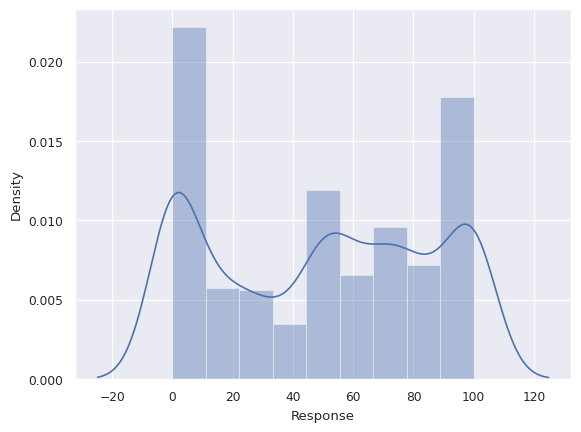

In [23]:
sns.distplot(long_df_Q1['Response'])
plt.savefig('DistPlot_Q1.png', dpi = 300)
plt.show()

<ipython-input-24-73152da53255>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q2['Response'])


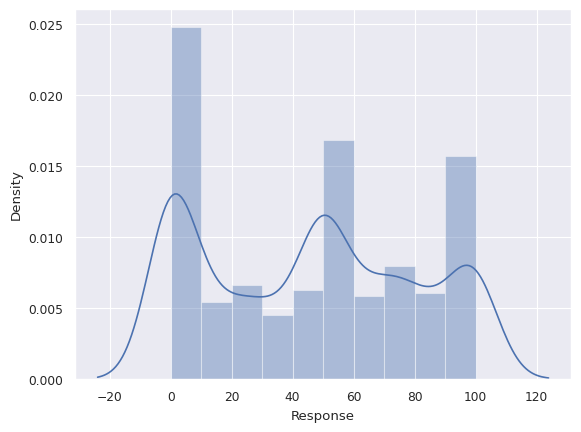

In [24]:
sns.distplot(long_df_Q2['Response'])
plt.savefig('DistPlot_Q2.png', dpi = 300)
plt.show()

<ipython-input-25-64cf843d85ec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q3['Response'])


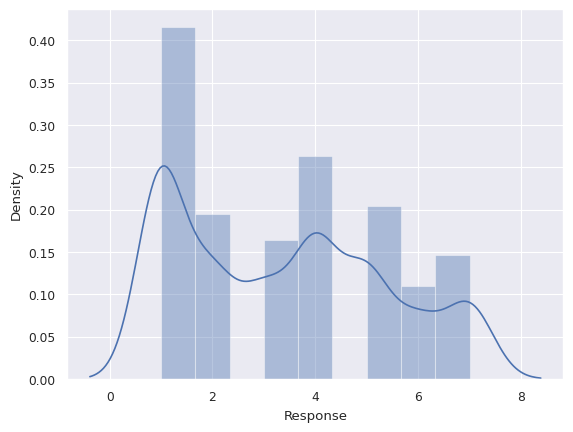

In [25]:
sns.distplot(long_df_Q3['Response'])
plt.savefig('DistPlot_Q3.png', dpi = 300)
plt.show()

<ipython-input-26-23c6dba3c782>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q4['Response'])


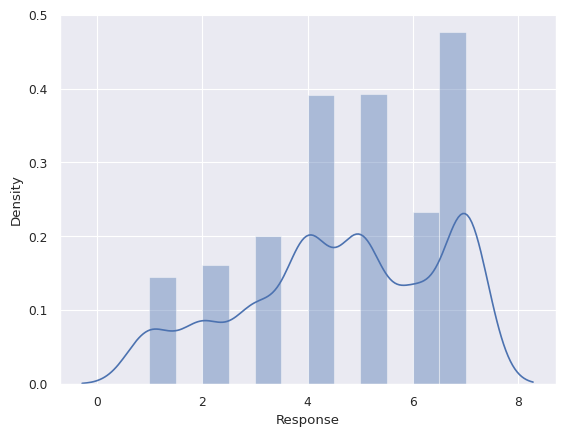

In [26]:
sns.distplot(long_df_Q4['Response'])
plt.savefig('DistPlot_Q4.png', dpi = 300)
plt.show()

<ipython-input-27-4737da519348>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q5['Response'])


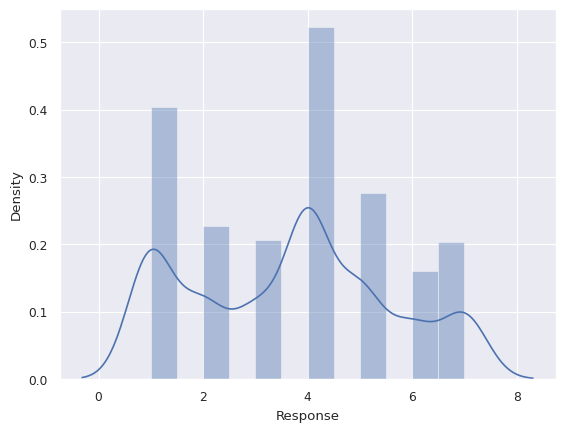

In [27]:
sns.distplot(long_df_Q5['Response'])
plt.savefig('DistPlot_Q5.png', dpi = 300)
plt.show()

<ipython-input-28-c418a9abb53f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_2_Q1['Response'])


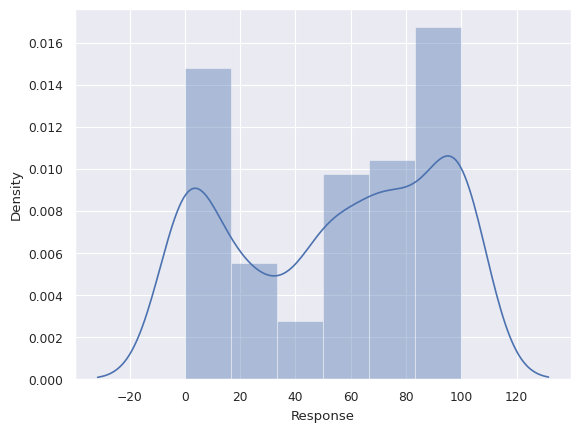

In [28]:
sns.distplot(long_df_bill_2_Q1['Response'])
plt.show()

<ipython-input-29-ac86d69d4ea8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_3_Q1['Response'])


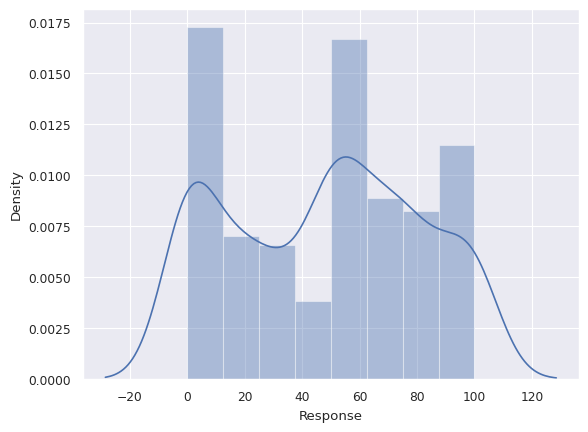

In [29]:
sns.distplot(long_df_bill_3_Q1['Response'])
plt.show()

<ipython-input-30-b236e609f1c5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q2['Response'])


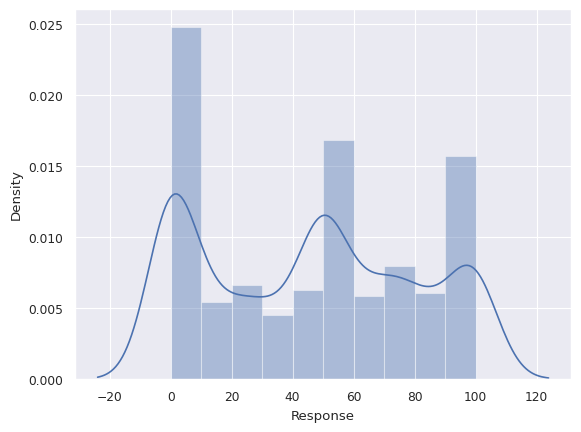

In [30]:
sns.distplot(long_df_Q2['Response'])
plt.show()

<ipython-input-31-24e892fb1a86>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_1_Q2['Response'])


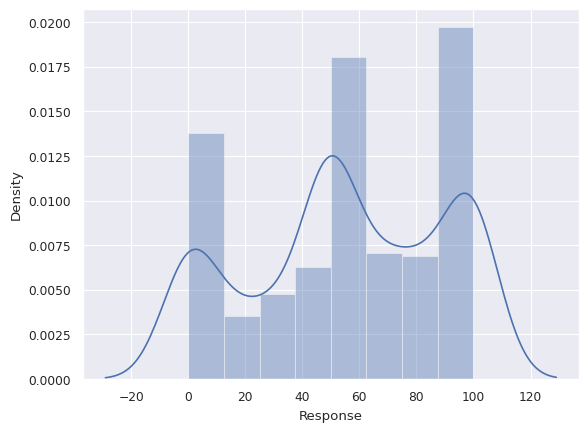

In [31]:
sns.distplot(long_df_bill_1_Q2['Response'])
plt.show()

<ipython-input-32-7d518ab383f6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_2_Q2['Response'])


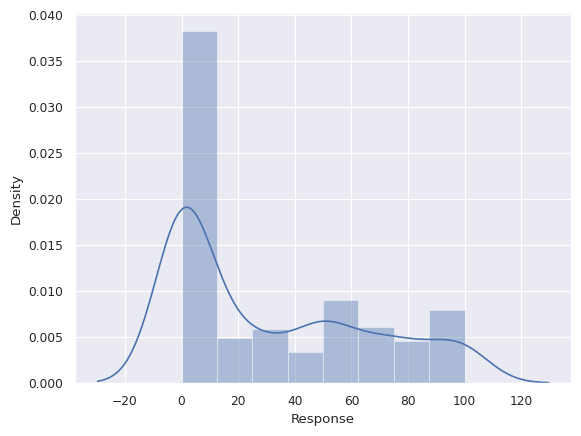

In [32]:
sns.distplot(long_df_bill_2_Q2['Response'])
plt.show()

<ipython-input-33-9628529dadc1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_3_Q2['Response'])


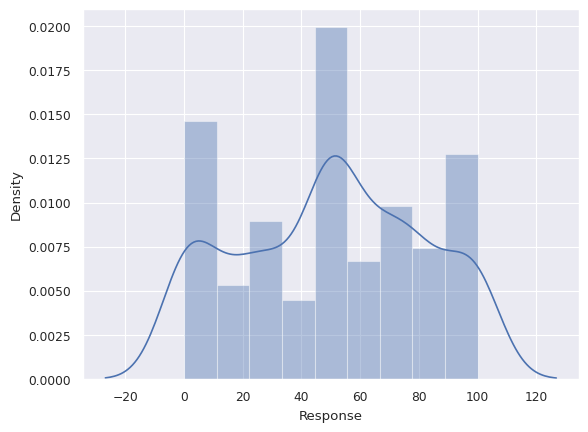

In [33]:
sns.distplot(long_df_bill_3_Q2['Response'])
plt.show()

<ipython-input-34-dea860dd430b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_Q3['Response'])


<Axes: xlabel='Response', ylabel='Density'>

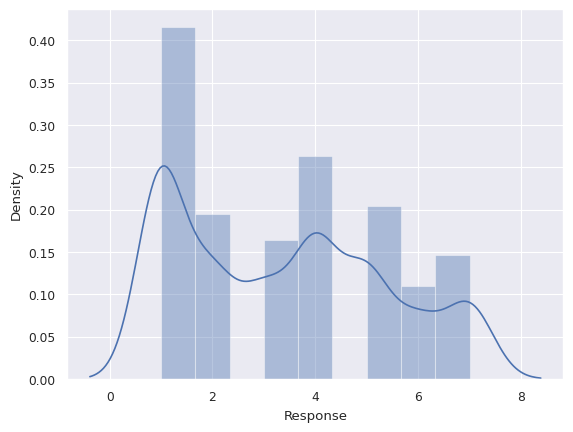

In [34]:
sns.distplot(long_df_Q3['Response'])

<ipython-input-35-68e99fe3f254>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_1_Q3['Response'])


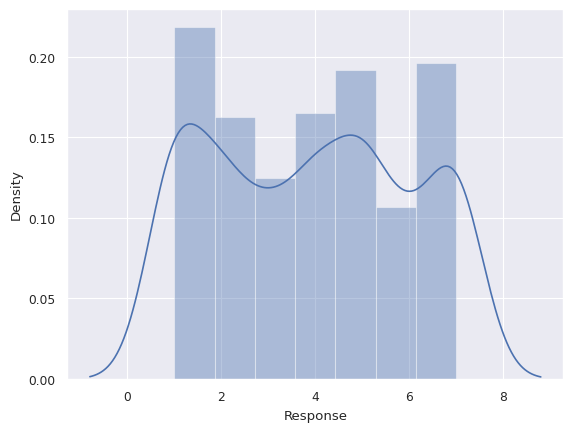

In [35]:
sns.distplot(long_df_bill_1_Q3['Response'])
plt.show()

<ipython-input-36-5b81f0805471>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_2_Q3['Response'])


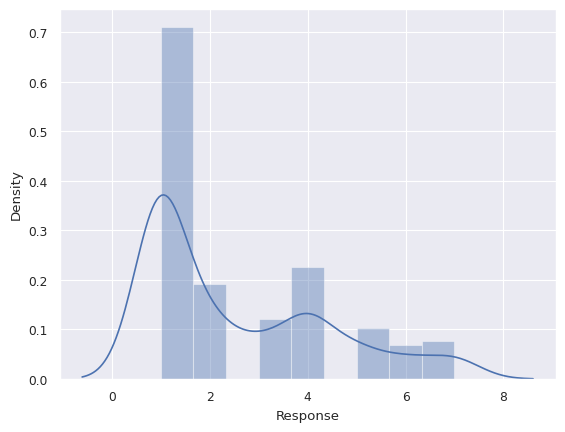

In [36]:
sns.distplot(long_df_bill_2_Q3['Response'])
plt.show()

<ipython-input-37-2ad15683d23c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(long_df_bill_3_Q3['Response'])


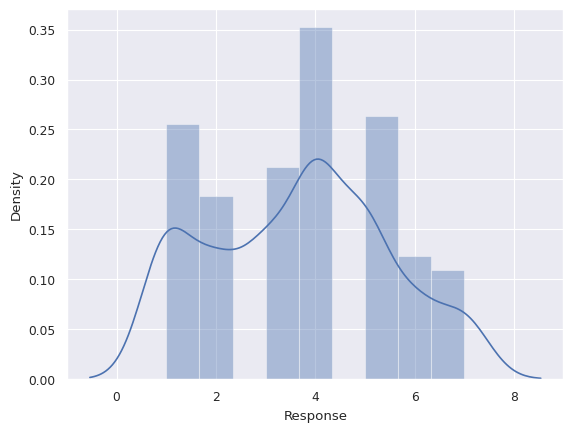

In [37]:
sns.distplot(long_df_bill_3_Q3['Response'])
plt.show()

<ipython-input-38-d6b5b267a5d4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.boxplot(y=long_df_Q1['Response'], palette = 'pastel')


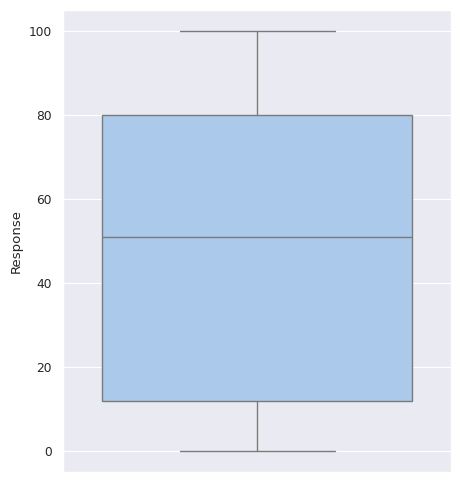

In [38]:
fig, ax = plt.subplots(figsize=(5, 6))
a = sns.boxplot(y=long_df_Q1['Response'], palette = 'pastel')
plt.savefig('BoxPlot_Q1', dpi = 300)
plt.show()

<ipython-input-39-3eb16d608843>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  b = sns.boxplot(y=long_df_Q2['Response'], palette = 'pastel')


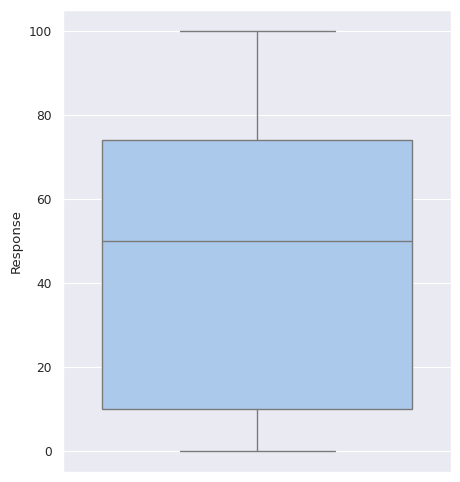

In [39]:
fig, ax = plt.subplots(figsize=(5, 6))
b = sns.boxplot(y=long_df_Q2['Response'], palette = 'pastel')
plt.savefig('BoxPlot_Q2', dpi = 300)
plt.show()

<ipython-input-40-23542ccf7730>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  c = sns.boxplot(y=long_df_Q3['Response'], palette='pastel')


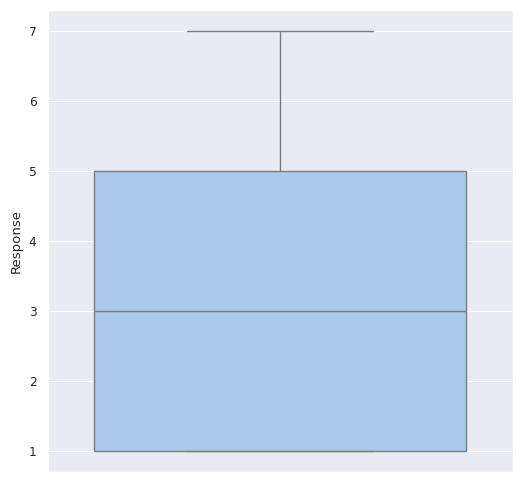

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
c = sns.boxplot(y=long_df_Q3['Response'], palette='pastel')
plt.savefig('BoxPlot_Q3', dpi = 300)
plt.show()

<ipython-input-41-0a2330a89c87>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=long_df_Q4['Response'], palette='pastel')


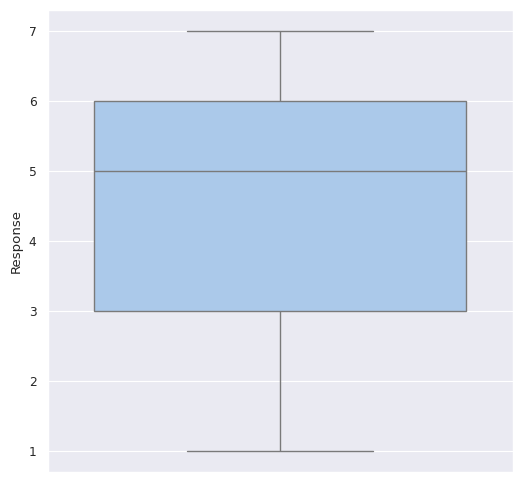

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(y=long_df_Q4['Response'], palette='pastel')
plt.show()

<ipython-input-42-8996cc78fcc9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=long_df_Q5['Response'], palette='pastel')


<Axes: ylabel='Response'>

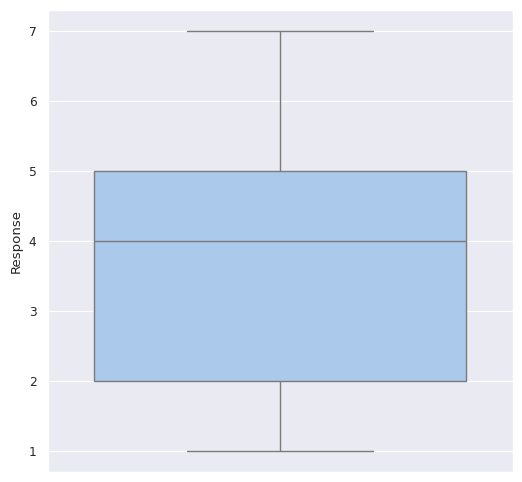

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(y=long_df_Q5['Response'], palette='pastel')

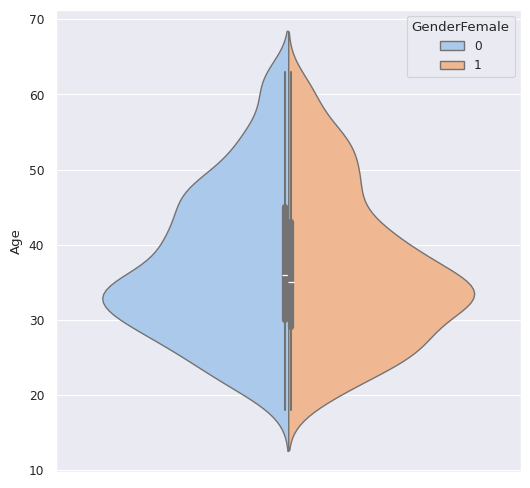

<Figure size 640x480 with 0 Axes>

In [43]:

fig, ax = plt.subplots(figsize=(6, 6))


sns.violinplot(data=long_df_Q1, x = 'Question',y='Age', hue = 'GenderFemale', ax=ax,palette='pastel', split = True)
ax.set(xlabel=None)
ax.set_xticklabels([])
plt.show()
plt.savefig('ViolinSex.png', dpi = 300)

In [44]:
print(long_df_bill_1_Q2['Age'].min())
print(long_df_bill_1_Q2['Age'].max())

18
63


### Additional Mediation Analyses (precaution)

In [45]:
print(pg.mediation_analysis(data=long_df_Q3_T1, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=1000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%] sig
0  RightsVersusGov ~ X  0.078010  0.068046  0.251878 -0.055512   0.211533  No
1  Y ~ RightsVersusGov -0.099542  0.056298  0.077333 -0.210012   0.010928  No
2                Total -0.153276  0.124011  0.216741 -0.396614   0.090063  No
3               Direct -0.145693  0.123971  0.240176 -0.388955   0.097568  No
4             Indirect -0.007582  0.009122  0.342000 -0.037179   0.004213  No


In [46]:
print(pg.mediation_analysis(data=long_df_Q3_T2, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=1000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  RightsVersusGov ~ X  0.048672  0.034725  0.161340 -0.019472   0.116816   No
1  Y ~ RightsVersusGov -0.231369  0.058414  0.000080 -0.345999  -0.116740  Yes
2                Total  0.134047  0.064315  0.037395  0.007838   0.260255  Yes
3               Direct  0.145596  0.063880  0.022867  0.020240   0.270952  Yes
4             Indirect -0.011549  0.009455  0.196000 -0.032639   0.004232   No


In [47]:
print(pg.mediation_analysis(data=long_df_Q2_T1, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=10000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  RightsVersusGov ~ X  0.078010  0.068046  0.251878 -0.055512   0.211533   No
1  Y ~ RightsVersusGov -2.083807  0.974706  0.032758 -3.996410  -0.171204  Yes
2                Total -2.424145  2.148774  0.259514 -6.640548   1.792257   No
3               Direct -2.264431  2.146628  0.291725 -6.476628   1.947766   No
4             Indirect -0.159714  0.171925  0.282400 -0.677909   0.058626   No


In [48]:
print(pg.mediation_analysis(data=long_df_Q2_T2, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=10000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%]  sig
0  RightsVersusGov ~ X  0.048672  0.034725  0.161340 -0.019472   0.116816   No
1  Y ~ RightsVersusGov -3.934901  1.002737  0.000093 -5.902630  -1.967171  Yes
2                Total  2.783951  1.102743  0.011739  0.619974   4.947928  Yes
3               Direct  2.981363  1.095346  0.006606  0.831899   5.130827  Yes
4             Indirect -0.197412  0.152703  0.165800 -0.564565   0.056096   No


In [49]:
print(pg.mediation_analysis(data=long_df_Q1_T1, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=10000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%] sig
0  RightsVersusGov ~ X  0.078010  0.068046  0.251878 -0.055512   0.211533  No
1  Y ~ RightsVersusGov -0.850356  1.023775  0.406385 -2.859245   1.158533  No
2                Total  1.237682  2.253819  0.583021 -3.184844   5.660209  No
3               Direct  1.305659  2.255535  0.562802 -3.120239   5.731557  No
4             Indirect -0.067977  0.124984  0.567800 -0.510601   0.066827  No


In [50]:
print(pg.mediation_analysis(data=long_df_Q1_T2, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=10000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%] sig
0  RightsVersusGov ~ X  0.048672  0.034725  0.161340 -0.019472   0.116816  No
1  Y ~ RightsVersusGov -1.403700  1.046134  0.179969 -3.456589   0.649189  No
2                Total  1.200455  1.145708  0.294993 -1.047833   3.448744  No
3               Direct  1.271289  1.146303  0.267685 -0.978171   3.520749  No
4             Indirect -0.070834  0.082030  0.319800 -0.336475   0.023462  No


In [51]:
print(pg.mediation_analysis(data=long_df_Q3_T1, x='Treatment', m='RightsVersusGov', y='Response', seed=42, n_boot=10000))

                  path      coef        se      pval  CI[2.5%]  CI[97.5%] sig
0  RightsVersusGov ~ X  0.078010  0.068046  0.251878 -0.055512   0.211533  No
1  Y ~ RightsVersusGov -0.099542  0.056298  0.077333 -0.210012   0.010928  No
2                Total -0.153276  0.124011  0.216741 -0.396614   0.090063  No
3               Direct -0.145693  0.123971  0.240176 -0.388955   0.097568  No
4             Indirect -0.007582  0.009076  0.335200 -0.036357   0.003090  No


In [52]:
pg.welch_anova(dv='Age', between='Treatment', data=long_df_Q2)

,Source,ddof1,ddof2,F,p-unc,np2
0,Treatment,2,1030.749026,0.427166,0.65247,0.000553


### Plots and contingency tables for independence tests

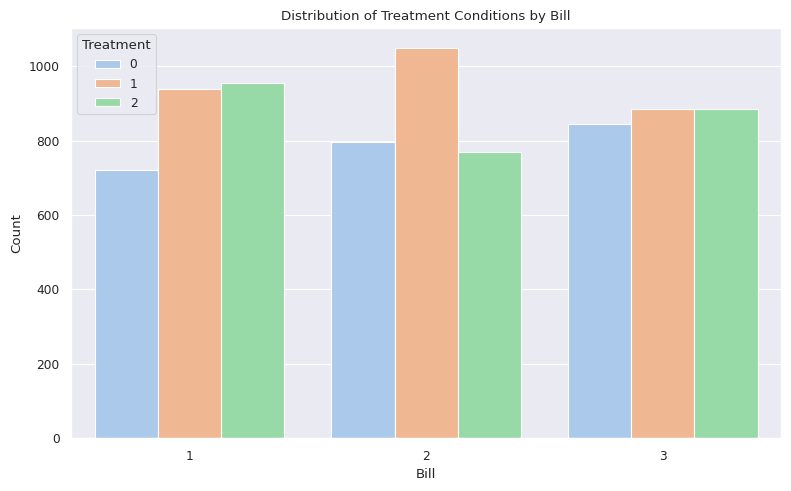

In [53]:
# Step 1: Create the crosstab
cross_tab = pd.crosstab(long_df['Bill'], long_df['Treatment'])

# Step 2: Melt it into long format
df_plot = cross_tab.reset_index().melt(id_vars='Bill',
                                       var_name='Treatment',
                                       value_name='Count')

# Step 3: Plot with Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Bill', y='Count', hue='Treatment', palette = 'pastel')

plt.title('Distribution of Treatment Conditions by Bill')
plt.xlabel('Bill')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('TreatBill.png', dpi = 300)
plt.show()

In [54]:
contingency_table_Treatment_Var = pd.crosstab(long_df_Q2['Treatment'], long_df_Q2['Var']).astype(int)
print('Chi Squared for Independence of Treatments and Variants')
print(np.round(np.array(stats.chi2_contingency(contingency_table_Treatment_Var )[:2]),4))

Chi Squared for Independence of Treatments and Variants
[6.8397 0.7405]


Chi Squared for Independence of Treatments and Variants
[6.8397 0.7405]


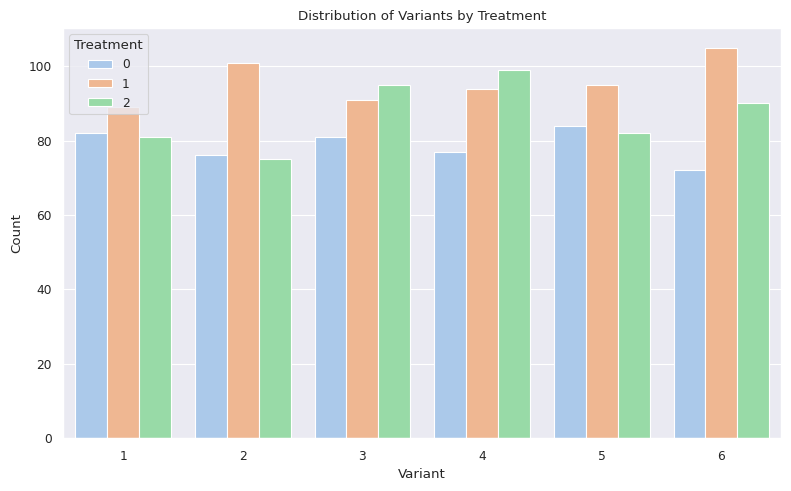

In [55]:

contingency_table_Treatment_Var = pd.crosstab(long_df_Q2['Treatment'], long_df_Q2['Var']).astype(int)


chi2_stat, p_val = stats.chi2_contingency(contingency_table_Treatment_Var)[:2]
print('Chi Squared for Independence of Treatments and Variants')
print(np.round([chi2_stat, p_val], 4))


df_plot = contingency_table_Treatment_Var.reset_index().melt(id_vars='Treatment',
                                                              var_name='Variant',
                                                              value_name='Count')


plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Variant', y='Count', hue='Treatment', palette = 'pastel')
plt.title('Distribution of Variants by Treatment')
plt.xlabel('Variant')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('VarTreatment.png', dpi = 300)
plt.show()

In [56]:
contingency_table_Treatment_Position = pd.crosstab(long_df_Q2['Treatment'], long_df_Q2['Position']).astype(int)
print('Chi Squared for Independence of Treatments and Positions')
print(np.round(np.array(stats.chi2_contingency(contingency_table_Treatment_Position)[:2]),4))

Chi Squared for Independence of Treatments and Positions
[5.5683 0.2338]


Chi Squared for Independence of Treatments and Positions
[5.5683 0.2338]


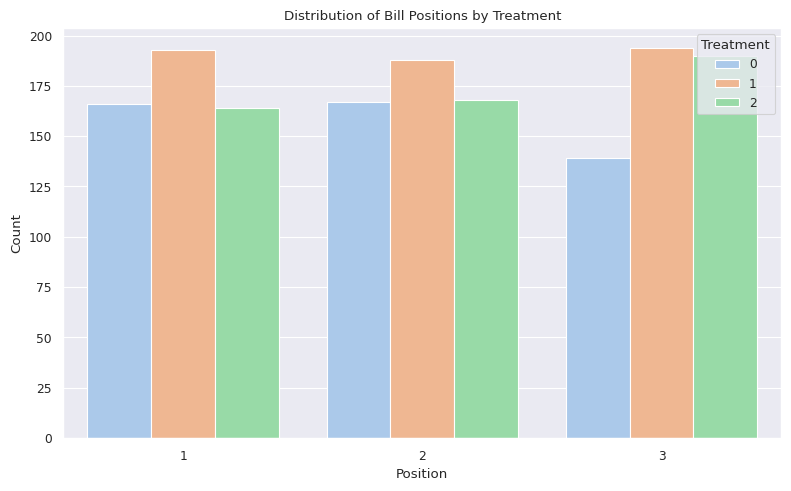

In [57]:

contingency_table_Treatment_Position = pd.crosstab(long_df_Q2['Treatment'], long_df_Q2['Position']).astype(int)


chi2_stat, p_val = stats.chi2_contingency(contingency_table_Treatment_Position)[:2]
print('Chi Squared for Independence of Treatments and Positions')
print(np.round([chi2_stat, p_val], 4))


df_plot = contingency_table_Treatment_Position.reset_index().melt(id_vars='Treatment',
                                                                   var_name='Position',
                                                                   value_name='Count')


plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Position', y='Count', hue='Treatment', palette = 'pastel')
plt.title('Distribution of Bill Positions by Treatment')
plt.xlabel('Position')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('PositionTreatment.png', dpi = 300)
plt.show()

In [58]:
contingency_table_Bill_Position = pd.crosstab(long_df_Q2['Bill'], long_df_Q2['Position']).astype(int)
print('Chi Squared for Independence of Bills and Positions')
print(np.round(np.array(stats.chi2_contingency(contingency_table_Bill_Position)[:2]),4))

Chi Squared for Independence of Bills and Positions
[0.5966 0.9634]


Chi Squared for Independence of Bills and Positions
[0.5966 0.9634]


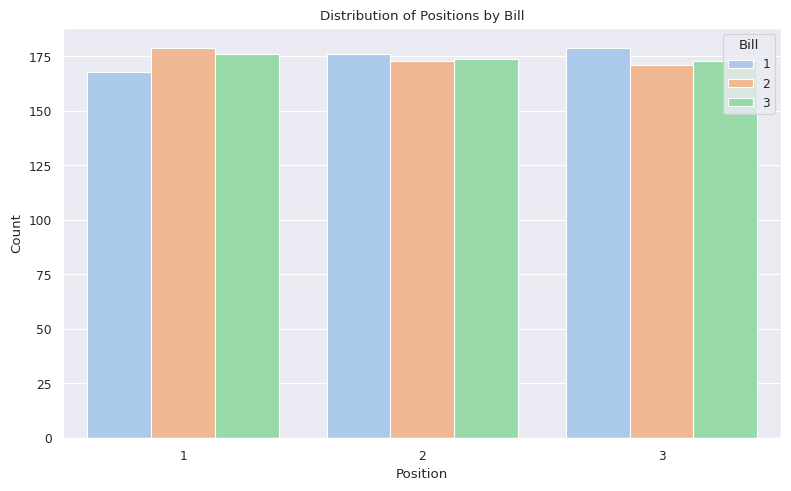

In [59]:

contingency_table_Bill_Position = pd.crosstab(long_df_Q2['Bill'], long_df_Q2['Position']).astype(int)


chi2_stat, p_val = stats.chi2_contingency(contingency_table_Bill_Position)[:2]
print('Chi Squared for Independence of Bills and Positions')
print(np.round([chi2_stat, p_val], 4))


df_plot = contingency_table_Bill_Position.reset_index().melt(id_vars='Bill',
                                                              var_name='Position',
                                                              value_name='Count')


plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Position', y='Count', hue='Bill', palette = 'pastel')
plt.title('Distribution of Positions by Bill')
plt.xlabel('Position')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('PositionBill.png', dpi = 300)
plt.show()

Chi Squared for Independence of Treatments and Repeated Exposure to Treatments
[2.9788 0.0844]
Chi Squared for Independence of Treatments and Repeated Exposure to Treatments
[2.9788 0.0844]


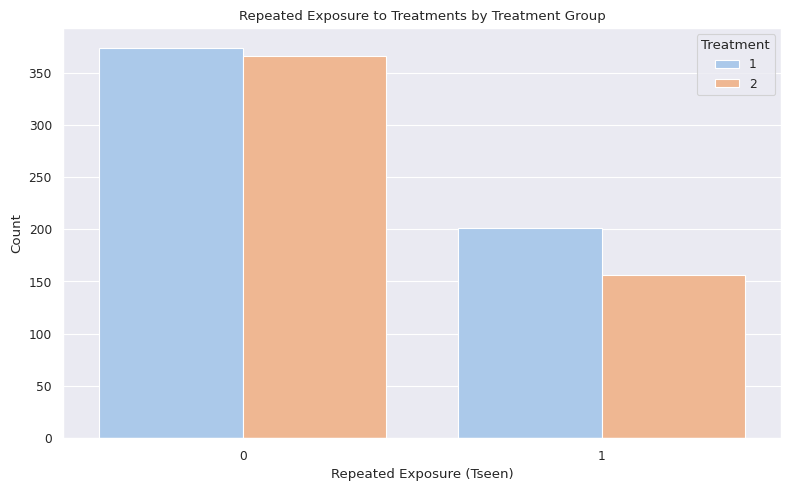

In [60]:
contingency_table_Treatment_Tseen = pd.crosstab(long_df_Q2_T['Tseen'], long_df_Q2_T['Treatment']).astype(int)
print('Chi Squared for Independence of Treatments and Repeated Exposure to Treatments')
print(np.round(np.array(stats.chi2_contingency(contingency_table_Treatment_Tseen)[:2]),4))

contingency_table_Treatment_Tseen = pd.crosstab(long_df_Q2_T['Tseen'], long_df_Q2_T['Treatment']).astype(int)


chi2_stat, p_val = stats.chi2_contingency(contingency_table_Treatment_Tseen)[:2]
print('Chi Squared for Independence of Treatments and Repeated Exposure to Treatments')
print(np.round([chi2_stat, p_val], 4))


df_plot = contingency_table_Treatment_Tseen.reset_index().melt(id_vars='Tseen',
                                                                var_name='Treatment',
                                                                value_name='Count')


plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='Tseen', y='Count', hue='Treatment', palette = 'pastel')
plt.title('Repeated Exposure to Treatments by Treatment Group')
plt.xlabel('Repeated Exposure (Tseen)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('TseenTreament.png', dpi = 300)
plt.show()

### Pairwise t-tests

In [61]:
ttest_1 = pg.pairwise_tests(dv = 'Response', between = 'Treatment', data = long_df_Q1, padjust='bonf')
ttest_1

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Treatment,0,1,False,True,-0.548284,999.319995,two-sided,0.583619,1.000000,bonf,0.081,-0.034084
1,Treatment,0,2,False,True,-1.046304,975.799912,two-sided,0.295680,0.887039,bonf,0.122,-0.066501
2,Treatment,1,2,False,True,-0.537499,1087.193054,two-sided,0.591033,1.000000,bonf,0.078,-0.032453


In [62]:
ttest_2 = pg.pairwise_tests(dv = 'Response', between = 'Treatment', data = long_df_Q2, padjust='bonf')
ttest_2

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Treatment,0,1,False,True,1.127114,1001.981512,two-sided,0.259964,0.779892,bonf,0.13,0.070020
1,Treatment,0,2,False,True,-2.524220,981.469877,two-sided,0.011752,0.035257,bonf,1.627,-0.160231
2,Treatment,1,2,False,True,-3.824145,1083.411917,two-sided,0.000139,0.000416,bonf,88.203,-0.231105


In [63]:
ttest_3 = pg.pairwise_tests(dv = 'Response', between = 'Treatment',data = long_df_Q3, padjust='bonf')
ttest_3

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Treatment,0,1,False,True,1.232082,992.592878,two-sided,0.218210,0.654631,bonf,0.147,0.076713
1,Treatment,0,2,False,True,-2.083589,980.781709,two-sided,0.037456,0.112368,bonf,0.601,-0.132283
2,Treatment,1,2,False,True,-3.494179,1078.739232,two-sided,0.000495,0.001484,bonf,27.151,-0.211363


In [64]:
ttest_4 = pg.pairwise_tests(dv = 'Response', between = 'Treatment',data = long_df_Q4, padjust='bonf')
ttest_4

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Treatment,0,1,False,True,-1.791583,988.510350,two-sided,0.073506,0.220517,bonf,0.338,-0.111653
1,Treatment,0,2,False,True,0.556717,977.694671,two-sided,0.577848,1.000000,bonf,0.083,0.035370
2,Treatment,1,2,False,True,2.459907,1079.926724,two-sided,0.014053,0.042159,bonf,1.331,0.148766


In [65]:
ttest_5 = pg.pairwise_tests(dv = 'Response', between = 'Treatment',data = long_df_Q5, padjust='bonf')
ttest_5

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Treatment,0,1,False,True,-0.121046,1006.447153,two-sided,0.903679,1.000000,bonf,0.07,-0.007511
1,Treatment,0,2,False,True,-1.565750,982.527702,two-sided,0.117729,0.353187,bonf,0.238,-0.099363
2,Treatment,1,2,False,True,-1.518923,1084.734423,two-sided,0.129073,0.387220,bonf,0.211,-0.091766


### Plots with CI for means per policy proposal

<ipython-input-66-cc415ac8b69e>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q1, x='Bill', y='Response', errorbar=('ci', 95), join=True)


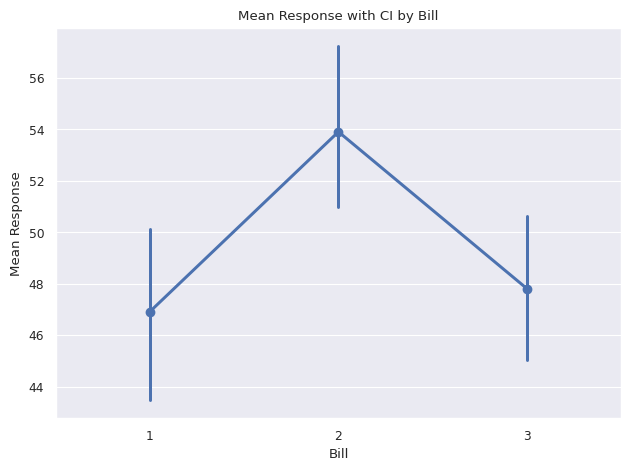

In [66]:
sns.pointplot(data=long_df_Q1, x='Bill', y='Response', errorbar=('ci', 95), join=True)
plt.title('Mean Response with CI by Bill')
plt.ylabel('Mean Response')
plt.xlabel('Bill')
plt.tight_layout()
plt.savefig('IssueSalienceMean.png', dpi = 300)
plt.show()

<ipython-input-67-32874ac56aac>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q2, x='Bill', y='Response', errorbar=('ci', 95), join=True)


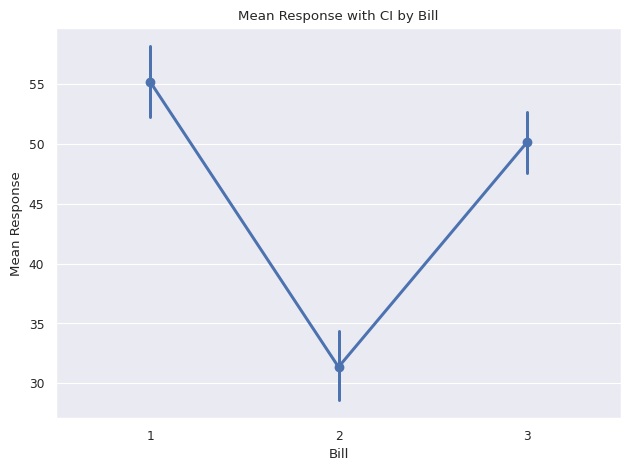

In [67]:
sns.pointplot(data=long_df_Q2, x='Bill', y='Response', errorbar=('ci', 95), join=True)
plt.title('Mean Response with CI by Bill')
plt.ylabel('Mean Response')
plt.xlabel('Bill')
plt.tight_layout()
plt.savefig('PolicyAttitudeMean.png', dpi = 300)
plt.show()

<ipython-input-68-fe6e205373b4>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q3, x='Bill', y='Response', errorbar=('ci', 95), join=True)


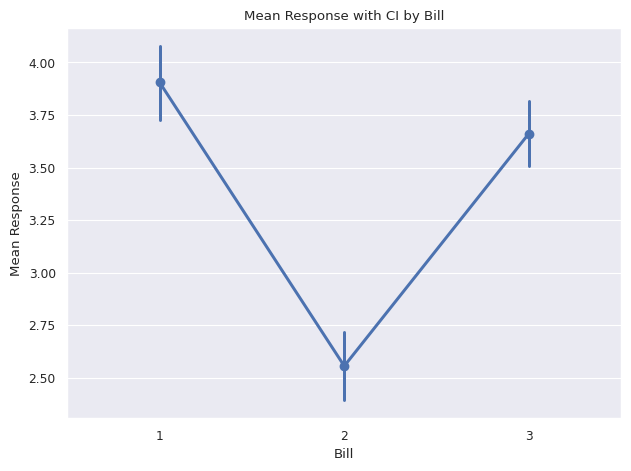

In [68]:
sns.pointplot(data=long_df_Q3, x='Bill', y='Response', errorbar=('ci', 95), join=True)
plt.title('Mean Response with CI by Bill')
plt.ylabel('Mean Response')
plt.xlabel('Bill')
plt.tight_layout()
plt.savefig('PolicySupportMean.png', dpi = 300)
plt.show()

<ipython-input-69-2e731fef9943>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q4, x='Bill', y='Response', errorbar=('ci', 95), join=True)


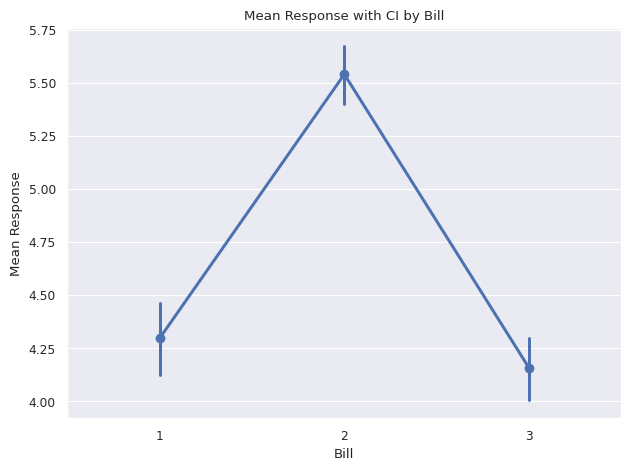

In [69]:
sns.pointplot(data=long_df_Q4, x='Bill', y='Response', errorbar=('ci', 95), join=True)
plt.title('Mean Response with CI by Bill')
plt.ylabel('Mean Response')
plt.xlabel('Bill')
plt.tight_layout()
plt.savefig('FirstCheckMean.png', dpi = 300)
plt.show()

<ipython-input-70-b5e4602d682b>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q5, x='Bill', y='Response', errorbar=('ci', 95), join=True)


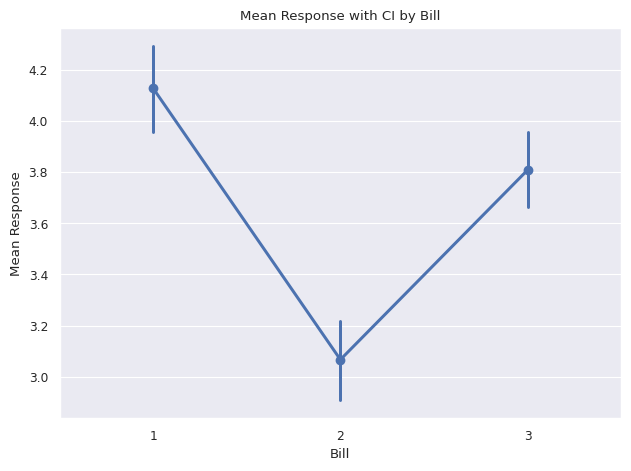

In [70]:
sns.pointplot(data=long_df_Q5, x='Bill', y='Response', errorbar=('ci', 95), join=True)
plt.title('Mean Response with CI by Bill')
plt.ylabel('Mean Response')
plt.xlabel('Bill')
plt.tight_layout()
plt.savefig('SecondCheckMean.png', dpi = 300)
plt.show()

### Plots with CI for treatments

<ipython-input-71-76be672d6df9>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=long_df_Q1, x='Treatment', y='Response', ci= 95, join=True)
<ipython-input-71-76be672d6df9>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q1, x='Treatment', y='Response', ci= 95, join=True)


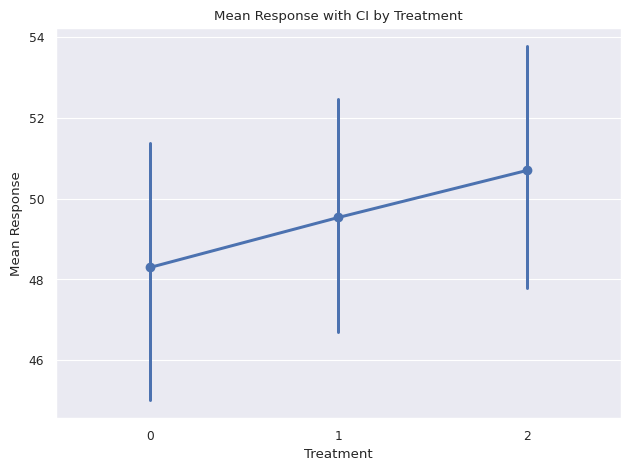

In [71]:
sns.pointplot(data=long_df_Q1, x='Treatment', y='Response', ci= 95, join=True)
plt.title('Mean Response with CI by Treatment')
plt.ylabel('Mean Response')
plt.xlabel('Treatment')
plt.tight_layout()
plt.savefig('IssueSalienceTreatment.png', dpi = 300)
plt.show()

<ipython-input-72-c4778d716a4a>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=long_df_Q2, x='Treatment', y='Response', ci= 95, join=True)
<ipython-input-72-c4778d716a4a>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q2, x='Treatment', y='Response', ci= 95, join=True)


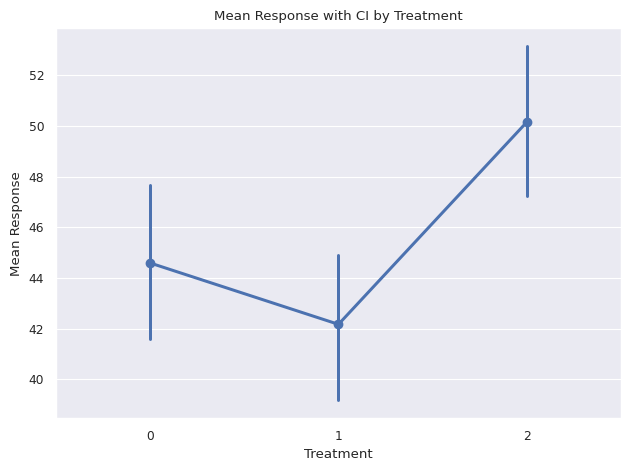

In [72]:
sns.pointplot(data=long_df_Q2, x='Treatment', y='Response', ci= 95, join=True)
plt.title('Mean Response with CI by Treatment')
plt.ylabel('Mean Response')
plt.xlabel('Treatment')
plt.tight_layout()
plt.savefig('PolicyAttitudeTreatment.png', dpi = 300)
plt.show()

<ipython-input-73-7de93303ff15>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=long_df_Q3, x='Treatment', y='Response', ci= 95, join=True)
<ipython-input-73-7de93303ff15>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q3, x='Treatment', y='Response', ci= 95, join=True)


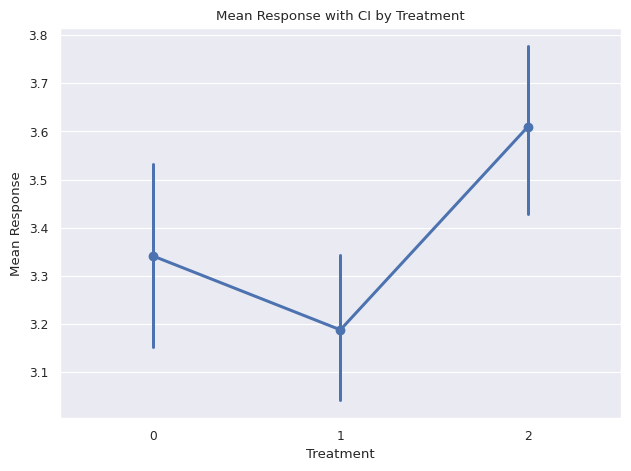

In [73]:
sns.pointplot(data=long_df_Q3, x='Treatment', y='Response', ci= 95, join=True)
plt.title('Mean Response with CI by Treatment')
plt.ylabel('Mean Response')
plt.xlabel('Treatment')
plt.tight_layout()
plt.savefig('PolicySupportTreatment.png', dpi = 300)
plt.show()

<ipython-input-74-ae5616a7b1f3>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=long_df_Q4, x='Treatment', y='Response', ci= 95, join=True)
<ipython-input-74-ae5616a7b1f3>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q4, x='Treatment', y='Response', ci= 95, join=True)


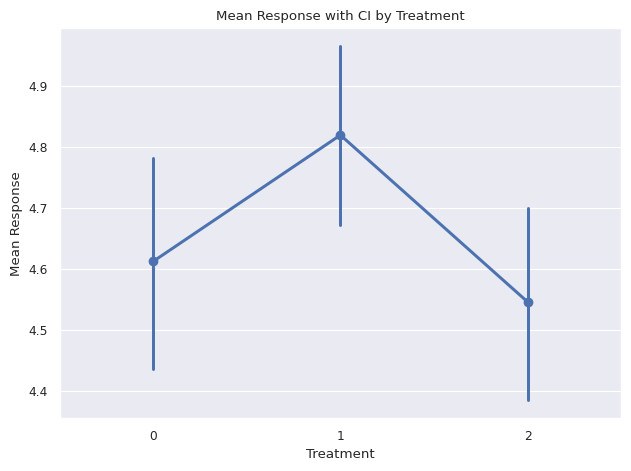

In [74]:
sns.pointplot(data=long_df_Q4, x='Treatment', y='Response', ci= 95, join=True)
plt.title('Mean Response with CI by Treatment')
plt.ylabel('Mean Response')
plt.xlabel('Treatment')
plt.tight_layout()
plt.savefig('FirstCheckTreatment.png', dpi = 300)
plt.show()

<ipython-input-75-87cf2bfd704c>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(data=long_df_Q5, x='Treatment', y='Response', ci= 95, join=True)
<ipython-input-75-87cf2bfd704c>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=long_df_Q5, x='Treatment', y='Response', ci= 95, join=True)


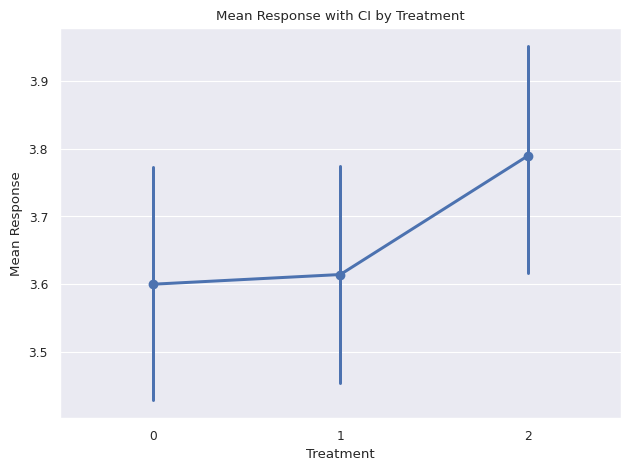

In [75]:
sns.pointplot(data=long_df_Q5, x='Treatment', y='Response', ci= 95, join=True)
plt.title('Mean Response with CI by Treatment')
plt.ylabel('Mean Response')
plt.xlabel('Treatment')
plt.tight_layout()
plt.savefig('SecondCheckTreatment.png', dpi = 300)
plt.show()

## Regression Models

In [76]:
#We define snipets of formulas for Control Variables (controls) and techincal controls
control_variables = ' + PolTrust + PolCompetence + PolInf + GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + RelImp + RelQuant + GenderFemale + Age'
technical_controls = ' + C(Bill) + C(Position) + Tseen '

### Regression models for Issue Salience

In [77]:
formula010 = 'Response ~ C(Treatment)'
model010 = statf.ols(formula010,
                     data = long_df_Q1).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q1['ID']})
print(model010.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6325
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.532
Time:                        15:07:53   Log-Likelihood:                -7849.8
No. Observations:                1569   AIC:                         1.571e+04
Df Residuals:                    1566   BIC:                         1.572e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            48.2945      1.67

In [78]:
check_heteroskedasticity_autocorrelation(model010, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(1.2822398020320134),
  'LM p-value': np.float64(0.5267022392575837),
  'F stat': np.float64(0.6404174210951319),
  'F p-value': np.float64(0.5272103497696413)},
 'Breusch-Godfrey': {'LM stat': np.float64(53.217735014166806),
  'LM p-value': np.float64(2.7791735764381704e-12),
  'F stat': 27.455307891115257,
  'F p-value': 1.909204538227093e-12}}

In [79]:
formula011 = 'Response ~ C(Treatment)' + technical_controls
model011 = statf.ols(formula011,
                     data = long_df_Q1).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q1['ID']})
print(model011.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.024
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           0.000263
Time:                        15:07:53   Log-Likelihood:                -7838.9
No. Observations:                1569   AIC:                         1.569e+04
Df Residuals:                    1561   BIC:                         1.574e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            41.5748      2.36

In [80]:
check_heteroskedasticity_autocorrelation(model011, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(33.811911747629054),
  'LM p-value': np.float64(1.8678078722497105e-05),
  'F stat': np.float64(4.911486988089354),
  'F p-value': np.float64(1.677333020454326e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(59.87904012056995),
  'LM p-value': np.float64(9.94103601036009e-14),
  'F stat': 30.92907262895172,
  'F p-value': 6.719132579199557e-14}}

In [81]:
formula012 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model012 = statf.ols(formula012,
                     data = long_df_Q1).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q1['ID']})
print(model012.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     7.085
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.54e-18
Time:                        15:07:53   Log-Likelihood:                -7770.3
No. Observations:                1569   AIC:                         1.558e+04
Df Residuals:                    1547   BIC:                         1.570e+04
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            43.4904      8.96

In [82]:
check_heteroskedasticity_autocorrelation(model012, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(95.91483803360425),
  'LM p-value': np.float64(1.5115015549891557e-11),
  'F stat': np.float64(4.796549842628872),
  'F p-value': np.float64(6.048122434688953e-12)},
 'Breusch-Godfrey': {'LM stat': np.float64(41.527963241202436),
  'LM p-value': np.float64(9.6010196784578e-10),
  'F stat': 21.002251322323076,
  'F p-value': 1.0014422903421695e-09}}

In [83]:
formula013 = 'Response ~ C(Treatment)*RightsVersusGov' + technical_controls + control_variables
model013 = statf.ols(formula013,
                     data = long_df_Q1).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q1['ID']})
print(model013.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     6.370
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.87e-18
Time:                        15:07:53   Log-Likelihood:                -7768.4
No. Observations:                1569   AIC:                         1.559e+04
Df Residuals:                    1544   BIC:                         1.572e+04
Df Model:                          24                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [84]:
check_heteroskedasticity_autocorrelation(model013, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(98.75519933248954),
  'LM p-value': np.float64(4.894067746258471e-11),
  'F stat': np.float64(4.321219945258342),
  'F p-value': np.float64(1.960950092364738e-11)},
 'Breusch-Godfrey': {'LM stat': np.float64(41.25505383766829),
  'LM p-value': np.float64(1.1004717132522804e-09),
  'F stat': 20.81999785942194,
  'F p-value': 1.1965208303063088e-09}}

In [85]:
keep_vars = ['C(Treatment)[T.1]', 'C(Treatment)[T.2]', 'C(Bill)[T.2]', 'C(Bill)[T.3]','RightsVersusGov',
             'C(Treatment)[T.1]:RightsVersusGov', 'C(Treatment)[T.2]:RightsVersusGov', 'Intercept']
controls_names = ['PolTrust', 'PolCompetence', 'PolInf', 'GovStrongLeader', 'GovExperts', 'GovDem',
       'Educ', 'Ecstat', 'Place', 'PolInt', 'RelImp', 'RelQuant',
       'GenderFemale', 'Age']
tech_controls = ['C(Position)[T.2]', 'C(Position)[T.3]', 'Tseen', 'C(Bill)[T.2]', 'C(Bill)[T.3]']
info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'
}

### Regression models for General Policy Attitude

In [86]:
formula020 = 'Response ~ C(Treatment)'
model020 = statf.ols(formula020,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model020.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.454
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           0.000643
Time:                        15:07:54   Log-Likelihood:                -7786.2
No. Observations:                1569   AIC:                         1.558e+04
Df Residuals:                    1566   BIC:                         1.559e+04
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            44.5911      1.66

In [87]:
check_heteroskedasticity_autocorrelation(model020, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(0.12596970415565023),
  'LM p-value': np.float64(0.9389576968395246),
  'F stat': np.float64(0.06286946972743793),
  'F p-value': np.float64(0.9390684123065369)},
 'Breusch-Godfrey': {'LM stat': np.float64(49.380921760850775),
  'LM p-value': np.float64(1.8926446609985776e-11),
  'F stat': 25.41155304639326,
  'F p-value': 1.378550557896359e-11}}

In [88]:
formula021 = 'Response ~ C(Treatment)' + technical_controls
model021 = statf.ols(formula021,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model021.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     29.65
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.69e-34
Time:                        15:07:54   Log-Likelihood:                -7716.4
No. Observations:                1569   AIC:                         1.545e+04
Df Residuals:                    1561   BIC:                         1.549e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            55.1494      2.16

In [89]:
check_heteroskedasticity_autocorrelation(model021, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(17.85267381716117),
  'LM p-value': np.float64(0.012652688401889715),
  'F stat': np.float64(2.5665816483234924),
  'F p-value': np.float64(0.012466720755895737)},
 'Breusch-Godfrey': {'LM stat': np.float64(69.43730591452498),
  'LM p-value': np.float64(8.353733215654819e-16),
  'F stat': 36.09477627968172,
  'F p-value': 4.746163130523728e-16}}

In [90]:
formula022 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model022 = statf.ols(formula022,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model022.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     23.64
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.87e-62
Time:                        15:07:54   Log-Likelihood:                -7595.6
No. Observations:                1569   AIC:                         1.524e+04
Df Residuals:                    1547   BIC:                         1.535e+04
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.2230      7.84

In [91]:
formula022 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model022 = statf.ols(formula022,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model022.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     23.64
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.87e-62
Time:                        15:07:54   Log-Likelihood:                -7595.6
No. Observations:                1569   AIC:                         1.524e+04
Df Residuals:                    1547   BIC:                         1.535e+04
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.2230      7.84

In [92]:
check_heteroskedasticity_autocorrelation(model022, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(57.303794076969005),
  'LM p-value': np.float64(3.2393406640475395e-05),
  'F stat': np.float64(2.7924787271830467),
  'F p-value': np.float64(2.6320306999467598e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(27.65562881148756),
  'LM p-value': np.float64(9.877715350724722e-07),
  'F stat': 13.860610033824408,
  'F p-value': 1.0808849560776663e-06}}

In [93]:
aov = anova_lm(model022, typ=2)

# --- key rows -------------------------------------------------------------
ss_treat = aov.loc['C(Treatment)', 'sum_sq']
ss_error = aov.loc['Residual',        'sum_sq']

eta2_treat = ss_treat / (ss_treat + ss_error)         # partial η²
f_effect   = np.sqrt(eta2_treat / (1 - eta2_treat))   # Cohen f

print(f"partial η² = {eta2_treat:.4f}  →  Cohen f = {f_effect:.3f}")

partial η² = 0.0080  →  Cohen f = 0.090


<ipython-input-94-de4bebcd4f03>:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=effects_df, x='Treatment', y='Effect', join=False)


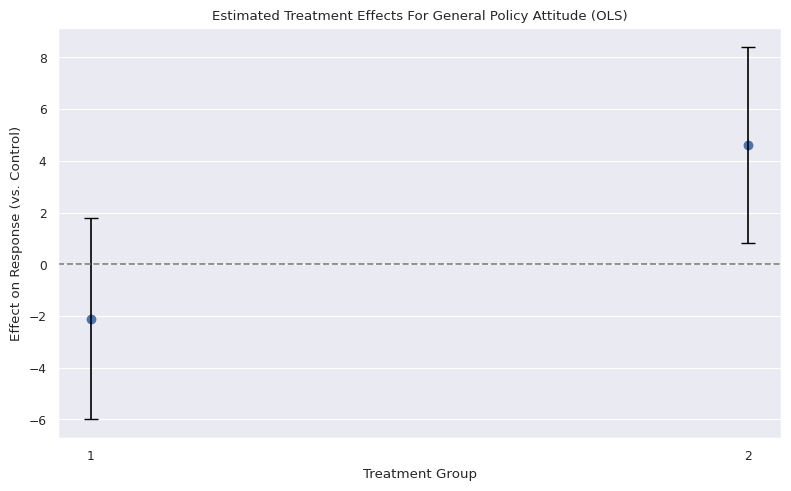

In [94]:
coefs = model022.params.filter(like='C(Treatment)')
conf_int = model022.conf_int().loc[coefs.index]

# Build a DataFrame
effects_df = pd.DataFrame({
    'Effect': coefs.values,
    'Lower': conf_int[0].values,
    'Upper': conf_int[1].values,
    'Term': coefs.index
})
effects_df['Treatment'] = effects_df['Term'].str.extract(r'\[T\.(\d+)\]')[0].fillna('0').astype(str)
plt.figure(figsize=(8, 5))
sns.pointplot(data=effects_df, x='Treatment', y='Effect', join=False)
plt.errorbar(x=effects_df['Treatment'],
             y=effects_df['Effect'],
             yerr=[effects_df['Effect'] - effects_df['Lower'],
                   effects_df['Upper'] - effects_df['Effect']],
             fmt='none', capsize=5, color='black')

plt.axhline(0, color='gray', linestyle='--')
plt.title('Estimated Treatment Effects For General Policy Attitude (OLS)')
plt.ylabel('Effect on Response (vs. Control)')
plt.xlabel('Treatment Group')
plt.tight_layout()
plt.savefig('OLS_Policy_Attitude.png', dpi = 300)
plt.show()

In [95]:
long_df_Q2_index = long_df_Q2.set_index(['ID', 'Position'])
formula023 = 'Response ~ 1 + C(Treatment)' + ' + C(Bill) +  Tseen ' + control_variables
model023 = RandomEffects.from_formula(formula023,
                     data = long_df_Q2_index).fit()
print(model023)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2091
Estimator:              RandomEffects   R-squared (Between):              0.2741
No. Observations:                1569   R-squared (Within):               0.1720
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2225
Time:                        15:07:55   Log-likelihood                   -7428.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.551
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(19,1549)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             21.551
                            

In [96]:
formula024 = 'Response ~ C(Treatment)' + '+ C(Bill) +  Tseen ' + control_variables
model024 = sm.MixedLM.from_formula(formula024,
                     data = long_df_Q2,groups="ID").fit(reml = False)
print(model024.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Response  
No. Observations:     1569      Method:               ML        
No. Groups:           523       Scale:                758.3808  
Min. group size:      3         Log-Likelihood:       -7569.5876
Max. group size:      3         Converged:            Yes       
Mean group size:      3.0                                       
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          70.626    7.668   9.211 0.000  55.597  85.655
C(Treatment)[T.1]  -1.535    1.950  -0.788 0.431  -5.356   2.286
C(Treatment)[T.2]   3.906    1.955   1.998 0.046   0.074   7.738
C(Bill)[T.2]      -23.505    1.707 -13.768 0.000 -26.851 -20.159
C(Bill)[T.3]       -5.004    1.705  -2.935 0.003  -8.345  -1.663
Tseen              -0.568    1.854  -0.

In [97]:
long_df_Q2_short = long_df_Q2[long_df_Q2['Tseen'] == 0]
formula024_low = 'Response ~ C(Treatment)' + '+ C(Bill)' + control_variables
model024_low = sm.MixedLM.from_formula(formula024_low,
                     data = long_df_Q2_short,groups="ID").fit(reml = False)
print(model024_low.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Response  
No. Observations:     1212      Method:               ML        
No. Groups:           523       Scale:                779.8919  
Min. group size:      1         Log-Likelihood:       -5841.4530
Max. group size:      3         Converged:            Yes       
Mean group size:      2.3                                       
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          69.991    8.059   8.685 0.000  54.196  85.786
C(Treatment)[T.1]  -1.444    2.025  -0.713 0.476  -5.414   2.525
C(Treatment)[T.2]   3.884    2.036   1.908 0.056  -0.105   7.874
C(Bill)[T.2]      -23.018    2.004 -11.488 0.000 -26.945 -19.091
C(Bill)[T.3]       -4.265    2.013  -2.119 0.034  -8.209  -0.320
PolTrust            2.117    1.227   1.

In [98]:
formula025 = 'Response ~ C(Treatment)' + '+ C(Bill) + C(Position)' + control_variables
model025 = statf.ols(formula025,
                     data = long_df_Q2_short).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2_short['ID']})
print(model025.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     24.61
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.48e-62
Time:                        15:07:56   Log-Likelihood:                -5850.4
No. Observations:                1212   AIC:                         1.174e+04
Df Residuals:                    1191   BIC:                         1.185e+04
Df Model:                          20                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            70.5006      7.99

In [99]:
check_heteroskedasticity_autocorrelation(model025, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(49.624564954738375),
  'LM p-value': np.float64(0.00025059392360061213),
  'F stat': np.float64(2.542330777094923),
  'F p-value': np.float64(0.00020970742721633347)},
 'Breusch-Godfrey': {'LM stat': np.float64(9.553425615963263),
  'LM p-value': np.float64(0.008423643640063979),
  'F stat': 4.723296360671606,
  'F p-value': 0.009053246245114048}}

In [100]:
aov = anova_lm(model025, typ=2)


ss_treat = aov.loc['C(Treatment)', 'sum_sq']
ss_error = aov.loc['Residual',        'sum_sq']

eta2_treat = ss_treat / (ss_treat + ss_error)
f_effect   = np.sqrt(eta2_treat / (1 - eta2_treat))

print(f"partial η² = {eta2_treat:.4f}  →  Cohen f = {f_effect:.3f}")

partial η² = 0.0066  →  Cohen f = 0.082


In [101]:
long_df_Q2_index_short = long_df_Q2_short.set_index(['ID', 'Position'])
formula026 = 'Response ~ 1 + C(Treatment)' + '+ C(Bill)' + control_variables
model026 = RandomEffects.from_formula(formula026,
                     data = long_df_Q2_index_short).fit()
print(model026)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2294
Estimator:              RandomEffects   R-squared (Between):              0.2949
No. Observations:                1212   R-squared (Within):               0.1664
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2415
Time:                        15:07:57   Log-likelihood                   -5762.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      19.731
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(18,1193)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             19.798
                            

In [102]:
formula027 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model027 = statf.ols(formula027,
                     data = long_df_Q2).fit(cov_type='HC3')
print(model027.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     26.76
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           7.66e-89
Time:                        15:07:57   Log-Likelihood:                -7595.6
No. Observations:                1569   AIC:                         1.524e+04
Df Residuals:                    1547   BIC:                         1.535e+04
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.2230      6.97

In [103]:
formula028 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model028 = statf.ols(formula028,
                     data = long_df_Q2).fit(
    cov_type='HAC',
    cov_kwds={
        'maxlags': 2,          # truncation lag
        'kernel': 'bartlett',  # other options: 'uniform', 'triangular', 'parzen', 'qs'
        'use_correction': True # finite‐sample Bartlett correction
    }
)
print(model028.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     24.64
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           6.23e-82
Time:                        15:07:57   Log-Likelihood:                -7595.6
No. Observations:                1569   AIC:                         1.524e+04
Df Residuals:                    1547   BIC:                         1.535e+04
Df Model:                          21                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.2230      7.56

In [104]:
formula029 = 'Response ~ C(Treatment)*RightsVersusGov'
model029= statf.ols(formula029,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model029.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     5.576
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           5.12e-05
Time:                        15:07:57   Log-Likelihood:                -7777.9
No. Observations:                1569   AIC:                         1.557e+04
Df Residuals:                    1563   BIC:                         1.560e+04
Df Model:                           5                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [105]:
check_heteroskedasticity_autocorrelation(model029, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(0.11163349970428227),
  'LM p-value': np.float64(0.999787161107878),
  'F stat': np.float64(0.022242903161675886),
  'F p-value': np.float64(0.9997886415287177)},
 'Breusch-Godfrey': {'LM stat': np.float64(47.194614685905705),
  'LM p-value': np.float64(5.647023995796981e-11),
  'F stat': 24.20506401003881,
  'F p-value': 4.442046119405468e-11}}

In [106]:
formula029 = 'Response ~ C(Treatment)*RightsVersusGov' + technical_controls + control_variables
model029_high= statf.ols(formula029,
                     data = long_df_Q2).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model029_high.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     21.60
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.91e-63
Time:                        15:07:57   Log-Likelihood:                -7593.3
No. Observations:                1569   AIC:                         1.524e+04
Df Residuals:                    1544   BIC:                         1.537e+04
Df Model:                          24                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [107]:
check_heteroskedasticity_autocorrelation(model029_high, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(60.78794528678838),
  'LM p-value': np.float64(4.940177738357545e-05),
  'F stat': np.float64(2.5929318987753383),
  'F p-value': np.float64(3.986708571135494e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(27.42222092007699),
  'LM p-value': np.float64(1.1100444925793866e-06),
  'F stat': 13.714865779913971,
  'F p-value': 1.2475729976039962e-06}}

In [108]:
aov = anova_lm(model029_high, typ=2)

# --- key rows -------------------------------------------------------------
ss_treat = aov.loc['C(Treatment)', 'sum_sq']
ss_error = aov.loc['Residual',        'sum_sq']

eta2_treat = ss_treat / (ss_treat + ss_error)         # partial η²
f_effect   = np.sqrt(eta2_treat / (1 - eta2_treat))   # Cohen f

print(f"partial η² = {eta2_treat:.4f}  →  Cohen f = {f_effect:.3f}")

partial η² = 0.0072  →  Cohen f = 0.085


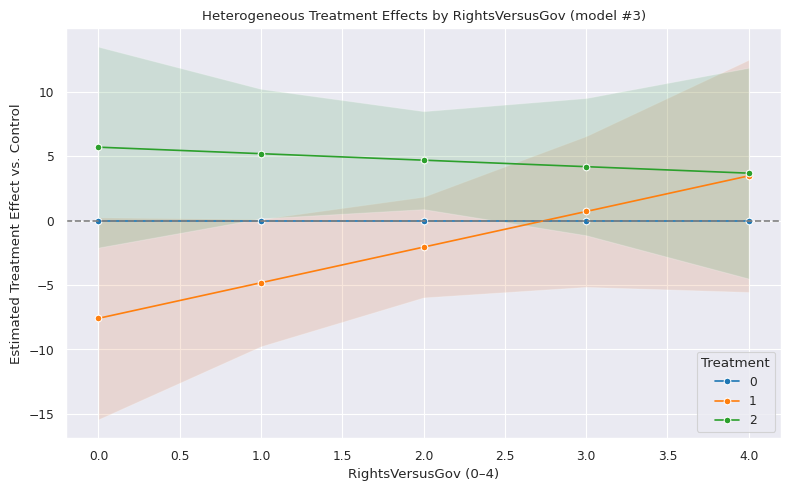

In [109]:

b    = model029_high.params
covb = model029_high.cov_params()


all_treats = sorted(long_df_Q2['Treatment'].unique())
mods       = sorted(long_df_Q2['RightsVersusGov'].unique())


rows = []
for t in all_treats:
    if t == 0:

        for m in mods:
            rows.append({
                'Treatment': '0',
                'RightsVersusGov': m,
                'Effect': 0.0,
                'Lower':  0.0,
                'Upper':  0.0
            })
    else:
        main = f"C(Treatment)[T.{t}]"
        inter= f"C(Treatment)[T.{t}]:RightsVersusGov"
        β_main = b.get(main, 0.0)
        β_int  = b.get(inter, 0.0)
        for m in mods:

            eff = β_main + β_int * m


            v_main = covb.loc[main, main]
            v_int  = covb.loc[inter, inter]   if inter in covb.index else 0.0
            cov_mi = covb.loc[main, inter]   if inter in covb.index else 0.0
            var_eff = v_main + (m**2)*v_int + 2*m*cov_mi
            se_eff  = np.sqrt(var_eff)


            lo, hi = eff - 1.96*se_eff, eff + 1.96*se_eff

            rows.append({
                'Treatment': str(t),
                'RightsVersusGov': m,
                'Effect': eff,
                'Lower':  lo,
                'Upper':  hi
            })

effects_df = pd.DataFrame(rows)


plt.figure(figsize=(8,5))
sns.lineplot(data=effects_df,
             x='RightsVersusGov',
             y='Effect',
             hue='Treatment',
             marker='o',
             palette='tab10')


for tr in effects_df['Treatment'].unique():
    sub = effects_df[effects_df['Treatment']==tr]
    plt.fill_between(sub['RightsVersusGov'],
                     sub['Lower'], sub['Upper'],
                     alpha=0.2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Heterogeneous Treatment Effects by RightsVersusGov (model #3)')
plt.xlabel('RightsVersusGov (0–4)')
plt.ylabel('Estimated Treatment Effect vs. Control')
plt.legend(title='Treatment')
plt.tight_layout()
plt.savefig("HTE_PolAttitude.png", dpi = 300)
plt.show()

In [110]:
formula0210  ='Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill) + Tseen' + control_variables
model0210 = RandomEffects.from_formula(formula0210,
                     data = long_df_Q2_index).fit()
print(model0210)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2109
Estimator:              RandomEffects   R-squared (Between):              0.2778
No. Observations:                1569   R-squared (Within):               0.1725
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2246
Time:                        15:07:58   Log-likelihood                   -7428.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      18.783
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(22,1546)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             18.783
                            

In [111]:
formula0210_low  = 'Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill)' + control_variables
model0210_low = RandomEffects.from_formula(formula0210_low,
                     data = long_df_Q2_index_short).fit()
print(model0210_low)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2324
Estimator:              RandomEffects   R-squared (Between):              0.3004
No. Observations:                1212   R-squared (Within):               0.1663
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2444
Time:                        15:07:58   Log-likelihood                   -5764.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      17.156
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(21,1190)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             17.216
                            

In [112]:
formula0211  ='Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill) + Tseen' + control_variables
model0211 = sm.MixedLM.from_formula(formula0211,
                     data = long_df_Q2,groups="ID").fit(reml = False)
print(model0211.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         Response  
No. Observations:         1569            Method:                     ML        
No. Groups:               523             Scale:                      757.9045  
Min. group size:          3               Log-Likelihood:             -7567.9320
Max. group size:          3               Converged:                  Yes       
Mean group size:          3.0                                                   
--------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                          72.638    8.395   8.652 0.000  56.183  89.093
C(Treatment)[T.1]                  -5.228    3.867  -1.352 0.176 -12.807   2.350
C(Treatment)[T.2]                   6.027    3.902

In [113]:
formula0211_low  ='Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill)' + control_variables
model0211_low = sm.MixedLM.from_formula(formula0211_low,
                     data = long_df_Q2_short,groups="ID").fit(reml = False)
print(model0211_low.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         Response  
No. Observations:         1212            Method:                     ML        
No. Groups:               523             Scale:                      779.6532  
Min. group size:          1               Log-Likelihood:             -5839.5689
Max. group size:          3               Converged:                  Yes       
Mean group size:          2.3                                                   
--------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                          72.077    8.798   8.193 0.000  54.834  89.321
C(Treatment)[T.1]                  -6.943    4.143  -1.676 0.094 -15.062   1.177
C(Treatment)[T.2]                   5.324    4.156

### Regression models for Policy Support

In [114]:
formula030 = 'Response ~ C(Treatment)'
model030 = statf.ols(formula030,
                     data = long_df_Q3).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model030.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.109
Date:                Tue, 10 Jun 2025   Prob (F-statistic):            0.00239
Time:                        15:08:00   Log-Likelihood:                -3315.6
No. Observations:                1569   AIC:                             6637.
Df Residuals:                    1566   BIC:                             6653.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3411      0.09

In [115]:
check_heteroskedasticity_autocorrelation(model030, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(1.3585681581525297),
  'LM p-value': np.float64(0.5069798199331705),
  'F stat': np.float64(0.6785728204335899),
  'F p-value': np.float64(0.5074896543659069)},
 'Breusch-Godfrey': {'LM stat': np.float64(44.70368103250983),
  'LM p-value': np.float64(1.962090357168706e-10),
  'F stat': 23.01757205464928,
  'F p-value': 1.4059817065007597e-10}}

In [116]:
formula031 = 'Response ~ C(Treatment)' + technical_controls
model031 = statf.ols(formula031,
                     data = long_df_Q3).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model031.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     31.46
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.07e-36
Time:                        15:08:00   Log-Likelihood:                -3246.6
No. Observations:                1569   AIC:                             6509.
Df Residuals:                    1561   BIC:                             6552.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.8164      0.13

In [117]:
check_heteroskedasticity_autocorrelation(model031, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(32.96543668137292),
  'LM p-value': np.float64(2.6871853179187805e-05),
  'F stat': np.float64(4.785889950330013),
  'F p-value': np.float64(2.4301298336176753e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(67.15269251868605),
  'LM p-value': np.float64(2.6180509679294317e-15),
  'F stat': 34.93265572443046,
  'F p-value': 1.4422919777617581e-15}}

In [118]:
formula032 = 'Response ~ C(Treatment)' + technical_controls + control_variables
model032 = statf.ols(formula032,
                     data = long_df_Q3).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model032.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     29.11
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.76e-74
Time:                        15:08:00   Log-Likelihood:                -3107.6
No. Observations:                1569   AIC:                             6259.
Df Residuals:                    1547   BIC:                             6377.
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7327      0.45

In [119]:
check_heteroskedasticity_autocorrelation(model032, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(75.41901070470884),
  'LM p-value': np.float64(4.6370059585777566e-08),
  'F stat': np.float64(3.7198298329539856),
  'F p-value': np.float64(2.8818813757992935e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(18.043783262666356),
  'LM p-value': np.float64(0.00012073751921243863),
  'F stat': 8.987244397995878,
  'F p-value': 0.00013164947177621725}}

<ipython-input-120-39bc76cb0bad>:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=effects_df, x='Treatment', y='Effect', join=False)


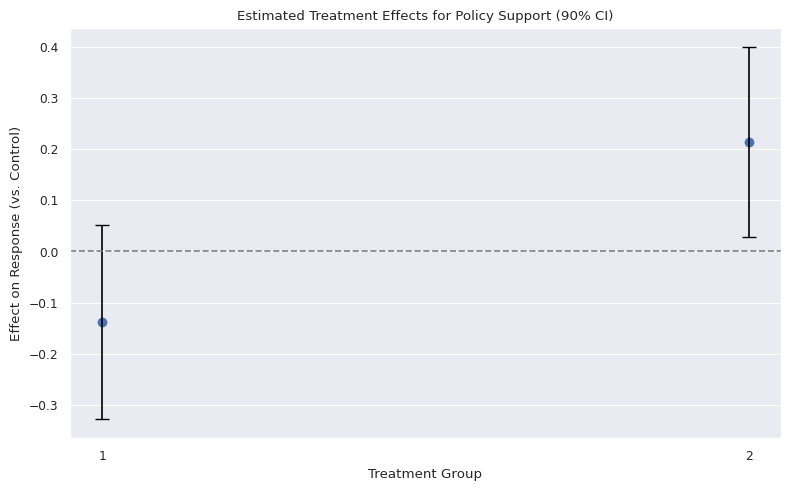

In [120]:
# 2. Extract treatment coefficients and 90% CIs
coefs = model032.params.filter(like='C(Treatment)')
ci90  = model032.conf_int(alpha=0.10).loc[coefs.index]

# 3. Build DataFrame of effects
effects_df = pd.DataFrame({
    'Effect': coefs.values,
    'Lower':  ci90[0].values,
    'Upper':  ci90[1].values,
    'Term':   coefs.index
})
effects_df['Treatment'] = (
    effects_df['Term']
      .str.extract(r'\[T\.(\d+)\]')[0]
      .fillna('0')
      .astype(str)
)

# 4. Plot with 90% CIs
plt.figure(figsize=(8, 5))
sns.pointplot(data=effects_df, x='Treatment', y='Effect', join=False)

plt.errorbar(
    x=effects_df['Treatment'],
    y=effects_df['Effect'],
    yerr=[
        effects_df['Effect'] - effects_df['Lower'],
        effects_df['Upper']  - effects_df['Effect']
    ],
    fmt='none', capsize=5, color='black'
)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Estimated Treatment Effects for Policy Support (90% CI)')
plt.xlabel('Treatment Group')
plt.ylabel('Effect on Response (vs. Control)')
plt.tight_layout()
plt.savefig('PolicySupport_Treatment.png', dpi = 300)
plt.show()

In [121]:
formula033_low = 'Response ~ C(Treatment)*RightsVersusGov'
model033_low = statf.ols(formula033_low,
                     data = long_df_Q3).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model033_low.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.115
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           0.000137
Time:                        15:08:01   Log-Likelihood:                -3307.2
No. Observations:                1569   AIC:                             6626.
Df Residuals:                    1563   BIC:                             6659.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [122]:
check_heteroskedasticity_autocorrelation(model033_low, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(10.236720728890198),
  'LM p-value': np.float64(0.06879908552647909),
  'F stat': np.float64(2.052908829971556),
  'F p-value': np.float64(0.06869291936319671)},
 'Breusch-Godfrey': {'LM stat': np.float64(43.18470055436884),
  'LM p-value': np.float64(4.1933530007495634e-10),
  'F stat': 22.049318043471416,
  'F p-value': 3.604698328889342e-10}}

In [123]:
formula033 = 'Response ~ C(Treatment)*RightsVersusGov' + technical_controls + control_variables
model033 = statf.ols(formula033,
                     data = long_df_Q3).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2['ID']})
print(model033.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     26.32
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.12e-74
Time:                        15:08:01   Log-Likelihood:                -3104.9
No. Observations:                1569   AIC:                             6260.
Df Residuals:                    1544   BIC:                             6394.
Df Model:                          24                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [124]:
check_heteroskedasticity_autocorrelation(model033, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(82.39104181286172),
  'LM p-value': np.float64(2.519490975599663e-08),
  'F stat': np.float64(3.5654906607660846),
  'F p-value': np.float64(1.4516592768200854e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(17.735218370453047),
  'LM p-value': np.float64(0.00014087900096003812),
  'F stat': 8.814648231267858,
  'F p-value': 0.00015615816403404065}}

In [125]:
aov = anova_lm(model033, typ=2)


ss_treat = aov.loc['C(Treatment)', 'sum_sq']
ss_error = aov.loc['Residual',        'sum_sq']

eta2_treat = ss_treat / (ss_treat + ss_error)
f_effect   = np.sqrt(eta2_treat / (1 - eta2_treat))

print(f"partial η² = {eta2_treat:.4f}  →  Cohen f = {f_effect:.3f}")

partial η² = 0.0067  →  Cohen f = 0.082


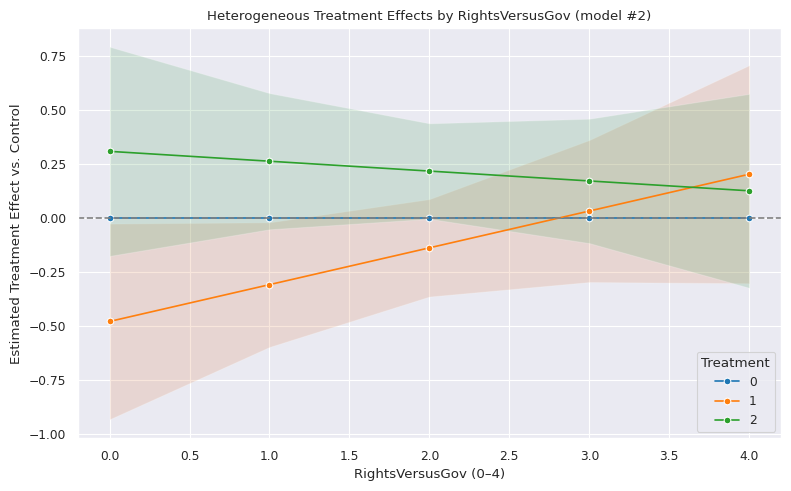

In [313]:

b    = model033.params
covb = model033.cov_params()


all_treats = sorted(long_df_Q3['Treatment'].unique())
mods       = sorted(long_df_Q3['RightsVersusGov'].unique())


rows = []
for t in all_treats:
    if t == 0:

        for m in mods:
            rows.append({
                'Treatment': '0',
                'RightsVersusGov': m,
                'Effect': 0.0,
                'Lower':  0.0,
                'Upper':  0.0
            })
    else:
        main = f"C(Treatment)[T.{t}]"
        inter= f"C(Treatment)[T.{t}]:RightsVersusGov"
        β_main = b.get(main, 0.0)
        β_int  = b.get(inter, 0.0)
        for m in mods:

            eff = β_main + β_int * m


            v_main = covb.loc[main, main]
            v_int  = covb.loc[inter, inter]   if inter in covb.index else 0.0
            cov_mi = covb.loc[main, inter]   if inter in covb.index else 0.0
            var_eff = v_main + (m**2)*v_int + 2*m*cov_mi
            se_eff  = np.sqrt(var_eff)


            lo, hi = eff - 1.96*se_eff, eff + 1.96*se_eff

            rows.append({
                'Treatment': str(t),
                'RightsVersusGov': m,
                'Effect': eff,
                'Lower':  lo,
                'Upper':  hi
            })

effects_df = pd.DataFrame(rows)


plt.figure(figsize=(8,5))
sns.lineplot(data=effects_df,
             x='RightsVersusGov',
             y='Effect',
             hue='Treatment',
             marker='o',
             palette='tab10')


for tr in effects_df['Treatment'].unique():
    sub = effects_df[effects_df['Treatment']==tr]
    plt.fill_between(sub['RightsVersusGov'],
                     sub['Lower'], sub['Upper'],
                     alpha=0.2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Heterogeneous Treatment Effects by RightsVersusGov (model #2)')
plt.xlabel('RightsVersusGov (0–4)')
plt.ylabel('Estimated Treatment Effect vs. Control')
plt.legend(title='Treatment')
plt.tight_layout()
plt.savefig("PolicySupport_HTE_1.png", dpi = 300)
plt.show()

In [127]:
formula034 = 'Response ~ C(Treatment)*RightsVersusGov' + technical_controls + control_variables
model034 = statf.ols(formula034,
                     data = long_df_Q3).fit(cov_type="HAC", cov_kwds={'maxlags': 2})
print(model034.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     27.38
Date:                Tue, 10 Jun 2025   Prob (F-statistic):          3.58e-101
Time:                        15:08:03   Log-Likelihood:                -3104.9
No. Observations:                1569   AIC:                             6260.
Df Residuals:                    1544   BIC:                             6394.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [128]:
check_heteroskedasticity_autocorrelation(model034, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(82.39104181286172),
  'LM p-value': np.float64(2.519490975599663e-08),
  'F stat': np.float64(3.5654906607660846),
  'F p-value': np.float64(1.4516592768200854e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(17.735218370453047),
  'LM p-value': np.float64(0.00014087900096003812),
  'F stat': 8.814648231267858,
  'F p-value': 0.00015615816403404065}}

In [129]:
long_df_Q3_short = long_df_Q3[long_df_Q3['Tseen'] == 0]
formula035 = 'Response ~ C(Treatment)*RightsVersusGov' + '+ C(Bill) + C(Position) +' + control_variables
model035 = statf.ols(formula035,
                     data = long_df_Q3_short).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q2_short['ID']})
print(model035.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     23.90
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           7.00e-67
Time:                        15:08:03   Log-Likelihood:                -2397.8
No. Observations:                1212   AIC:                             4844.
Df Residuals:                    1188   BIC:                             4966.
Df Model:                          23                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [130]:
check_heteroskedasticity_autocorrelation(model035, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(75.64736884984447),
  'LM p-value': np.float64(1.5851061171375475e-07),
  'F stat': np.float64(3.4385022261456837),
  'F p-value': np.float64(8.844619122112738e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(7.347511587019019),
  'LM p-value': np.float64(0.025380965046817437),
  'F stat': 3.6168724283650473,
  'F p-value': 0.02716334247169073}}

In [131]:

aov = anova_lm(model035, typ=2)


ss_treat = aov.loc['C(Treatment)', 'sum_sq']
ss_error = aov.loc['Residual',        'sum_sq']

eta2_treat = ss_treat / (ss_treat + ss_error)
f_effect   = np.sqrt(eta2_treat / (1 - eta2_treat))

print(f"partial η² = {eta2_treat:.4f}  →  Cohen f = {f_effect:.3f}")

partial η² = 0.0075  →  Cohen f = 0.087


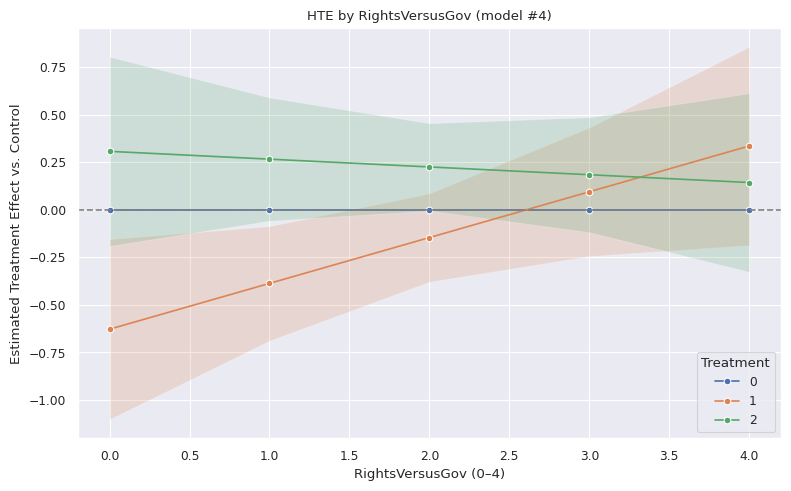

In [314]:

b035    = model035.params
covb035 = model035.cov_params()


treats035 = sorted(long_df_Q3['Treatment'].unique())
mods035   = sorted(long_df_Q3['RightsVersusGov'].unique())


rows035 = []
for t in treats035:
    if t == 0:

        for m in mods035:
            rows035.append({
                'Treatment': '0',
                'RightsVersusGov': m,
                'Effect': 0.0,
                'Lower':  0.0,
                'Upper':  0.0
            })
    else:
        main035 = f"C(Treatment)[T.{t}]"
        int035  = f"C(Treatment)[T.{t}]:RightsVersusGov"
        β_main  = b035.get(main035, 0.0)
        β_int   = b035.get(int035,  0.0)
        for m in mods035:

            eff = β_main + β_int * m


            v_main = covb035.loc[main035, main035]
            v_int  = covb035.loc[int035,  int035]   if int035  in covb035.index else 0.0
            cov_mi = covb035.loc[main035, int035]   if int035  in covb035.index else 0.0
            var_eff = v_main + (m**2)*v_int + 2*m*cov_mi
            se_eff  = np.sqrt(var_eff)


            lo, hi = eff - 1.96*se_eff, eff + 1.96*se_eff

            rows035.append({
                'Treatment': str(t),
                'RightsVersusGov': m,
                'Effect': eff,
                'Lower':  lo,
                'Upper':  hi
            })

effects035 = pd.DataFrame(rows035)


plt.figure(figsize=(8,5))
sns.lineplot(data=effects035,
             x='RightsVersusGov',
             y='Effect',
             hue='Treatment',
             marker='o')


for tr in effects035['Treatment'].unique():
    sub = effects035[effects035['Treatment']==tr]
    plt.fill_between(sub['RightsVersusGov'],
                     sub['Lower'], sub['Upper'],
                     alpha=0.2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('HTE by RightsVersusGov (model #4)')
plt.xlabel('RightsVersusGov (0–4)')
plt.ylabel('Estimated Treatment Effect vs. Control')
plt.legend(title='Treatment')
plt.tight_layout()
plt.savefig('PolicySupport_HTE_2.png', dpi = 300)
plt.show()

In [133]:
long_df_Q3_index = long_df_Q3.set_index(['ID', 'Position'])
formula036 = 'Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill) + Tseen' + control_variables
model036 = RandomEffects.from_formula(formula036,
                     data = long_df_Q3_index).fit()
print(model036)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2265
Estimator:              RandomEffects   R-squared (Between):              0.3335
No. Observations:                1569   R-squared (Within):               0.1598
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2401
Time:                        15:08:05   Log-likelihood                   -3013.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      20.575
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(22,1546)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             20.575
                            

In [134]:
long_df_Q3_index_sh = long_df_Q3_short.set_index(['ID', 'Position'])
formula037 = 'Response ~ 1 + C(Treatment)*RightsVersusGov' + '+ C(Bill)' + control_variables
model037 = RandomEffects.from_formula(formula037,
                     data = long_df_Q3_index_sh).fit()
print(model037)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2455
Estimator:              RandomEffects   R-squared (Between):              0.3380
No. Observations:                1212   R-squared (Within):               0.1531
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2521
Time:                        15:08:05   Log-likelihood                   -2361.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      18.439
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(21,1190)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             18.460
                            

In [135]:
formula038 = 'Response ~ C(Treatment)*RightsVersusGov' + '+ C(Bill)' + control_variables
model038 = sm.MixedLM.from_formula(formula038,
                     data = long_df_Q3_short,groups="ID").fit(reml = False)
print(model038.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Response  
No. Observations:        1212           Method:                    ML        
No. Groups:              523            Scale:                     2.8034    
Min. group size:         1              Log-Likelihood:            -2394.9724
Max. group size:         3              Converged:                 Yes       
Mean group size:         2.3                                                 
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          4.917    0.496   9.918 0.000  3.945  5.888
C(Treatment)[T.1]                 -0.602    0.245  -2.457 0.014 -1.082 -0.122
C(Treatment)[T.2]                  0.314    0.246   1.275 0.202 -0.169  0.796
C(Bill

In [136]:
formula038 = 'Response ~ C(Treatment)*RightsVersusGov' + '+ C(Bill) + Tseen' + control_variables
model038_full = sm.MixedLM.from_formula(formula038,
                     data = long_df_Q3,groups="ID").fit(reml = False)
print(model038_full.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Response  
No. Observations:        1569           Method:                    ML        
No. Groups:              523            Scale:                     2.7366    
Min. group size:         3              Log-Likelihood:            -3097.5721
Max. group size:         3              Converged:                 Yes       
Mean group size:         3.0                                                 
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          4.914    0.456  10.772 0.000  4.020  5.808
C(Treatment)[T.1]                 -0.441    0.226  -1.947 0.052 -0.884  0.003
C(Treatment)[T.2]                  0.302    0.229   1.321 0.187 -0.146  0.751
C(Bill

In [137]:
long_df_Q3_index = long_df_Q3.set_index(['ID', 'Position'])
formula039 = 'Response ~ 1 + C(Treatment)' + '+ C(Bill) + Tseen' + control_variables
model039 = RandomEffects.from_formula(formula039,
                     data = long_df_Q3_index).fit()
print(model039)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2238
Estimator:              RandomEffects   R-squared (Between):              0.3287
No. Observations:                1569   R-squared (Within):               0.1588
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2374
Time:                        15:08:07   Log-likelihood                   -3014.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.502
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(19,1549)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             23.502
                            

In [138]:
long_df_Q3_index = long_df_Q3.set_index(['ID', 'Position'])
formula0310 = 'Response ~ 1 + C(Treatment)' + '+ C(Bill)' + control_variables
model0310 = RandomEffects.from_formula(formula0310,
                     data = long_df_Q3_index_sh).fit()
print(model0310)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2404
Estimator:              RandomEffects   R-squared (Between):              0.3296
No. Observations:                1212   R-squared (Within):               0.1513
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2476
Time:                        15:08:07   Log-likelihood                   -2360.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      20.972
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(18,1193)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             20.992
                            

In [139]:
m0 = sm.MixedLM.from_formula("Response ~ 1",data = long_df_Q2,groups="ID").fit(reml = False)
print(m0.summary())
ICC = m0.cov_re/(m0.cov_re + m0.scale)
print(ICC)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Response  
No. Observations: 1569    Method:             ML        
No. Groups:       523     Scale:              915.8992  
Min. group size:  3       Log-Likelihood:     -7752.0742
Max. group size:  3       Converged:          Yes       
Mean group size:  3.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     45.555    1.069 42.624 0.000 43.460 47.650
ID Var       292.100    1.495                           

          ID
ID  0.241805


In [140]:
m0 = sm.MixedLM.from_formula("Response ~ 1",data = long_df_Q3,groups="ID").fit(reml = False)
print(m0.summary())
ICC = m0.cov_re/(m0.cov_re + m0.scale)
print(ICC)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Response  
No. Observations: 1569    Method:             ML        
No. Groups:       523     Scale:              3.2569    
Min. group size:  3       Log-Likelihood:     -3294.7060
Max. group size:  3       Converged:          Yes       
Mean group size:  3.0                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  3.374     0.060  56.440  0.000   3.257   3.491
ID Var     0.784     0.078                               

          ID
ID  0.193928


In [141]:
formula0311 = 'Response ~ C(Treatment)' + '+ C(Bill)' + control_variables
model0311 = sm.MixedLM.from_formula(formula0311,
                     data = long_df_Q3_short,groups="ID").fit(reml = False)
print(model0311.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Response  
No. Observations:    1212     Method:              ML        
No. Groups:          523      Scale:               2.8129    
Min. group size:     1        Log-Likelihood:      -2398.4120
Max. group size:     3        Converged:           Yes       
Mean group size:     2.3                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          4.838    0.453  10.677 0.000  3.950  5.726
C(Treatment)[T.1] -0.158    0.120  -1.321 0.187 -0.393  0.077
C(Treatment)[T.2]  0.204    0.120   1.699 0.089 -0.031  0.440
C(Bill)[T.2]      -1.300    0.120 -10.871 0.000 -1.534 -1.065
C(Bill)[T.3]      -0.170    0.120  -1.416 0.157 -0.405  0.065
PolTrust           0.197    0.069   2.858 0.004  0.062  0.332
PolCompetence     -0

In [142]:
formula0311 = 'Response ~ C(Treatment)' + '+ C(Bill) + Tseen' + control_variables
model0311_full = sm.MixedLM.from_formula(formula0311,
                     data = long_df_Q3,groups="ID").fit(reml = False)
print(model0311_full.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Response  
No. Observations:    1569     Method:              ML        
No. Groups:          523      Scale:               2.7398    
Min. group size:     3        Log-Likelihood:      -3100.0655
Max. group size:     3        Converged:           Yes       
Mean group size:     3.0                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          4.802    0.415  11.583 0.000  3.989  5.614
C(Treatment)[T.1] -0.138    0.114  -1.204 0.228 -0.362  0.086
C(Treatment)[T.2]  0.186    0.115   1.622 0.105 -0.039  0.411
C(Bill)[T.2]      -1.329    0.103 -12.951 0.000 -1.530 -1.128
C(Bill)[T.3]      -0.241    0.102  -2.348 0.019 -0.441 -0.040
Tseen              0.012    0.110   0.107 0.915 -0.204  0.227
PolTrust           0

In [143]:
formula040 = 'Response ~ C(Treatment)'
model040 = statf.ols(formula040,
                     data = long_df_Q4).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4['ID']})
print(model040.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.254
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0394
Time:                        15:08:10   Log-Likelihood:                -3192.2
No. Observations:                1569   AIC:                             6390.
Df Residuals:                    1566   BIC:                             6407.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6123      0.09

In [144]:
check_heteroskedasticity_autocorrelation(model040, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(1.532215582793448),
  'LM p-value': np.float64(0.46481872347288367),
  'F stat': np.float64(0.7653904043542448),
  'F p-value': np.float64(0.4653262253239637)},
 'Breusch-Godfrey': {'LM stat': np.float64(39.661263543857494),
  'LM p-value': np.float64(2.441552396368303e-09),
  'F stat': 20.619393299808973,
  'F p-value': 1.4494665453432038e-09}}

In [145]:
formula041 = 'Response ~ C(Treatment)' + '+ C(Position) + Tseen'
model041 = statf.ols(formula041,
                     data = long_df_Q4).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4['ID']})
print(model041.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.575
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.165
Time:                        15:08:10   Log-Likelihood:                -3191.5
No. Observations:                1569   AIC:                             6395.
Df Residuals:                    1563   BIC:                             6427.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.5307      0.11

In [146]:
check_heteroskedasticity_autocorrelation(model041, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(5.957770632128586),
  'LM p-value': np.float64(0.31034973511668196),
  'F stat': np.float64(1.1915219337078107),
  'F p-value': np.float64(0.31091887297092496)},
 'Breusch-Godfrey': {'LM stat': np.float64(39.831418720056796),
  'LM p-value': np.float64(2.2424218770722793e-09),
  'F stat': 20.88987562836138,
  'F p-value': 1.1141102143445276e-09}}

### Regression models for the First Manipulation Check

In [147]:
formula042 = 'Response ~ C(Treatment)' + '+ C(Position) + Tseen + C(Bill)' + control_variables
model042 = statf.ols(formula042,
                     data = long_df_Q4).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4['ID']})
print(model042.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     29.95
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           7.72e-76
Time:                        15:08:10   Log-Likelihood:                -2985.5
No. Observations:                1569   AIC:                             6015.
Df Residuals:                    1547   BIC:                             6133.
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5226      0.44

In [148]:
check_heteroskedasticity_autocorrelation(model042, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(76.9807443722264),
  'LM p-value': np.float64(2.564220191332361e-08),
  'F stat': np.float64(3.8008322037604154),
  'F p-value': np.float64(1.549060266772867e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(34.43514829668463),
  'LM p-value': np.float64(3.330447221115287e-08),
  'F stat': 17.334654856497306,
  'F p-value': 3.588220899289671e-08}}

In [149]:
long_df_Q4_short = long_df_Q4[long_df_Q4['Tseen'] == 0]
formula042_short = 'Response ~ C(Treatment)' + '+ C(Position)+ C(Bill)' + control_variables
model042_short = statf.ols(formula042_short,
                     data = long_df_Q4_short).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4_short['ID']})
print(model042_short.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     27.85
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.48e-69
Time:                        15:08:10   Log-Likelihood:                -2302.9
No. Observations:                1212   AIC:                             4648.
Df Residuals:                    1191   BIC:                             4755.
Df Model:                          20                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.7378      0.48

In [150]:
check_heteroskedasticity_autocorrelation(model042_short, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(72.97699705997123),
  'LM p-value': np.float64(5.904405823225833e-08),
  'F stat': np.float64(3.815357691375877),
  'F p-value': np.float64(3.278142776070734e-08)},
 'Breusch-Godfrey': {'LM stat': np.float64(14.491485460018676),
  'LM p-value': np.float64(0.0007132042378227063),
  'F stat': 7.19426041767289,
  'F p-value': 0.00078401824611748}}

In [151]:
long_df_Q4_index = long_df_Q4.set_index(['ID', 'Position'])
formula043 = 'Response ~ 1 + C(Treatment)' + ' + C(Bill) +  Tseen ' + control_variables
model043 = RandomEffects.from_formula(formula043,
                     data = long_df_Q4_index).fit()
print(model043)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2280
Estimator:              RandomEffects   R-squared (Between):              0.2627
No. Observations:                1569   R-squared (Within):               0.2097
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2341
Time:                        15:08:11   Log-likelihood                   -2840.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      24.072
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(19,1549)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             24.072
                            

In [152]:
long_df_Q4_index_sh = long_df_Q4_short.set_index(['ID', 'Position'])
formula043_sh = 'Response ~ 1 + C(Treatment)' + ' + C(Bill) ' + control_variables
model043_sh = RandomEffects.from_formula(formula043_sh,
                     data = long_df_Q4_index_sh).fit()
print(model043_sh)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2414
Estimator:              RandomEffects   R-squared (Between):              0.2764
No. Observations:                1212   R-squared (Within):               0.2123
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2404
Time:                        15:08:11   Log-likelihood                   -2226.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.095
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(18,1193)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             20.654
                            

### Regression models for the Second Manipulation Check

In [153]:
formula050 = 'Response ~ C(Treatment)'
model050 = statf.ols(formula050,
                     data = long_df_Q5).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4['ID']})
print(model050.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.591
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.205
Time:                        15:08:11   Log-Likelihood:                -3238.7
No. Observations:                1569   AIC:                             6483.
Df Residuals:                    1566   BIC:                             6499.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5996      0.09

In [154]:
check_heteroskedasticity_autocorrelation(model050, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(0.008690243477515125),
  'LM p-value': np.float64(0.9956643046448345),
  'F stat': np.float64(0.004336837687098023),
  'F p-value': np.float64(0.9956725647718249)},
 'Breusch-Godfrey': {'LM stat': np.float64(109.3192233590324),
  'LM p-value': np.float64(1.826552942029936e-24),
  'F stat': 58.70692927247571,
  'F p-value': 2.6069841444324356e-25}}

In [155]:
formula051 = 'Response ~ C(Treatment)' + '+ C(Position) + Tseen' + control_variables
model051 = statf.ols(formula051,
                     data = long_df_Q5).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q4['ID']})
print(model051.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     21.09
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.10e-53
Time:                        15:08:11   Log-Likelihood:                -3058.3
No. Observations:                1569   AIC:                             6157.
Df Residuals:                    1549   BIC:                             6264.
Df Model:                          19                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1025      0.45

In [156]:
check_heteroskedasticity_autocorrelation(model051, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(95.79200405733367),
  'LM p-value': np.float64(3.0730473158391357e-12),
  'F stat': np.float64(5.301063525580172),
  'F p-value': np.float64(1.1744804327194023e-12)},
 'Breusch-Godfrey': {'LM stat': np.float64(37.966930779721054),
  'LM p-value': np.float64(5.696206614619741e-09),
  'F stat': 19.18144130816865,
  'F p-value': 5.904987701287526e-09}}

In [157]:
formula052 = 'Response ~ C(Treatment)' + '+ C(Position) + Tseen + C(Bill)' + control_variables
model052 = statf.ols(formula052,
                     data = long_df_Q5).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q5['ID']})
print(model052.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     29.92
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.79e-76
Time:                        15:08:11   Log-Likelihood:                -3003.7
No. Observations:                1569   AIC:                             6051.
Df Residuals:                    1547   BIC:                             6169.
Df Model:                          21                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.5853      0.45

In [158]:
check_heteroskedasticity_autocorrelation(model052, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(98.60847708132904),
  'LM p-value': np.float64(5.081711933512715e-12),
  'F stat': np.float64(4.94028814668275),
  'F p-value': np.float64(1.898010657736555e-12)},
 'Breusch-Godfrey': {'LM stat': np.float64(53.64510140166103),
  'LM p-value': np.float64(2.244472248855254e-12),
  'F stat': 27.34728403960993,
  'F p-value': 2.131164822099607e-12}}

In [159]:
long_df_Q5_short = long_df_Q5[long_df_Q5['Tseen'] == 0]
formula052_short = 'Response ~ C(Treatment)' + ' + C(Bill) + C(Position) ' + control_variables
model052_short = statf.ols(formula052_short,
                     data = long_df_Q5_short).fit(cov_type="cluster", cov_kwds={"groups": long_df_Q5_short['ID']})
print(model052_short.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     27.37
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.36e-68
Time:                        15:08:11   Log-Likelihood:                -2317.3
No. Observations:                1212   AIC:                             4677.
Df Residuals:                    1191   BIC:                             4784.
Df Model:                          20                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3852      0.45

In [160]:
check_heteroskedasticity_autocorrelation(model052_short, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(100.30954573196408),
  'LM p-value': np.float64(1.1087171738339737e-12),
  'F stat': np.float64(5.373288423414155),
  'F p-value': np.float64(2.770523058228441e-13)},
 'Breusch-Godfrey': {'LM stat': np.float64(18.8041345892422),
  'LM p-value': np.float64(8.255322718833419e-05),
  'F stat': 9.369004986835135,
  'F p-value': 9.179559119530335e-05}}

In [161]:
long_df_Q5_index = long_df_Q5.set_index(['ID', 'Position'])
formula053 = 'Response ~ 1 + C(Treatment)' + ' + C(Bill) +  Tseen ' + control_variables
model053 = RandomEffects.from_formula(formula053,
                     data = long_df_Q5_index).fit()
print(model053)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2204
Estimator:              RandomEffects   R-squared (Between):              0.3595
No. Observations:                1569   R-squared (Within):               0.1272
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2591
Time:                        15:08:12   Log-likelihood                   -2788.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.050
Entities:                         523   P-value                           0.0000
Avg Obs:                       3.0000   Distribution:                 F(19,1549)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             23.050
                            

In [162]:
long_df_Q5_short = long_df_Q5[long_df_Q5['Tseen'] == 0]
long_df_Q5_index_sh = long_df_Q5_short.set_index(['ID', 'Position'])
formula054 = 'Response ~ 1 + C(Treatment)' + ' + C(Bill)' + control_variables
model054 = RandomEffects.from_formula(formula054,
                     data = long_df_Q5_index_sh).fit()
print(model054)

                        RandomEffects Estimation Summary                        
Dep. Variable:               Response   R-squared:                        0.2413
Estimator:              RandomEffects   R-squared (Between):              0.3500
No. Observations:                1212   R-squared (Within):               0.1183
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.2616
Time:                        15:08:12   Log-likelihood                   -2197.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.077
Entities:                         523   P-value                           0.0000
Avg Obs:                       2.3174   Distribution:                 F(18,1193)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             20.652
                            

In [163]:
keep_vars = ['C(Treatment)[T.1]', 'C(Treatment)[T.2]', 'C(Bill)[T.2]', 'C(Bill)[T.3]','RightsVersusGov',
             'C(Treatment)[T.1]:RightsVersusGov', 'C(Treatment)[T.2]:RightsVersusGov', 'Intercept']
controls_names = ['PolTrust', 'PolCompetence', 'PolInf', 'GovStrongLeader', 'GovExperts', 'GovDem',
       'Educ', 'Ecstat', 'Place', 'PolInt', 'RelImp', 'RelQuant',
       'GenderFemale', 'Age']
tech_controls = ['C(Position)[T.2]', 'C(Position)[T.3]', 'Tseen', 'C(Bill)[T.2]', 'C(Bill)[T.3]']
info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'
}
keep_vars_2 = ['C(Treatment)[T.1]',
 'C(Treatment)[T.2]',
 'RightsVersusGov',
 'C(Treatment)[T.1]:RightsVersusGov',
 'C(Treatment)[T.2]:RightsVersusGov']
keep_vars_1 = ['C(Treatment)[T.1]',
 'C(Treatment)[T.2]','C(Bill)[T.2]',
 'C(Bill)[T.3]',
 'RightsVersusGov',
 'C(Treatment)[T.1]:RightsVersusGov',
 'C(Treatment)[T.2]:RightsVersusGov',
            'Intercept']

In [164]:
summary_010_013_Q1 = summary_col([model010, model011, model012, model013],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'
})
with open('Summary_Q1(short).tex', 'w') as r:
    r.write(summary_010_013_Q1.as_latex())
summary_010_013_Q1

,(1),(2),(3),(4)
C(Treatment)[T.1],1.238,1.269,1.733,-5.595
,(2.149),(2.273),(2.218),(4.359)
C(Treatment)[T.2],2.401,2.697,2.987,-2.120
,(2.136),(2.164),(2.110),(4.260)
C(Bill)[T.2],,7.240***,7.234***,7.513***
,,(2.176),(2.189),(2.199)
C(Bill)[T.3],,1.081,1.096,1.243
,,(1.743),(1.751),(1.762)
RightsVersusGov,,,,-2.251
,,,,(1.455)


In [165]:
summary_Q2_OLS = summary_col([model020, model021, model022],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                      include_r2 = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q2_OLS.tex', 'w') as f:
    f.write(summary_Q2_OLS.as_latex())
summary_Q2_OLS

,(1),(2),(3)
C(Treatment)[T.1],-2.424,-1.810,-2.103
,(2.141),(2.114),(1.985)
C(Treatment)[T.2],5.568**,4.677**,4.626**
,(2.166),(2.082),(1.933)
C(Bill)[T.2],,-23.463***,-23.462***
,,(1.789),(1.796)
C(Bill)[T.3],,-5.006***,-5.015***
,,(1.645),(1.656)
Intercept,44.591***,55.149***,71.223***
,(1.664),(2.163),(7.849)


In [166]:
summary_Q2_OLS_add = summary_col([model027, model028, model025],
                      stars=True,
                      model_names=['(4)', '(5)', '(6)'],
                     float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q2_OLS_add.tex', 'w') as r:
    r.write(summary_Q2_OLS_add.as_latex())
summary_Q2_OLS_add

,(4),(5),(6)
C(Treatment)[T.1],-2.103,-2.103,-1.489
,(2.054),(2.023),(2.040)
C(Treatment)[T.2],4.626**,4.626**,4.198**
,(2.096),(2.041),(1.973)
C(Bill)[T.2],-23.462***,-23.462***,-22.903***
,(1.958),(1.861),(2.066)
C(Bill)[T.3],-5.015***,-5.015***,-4.046**
,(1.905),(1.777),(2.041)
Intercept,71.223***,71.223***,70.501***
,(6.971),(7.569),(7.996)


In [167]:
summary_RE_Q2 = summary_col_random_effects([model023,model026, model0210, model0210_low])
with open('summary_RE_Q2.tex', 'w') as r:
    r.write(summary_RE_Q2.as_latex())
summary_RE_Q2

,Response I,Response II,Response III,Response IIII
C(Treatment)[T.1],-1.5349,-1.4367,-5.2358,-7.0726*
,(1.9610),(2.0468),(3.8847),(4.1886)
C(Treatment)[T.2],3.9051**,3.9170*,6.0261,5.2986
,(1.9652),(2.0556),(3.9308),(4.2123)
C(Bill)[T.2],-23.5050***,-23.0084***,-23.3553***,-22.8307***
,(1.7180),(2.0287),(1.7247),(2.0400)
C(Bill)[T.3],-5.0039***,-4.2465**,-5.0140***,-4.2772**
,(1.7156),(2.0374),(1.7193),(2.0476)
RightsVersusGov,,,-0.6969,-0.8569
,,,(1.3795),(1.3594)


In [168]:
# For ME-models tables were manually rewritten in latex
summary_ME_Q2 = summary_col_mixedlm([model024, model024_low, model0211, model0211_low])
with open('summary_ME_Q2.tex', 'w') as r:
    r.write(summary_ME_Q2.as_latex())
summary_ME_Q2

,Response I,Response II,Response III,Response IIII
Intercept,70.6259***,69.9912***,72.6380***,72.0773***
,(7.6678),(8.0587),(8.3953),(8.7978)
C(Treatment)[T.1],-1.5354,-1.4444,-5.2282,-6.9428*
,(1.9495),(2.0251),(3.8666),(4.1427)
C(Treatment)[T.2],3.9059**,3.8844*,6.0272,5.3242
,(1.9551),(2.0356),(3.9016),(4.1564)
C(Bill)[T.2],-23.5049***,-23.0180***,-23.3557***,-22.8493***
,(1.7072),(2.0037),(1.7116),(2.0095)
C(Bill)[T.3],-5.0039***,-4.2647**,-5.0141***,-4.3047**
,(1.7048),(2.0126),(1.7061),(2.0172)


In [169]:
summary_Q2_OLS_HTE = summary_col([model029, model029_high],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q2_OLS_HTE.tex', 'w') as r:
    r.write(summary_Q2_OLS_HTE.as_latex())
summary_Q2_OLS_HTE

,(1),(2)
C(Treatment)[T.1],-10.084**,-7.594*
,(4.378),(4.001)
C(Treatment)[T.2],5.270,5.698
,(4.360),(3.979)
C(Bill)[T.2],,-23.243***
,,(1.829)
C(Bill)[T.3],,-4.993***
,,(1.672)
RightsVersusGov,-4.240***,-1.207
,(1.502),(1.437)


In [170]:
summary_Q3_OLS = summary_col([model030, model031, model032],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                     include_r2 = False,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q3_OLS.tex', 'w') as r:
    r.write(summary_Q3_OLS.as_latex())
summary_Q3_OLS

,(1),(2),(3)
C(Treatment)[T.1],-0.153,-0.116,-0.139
,(0.123),(0.124),(0.115)
C(Treatment)[T.2],0.268**,0.212*,0.215*
,(0.128),(0.123),(0.113)
C(Bill)[T.2],,-1.327***,-1.326***
,,(0.103),(0.104)
C(Bill)[T.3],,-0.238**,-0.239**
,,(0.105),(0.105)
Intercept,3.341***,3.816***,4.733***
,(0.097),(0.130),(0.450)


In [171]:
summary_Q3_HTE = summary_col([model033_low, model033, model034, model035],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars,
                      drop_omitted = True,
                      include_r2 = False,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q3_HTE.tex', 'w') as r:
    r.write(summary_Q3_HTE.as_latex())
summary_Q3_HTE

,(1),(2),(3),(4)
C(Treatment)[T.1],-0.655**,-0.479**,-0.479**,-0.628***
,(0.259),(0.231),(0.233),(0.242)
C(Treatment)[T.2],0.281,0.308,0.308,0.307
,(0.277),(0.247),(0.239),(0.254)
C(Bill)[T.2],,-1.313***,-1.313***,-1.288***
,,(0.105),(0.105),(0.120)
C(Bill)[T.3],,-0.238**,-0.238**,-0.174
,,(0.106),(0.107),(0.128)
RightsVersusGov,-0.240***,-0.052,-0.052,-0.050
,(0.090),(0.080),(0.082),(0.080)


In [172]:
summary_Q3_RE = summary_col_random_effects([model039, model0310, model036, model037])
with open('summary_Q3_RE.tex', 'w') as r:
    r.write(summary_Q3_RE.as_latex())
summary_Q3_RE

,Response I,Response II,Response III,Response IIII
C(Treatment)[T.1],-0.1371,-0.1589,-0.4382*,-0.6173**
,(0.1150),(0.1213),(0.2273),(0.2484)
C(Treatment)[T.2],0.1857,0.2069*,0.3027,0.3087
,(0.1154),(0.1219),(0.2304),(0.2499)
C(Bill)[T.2],-1.3288***,-1.3008***,-1.3167***,-1.2868***
,(0.1031),(0.1216),(0.1034),(0.1221)
C(Bill)[T.3],-0.2406**,-0.1714,-0.2405**,-0.1738
,(0.1029),(0.1222),(0.1031),(0.1226)
RightsVersusGov,,,-0.0417,-0.0421
,,,(0.0782),(0.0778)


In [173]:
summary_ME_Q3 = summary_col_mixedlm([model0311_full, model0311,model038_full, model038,])
with open('summary_ME_Q3.tex', 'w') as r:
    r.write(summary_ME_Q3.as_latex())
summary_ME_Q3

,Response I,Response II,Response III,Response IIII
Intercept,4.8019***,4.8381***,4.9137***,4.9167***
,(0.4146),(0.4532),(0.4562),(0.4957)
C(Treatment)[T.1],-0.1378,-0.1581,-0.4407*,-0.6022**
,(0.1144),(0.1197),(0.2263),(0.2451)
C(Treatment)[T.2],0.1862,0.2045*,0.3022,0.3135
,(0.1148),(0.1204),(0.2289),(0.2460)
C(Bill)[T.2],-1.3287***,-1.2996***,-1.3166***,-1.2859***
,(0.1026),(0.1195),(0.1028),(0.1197)
C(Bill)[T.3],-0.2406**,-0.1700,-0.2405**,-0.1725
,(0.1025),(0.1201),(0.1025),(0.1202)


In [174]:
keep_vars_4 = ['C(Treatment)[T.1]',
 'C(Treatment)[T.2]', 'Intercept']
summary_Q4 = summary_col([model040, model041, model042, model042_short],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars_4,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q4.tex', 'w') as r:
    r.write(summary_Q4.as_latex())
summary_Q4

,(1),(2),(3),(4)
C(Treatment)[T.1],0.207*,0.237*,0.211**,0.230**
,(0.117),(0.123),(0.107),(0.110)
C(Treatment)[T.2],-0.066,-0.044,0.027,0.003
,(0.123),(0.124),(0.107),(0.111)
Intercept,4.612***,4.531***,2.523***,2.738***
,(0.092),(0.110),(0.445),(0.483)
R-squared,0.004,0.005,0.235,0.242
R-squared Adj.,0.003,0.002,0.224,0.229
Controls,No,No,Yes,Yes
Covariance type,cluster,cluster,cluster,cluster


In [175]:
summary_Q5 = summary_col([model050, model051, model052, model052_short],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                     regressor_order = keep_vars_4,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_Q5.tex', 'w') as r:
    r.write(summary_Q5.as_latex())
summary_Q5

,(1),(2),(3),(4)
C(Treatment)[T.1],0.014,0.013,0.035,0.020
,(0.122),(0.113),(0.109),(0.111)
C(Treatment)[T.2],0.190,0.232**,0.189*,0.214**
,(0.123),(0.112),(0.106),(0.108)
Intercept,3.600***,4.102***,4.585***,4.385***
,(0.096),(0.450),(0.450),(0.456)
R-squared,0.002,0.207,0.260,0.263
R-squared Adj.,0.001,0.197,0.250,0.251
Controls,No,Yes,Yes,Yes
Covariance type,cluster,cluster,cluster,cluster


In [176]:
summary_Q4_RE = summary_col_random_effects([model043, model043_sh])
summary_Q5_RE = summary_col_random_effects([model053, model054])
with open('summary_Q4_RE.tex', 'w') as r:
    r.write(summary_Q4_RE.as_latex())
with open('summary_Q5_RE.tex', 'w') as r:
    r.write(summary_Q5_RE.as_latex())
summary_Q4_RE

,Response I,Response II
C(Treatment)[T.1],0.1891*,0.2166**
,(0.1047),(0.1101)
C(Treatment)[T.2],0.0279,-0.0028
,(0.1050),(0.1106)
C(Bill)[T.2],1.2374***,1.2149***
,(0.0922),(0.1094)
C(Bill)[T.3],-0.1346,-0.1731
,(0.0921),(0.1099)
Intercept,2.5985***,2.8131***
,(0.4035),(0.4265)


In [177]:
summary_Q5_RE

,Response I,Response II
C(Treatment)[T.1],0.0612,0.0323
,(0.1032),(0.1092)
C(Treatment)[T.2],0.1837*,0.2172**
,(0.1034),(0.1096)
C(Bill)[T.2],-1.0533***,-1.0262***
,(0.0893),(0.1076)
C(Bill)[T.3],-0.3141***,-0.2861***
,(0.0892),(0.1080)
Intercept,4.5162***,4.3324***
,(0.4277),(0.4456)


### Regression models for the First Policy Proposal

In [178]:
formula110 = 'Response ~ C(Treatment)'
model110 = model110 = statf.ols(formula110,
                     data = long_df_bill_1_Q1).fit(cov_type = 'HC3')
print(model110.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.037
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0488
Time:                        15:08:13   Log-Likelihood:                -2636.2
No. Observations:                 523   AIC:                             5278.
Df Residuals:                     520   BIC:                             5291.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            45.5417      3.22

In [179]:
check_heteroskedasticity_autocorrelation(model110, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(2.0562839060344262),
  'LM p-value': np.float64(0.3576709129113742),
  'F stat': np.float64(1.026279421465413),
  'F p-value': np.float64(0.35906234017980493)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.6073359983902546),
  'LM p-value': np.float64(0.44768384483108326),
  'F stat': 0.7984385901943263,
  'F p-value': 0.4505841573437265}}

In [180]:
formula111 = 'Response ~ C(Treatment)' + control_variables
model111 = model111 = statf.ols(formula111,
                     data = long_df_bill_1_Q1).fit(cov_type = 'HC3')
print(model111.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     7.320
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.83e-15
Time:                        15:08:13   Log-Likelihood:                -2592.1
No. Observations:                 523   AIC:                             5218.
Df Residuals:                     506   BIC:                             5291.
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            41.5948     13.18

In [181]:
check_heteroskedasticity_autocorrelation(model111, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(25.648445864978466),
  'LM p-value': np.float64(0.05917991218341044),
  'F stat': np.float64(1.630902917134017),
  'F p-value': np.float64(0.05700602848251707)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.152268237227309),
  'LM p-value': np.float64(0.34091090257381274),
  'F stat': 1.0413246764955404,
  'F p-value': 0.3537449580256339}}

In [182]:
formula112 = 'Response ~ C(Treatment)' + control_variables + '+Tseen + C(Position)'
model112 = statf.ols(formula112,
                     data = long_df_bill_1_Q1).fit(cov_type = 'HC3')
print(model112.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     6.895
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.26e-16
Time:                        15:08:13   Log-Likelihood:                -2588.8
No. Observations:                 523   AIC:                             5218.
Df Residuals:                     503   BIC:                             5303.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            37.2602     13.49

In [183]:
check_heteroskedasticity_autocorrelation(model112, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(28.463882456598412),
  'LM p-value': np.float64(0.07489898454621685),
  'F stat': np.float64(1.5237387297509044),
  'F p-value': np.float64(0.07219612337999406)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.1939113866805444),
  'LM p-value': np.float64(0.3338859894132975),
  'F stat': 1.0552388199353158,
  'F p-value': 0.3488816836966115}}

In [184]:
long_df_bill_1_Q1_short = long_df_bill_1_Q1[long_df_bill_1_Q1['Tseen'] == 0 ]
formula113 = 'Response ~ C(Treatment)' + control_variables + '+ C(Position)'
model113 = statf.ols(formula113,
                     data = long_df_bill_1_Q1_short).fit(cov_type = 'HC3')
print(model113.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5.506
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.54e-11
Time:                        15:08:13   Log-Likelihood:                -1971.5
No. Observations:                 398   AIC:                             3981.
Df Residuals:                     379   BIC:                             4057.
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            57.3417     15.68

In [185]:
check_heteroskedasticity_autocorrelation(model113, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(29.51588954610532),
  'LM p-value': np.float64(0.04242741964216618),
  'F stat': np.float64(1.686567845067018),
  'F p-value': np.float64(0.039300164343341874)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.3683079354103802),
  'LM p-value': np.float64(0.8318077224405427),
  'F stat': 0.17459887431103105,
  'F p-value': 0.839861683873976}}

In [186]:
formula114 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+Tseen + C(Position)'
model114 = statf.ols(formula114,
                     data = long_df_bill_1_Q1).fit(cov_type = 'HC3')
print(model114.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     6.281
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.77e-16
Time:                        15:08:13   Log-Likelihood:                -2586.3
No. Observations:                 523   AIC:                             5219.
Df Residuals:                     500   BIC:                             5317.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [187]:
check_heteroskedasticity_autocorrelation(model114, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(36.857820195253844),
  'LM p-value': np.float64(0.024519646317537315),
  'F stat': np.float64(1.7231126335237137),
  'F p-value': np.float64(0.02212691550850517)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.5878883534176484),
  'LM p-value': np.float64(0.27418720479533154),
  'F stat': 1.238219068273033,
  'F p-value': 0.29079098075652515}}

In [188]:
summary_B1_Q1 = summary_col([model110, model111, model112, model114],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)',],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B1_Q1.tex', 'w') as r:
    r.write(summary_B1_Q1.as_latex())
summary_B1_Q1

,(1),(2),(3),(4)
C(Treatment)[T.1],-2.760,-2.654,-2.462,-8.447
,(4.181),(4.019),(4.283),(9.121)
C(Treatment)[T.2],6.490,8.872**,8.148*,16.843*
,(4.232),(4.030),(4.263),(9.133)
RightsVersusGov,,,,1.478
,,,,(3.222)
C(Treatment)[T.1]:RightsVersusGov,,,,2.667
,,,,(4.133)
C(Treatment)[T.2]:RightsVersusGov,,,,-4.422
,,,,(3.962)


In [189]:
formula120 = 'Response ~ C(Treatment)'
model120 = model120 = statf.ols(formula120,
                     data = long_df_bill_1_Q2).fit(cov_type = 'HC3')
print(model120.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.933
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.146
Time:                        15:08:14   Log-Likelihood:                -2581.3
No. Observations:                 523   AIC:                             5169.
Df Residuals:                     520   BIC:                             5181.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            54.8819      2.92

In [190]:
check_heteroskedasticity_autocorrelation(model120, lags = 2)

{'Breusch-Pagan': {'LM stat': np.float64(2.45211604387874),
  'LM p-value': np.float64(0.29344706259147707),
  'F stat': np.float64(1.2247675786579888),
  'F p-value': np.float64(0.29467215380087836)},
 'Breusch-Godfrey': {'LM stat': np.float64(6.712540709386459),
  'LM p-value': np.float64(0.034865051029006874),
  'F stat': 3.3674032023166074,
  'F p-value': 0.03523552854729945}}

In [191]:
formula121 = 'Response ~ C(Treatment)' + control_variables
model121 = statf.ols(formula121,
                     data = long_df_bill_1_Q2).fit(cov_type = 'HC3')
print(model121.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     8.248
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           9.13e-18
Time:                        15:08:14   Log-Likelihood:                -2529.7
No. Observations:                 523   AIC:                             5093.
Df Residuals:                     506   BIC:                             5166.
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            51.3334     12.21

In [192]:
check_heteroskedasticity_autocorrelation(model121, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(34.968281057692316),
  'LM p-value': np.float64(0.004014202847408678),
  'F stat': np.float64(2.265983634928959),
  'F p-value': np.float64(0.0033974329926618656)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.6871373420462294),
  'LM p-value': np.float64(0.10116140901245366),
  'F stat': 2.608054605456513,
  'F p-value': 0.10694669389910595}}

In [193]:
formula122 = 'Response ~ C(Treatment)' + control_variables + '+C(Position) + Tseen'
model122 = statf.ols(formula122,
                     data = long_df_bill_1_Q2).fit(cov_type = 'HC3')
print(model122.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     7.393
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.56e-18
Time:                        15:08:14   Log-Likelihood:                -2528.1
No. Observations:                 523   AIC:                             5096.
Df Residuals:                     503   BIC:                             5181.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            50.9032     12.55

In [194]:
check_heteroskedasticity_autocorrelation(model122, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(37.64014648369765),
  'LM p-value': np.float64(0.006592377338973481),
  'F stat': np.float64(2.0530609287689985),
  'F p-value': np.float64(0.005599318936058711)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.965058827728845),
  'LM p-value': np.float64(0.08508136311840378),
  'F stat': 2.862229849718601,
  'F p-value': 0.09130229531111939}}

In [195]:
formula123 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position) + Tseen'
model123 = statf.ols(formula123,
                     data = long_df_bill_1_Q2).fit(cov_type = 'HC3')
print(model123.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     7.310
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.43e-19
Time:                        15:08:14   Log-Likelihood:                -2522.8
No. Observations:                 523   AIC:                             5092.
Df Residuals:                     500   BIC:                             5190.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [196]:
check_heteroskedasticity_autocorrelation(model123, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(38.566672842556706),
  'LM p-value': np.float64(0.015812788540818974),
  'F stat': np.float64(1.8093620788220803),
  'F p-value': np.float64(0.013894115745056343)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.944790925690965),
  'LM p-value': np.float64(0.04701669586291107),
  'F stat': 3.7923724442153315,
  'F p-value': 0.05204714168227692}}

In [197]:
long_df_bill_1_Q2_short = long_df_bill_1_Q2[long_df_bill_1_Q2['Tseen'] == 0]
formula124 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position)'
model124 = statf.ols(formula124,
                     data = long_df_bill_1_Q2_short).fit(cov_type = 'HC3')
print(model124.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.354
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.09e-12
Time:                        15:08:14   Log-Likelihood:                -1916.4
No. Observations:                 398   AIC:                             3877.
Df Residuals:                     376   BIC:                             3965.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [198]:
check_heteroskedasticity_autocorrelation(model124, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(46.60131468009369),
  'LM p-value': np.float64(0.0010622858434141376),
  'F stat': np.float64(2.3744694520878915),
  'F p-value': np.float64(0.0006901578731699032)},
 'Breusch-Godfrey': {'LM stat': np.float64(5.512184820460524),
  'LM p-value': np.float64(0.018884442749411506),
  'F stat': 5.266582114726534,
  'F p-value': 0.022290299209379624}}

In [199]:
summary_B1_Q2 = summary_col([model120, model121, model122, model124],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)',],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B1_Q2.tex', 'w') as r:
    r.write(summary_B1_Q2.as_latex())
summary_B1_Q2

,(1),(2),(3),(4)
C(Treatment)[T.1],-2.972,-2.815,-2.789,-6.628
,(3.755),(3.694),(3.791),(8.435)
C(Treatment)[T.2],3.767,5.792,5.691,15.274*
,(3.838),(3.711),(3.911),(8.468)
RightsVersusGov,,,,-2.886
,,,,(3.277)
C(Treatment)[T.1]:RightsVersusGov,,,,2.277
,,,,(4.249)
C(Treatment)[T.2]:RightsVersusGov,,,,-4.587
,,,,(3.979)


In [200]:
formula130 = 'Response ~ C(Treatment)'
model130 =  statf.ols(formula130,
                     data = long_df_bill_1_Q3).fit(cov_type = 'HC3')
print(model130.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.343
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0970
Time:                        15:08:14   Log-Likelihood:                -1126.6
No. Observations:                 523   AIC:                             2259.
Df Residuals:                     520   BIC:                             2272.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.8958      0.18

In [201]:
check_heteroskedasticity_autocorrelation(model130, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(2.34291054033277),
  'LM p-value': np.float64(0.3099156020051637),
  'F stat': np.float64(1.1699768481376163),
  'F p-value': np.float64(0.3111897815682823)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.8316002982785633),
  'LM p-value': np.float64(0.3618101939207704),
  'F stat': 0.826554335829375,
  'F p-value': 0.3636927644155601}}

In [202]:
formula131 = 'Response ~ C(Treatment)' + control_variables
model131 =  statf.ols(formula131,
                     data = long_df_bill_1_Q3).fit(cov_type = 'HC3')
print(model131.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     11.40
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.14e-25
Time:                        15:08:14   Log-Likelihood:                -1067.1
No. Observations:                 523   AIC:                             2168.
Df Residuals:                     506   BIC:                             2241.
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9693      0.68

In [203]:
check_heteroskedasticity_autocorrelation(model131, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(29.22123355816777),
  'LM p-value': np.float64(0.022486338394990243),
  'F stat': np.float64(1.8715294663970077),
  'F p-value': np.float64(0.0208264050182007)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.6362785912859857),
  'LM p-value': np.float64(0.42506159459436355),
  'F stat': 0.6151282629907012,
  'F p-value': 0.43323116458029165}}

In [204]:
formula132 = 'Response ~ C(Treatment)' + control_variables + '+ C(Position) + Tseen'
model132 =  statf.ols(formula132,
                     data = long_df_bill_1_Q3).fit(cov_type = 'HC3')
print(model132.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     10.07
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.90e-25
Time:                        15:08:14   Log-Likelihood:                -1064.9
No. Observations:                 523   AIC:                             2170.
Df Residuals:                     503   BIC:                             2255.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9217      0.70

In [205]:
check_heteroskedasticity_autocorrelation(model132, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(31.724922717971996),
  'LM p-value': np.float64(0.03355691698745441),
  'F stat': np.float64(1.7095831327034567),
  'F p-value': np.float64(0.03122494599258034)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.8712124778066362),
  'LM p-value': np.float64(0.3506198621267912),
  'F stat': 0.8376260308005403,
  'F p-value': 0.360516018518501}}

In [206]:
formula133 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+ C(Position) + Tseen'
model133 =  statf.ols(formula133,
                     data = long_df_bill_1_Q3).fit(cov_type = 'HC3')
print(model133.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     9.701
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           5.26e-27
Time:                        15:08:15   Log-Likelihood:                -1060.6
No. Observations:                 523   AIC:                             2167.
Df Residuals:                     500   BIC:                             2265.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [207]:
check_heteroskedasticity_autocorrelation(model133, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(41.801187878255135),
  'LM p-value': np.float64(0.006606555976975945),
  'F stat': np.float64(1.9742920666078287),
  'F p-value': np.float64(0.005473604998693576)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.1553998726686372),
  'LM p-value': np.float64(0.2824216134080363),
  'F stat': 1.104820355180374,
  'F p-value': 0.2937194195804467}}

In [208]:
long_df_bill_1_Q3_short = long_df_bill_1_Q3[long_df_bill_1_Q3['Tseen'] == 0]
formula134 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+ C(Position)'
model134 =  statf.ols(formula134,
                     data = long_df_bill_1_Q3_short).fit(cov_type = 'HC3')
print(model134.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     7.493
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.38e-18
Time:                        15:08:15   Log-Likelihood:                -809.19
No. Observations:                 398   AIC:                             1662.
Df Residuals:                     376   BIC:                             1750.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [209]:
check_heteroskedasticity_autocorrelation(model134, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(38.645246146417186),
  'LM p-value': np.float64(0.010817609787375119),
  'F stat': np.float64(1.9254898497445287),
  'F p-value': np.float64(0.008880797637958817)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.9240881009001245),
  'LM p-value': np.float64(0.0872665164310197),
  'F stat': 2.775499606054363,
  'F p-value': 0.09655184078527597}}

In [210]:
summary_B1_Q3 = summary_col([model130, model131, model132, model133],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)',],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B1_Q3.tex', 'w') as r:
    r.write(summary_B1_Q3.as_latex())
summary_B1_Q3

,(1),(2),(3),(4)
C(Treatment)[T.1],-0.220,-0.194,-0.195,-0.040
,(0.233),(0.219),(0.229),(0.499)
C(Treatment)[T.2],0.240,0.383*,0.369,1.053**
,(0.237),(0.223),(0.236),(0.497)
RightsVersusGov,,,,-0.031
,,,,(0.184)
C(Treatment)[T.1]:RightsVersusGov,,,,-0.063
,,,,(0.230)
C(Treatment)[T.2]:RightsVersusGov,,,,-0.328
,,,,(0.220)


In [211]:
formula140 = 'Response ~ C(Treatment)'
model140 =  statf.ols(formula140,
                     data = long_df_bill_1_Q4).fit(cov_type = 'HC3')
print(model140.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9532
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.386
Time:                        15:08:15   Log-Likelihood:                -1077.0
No. Observations:                 523   AIC:                             2160.
Df Residuals:                     520   BIC:                             2173.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1111      0.16

In [212]:
check_heteroskedasticity_autocorrelation(model140, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.8101471877603401),
  'LM p-value': np.float64(0.6669277272531285),
  'F stat': np.float64(0.40337487923846926),
  'F p-value': np.float64(0.668270467338375)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.13192549550378996),
  'LM p-value': np.float64(0.7164439138812768),
  'F stat': 0.13094953680508728,
  'F p-value': 0.7175968353527226}}

In [213]:
long_df_bill_1_Q4

,ID,Bill,Treatment,Position,Tseen,Question,Response,Var,PolCompetence,PolTrust,...,GovDem,RightsVersusGov,Educ,Ecstat,Place,PolInt,RelImp,RelQuant,GenderFemale,Age
4708,94,1,1,2,0,Q4,5,5,0.00,3.000000,...,2,2,2,1,3,0,3,6,1,22
4712,95,1,2,3,0,Q4,2,6,1.75,3.000000,...,3,3,1,2,3,3,1,6,1,41
4713,96,1,2,1,0,Q4,5,1,2.00,0.000000,...,3,4,4,0,0,4,1,4,0,36
4716,97,1,1,1,0,Q4,4,2,1.00,3.000000,...,2,2,4,1,1,1,2,5,1,32
4720,98,1,0,2,0,Q4,2,3,2.00,2.666667,...,4,1,2,2,3,3,1,4,0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6261,864,1,1,1,0,Q4,5,1,3.75,3.666667,...,4,3,4,4,0,4,1,3,1,31
6264,865,1,2,1,0,Q4,2,2,2.00,3.000000,...,2,2,1,2,3,2,2,5,0,37
6268,868,1,1,2,0,Q4,4,5,2.00,0.666667,...,1,1,1,2,1,3,2,6,0,25
6272,869,1,0,3,0,Q4,1,6,1.75,3.333333,...,3,0,3,3,2,3,2,3,1,31


In [214]:
formula141 = 'Response ~ C(Treatment)' + control_variables + ' + C(Position) + Tseen'
model141 =  statf.ols(formula141,
                     data = long_df_bill_1_Q4).fit(cov_type = 'HC3')
print(model141.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     8.603
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.32e-21
Time:                        15:08:15   Log-Likelihood:                -1019.2
No. Observations:                 523   AIC:                             2078.
Df Residuals:                     503   BIC:                             2164.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.9984      0.68

In [215]:
summary_B1_Q4 = summary_col([model140, model141],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B1_Q4.tex', 'w') as r:
    r.write(summary_B1_Q4.as_latex())
summary_B1_Q4

,(1),(2)
C(Treatment)[T.1],0.272,0.286
,(0.211),(0.209)
C(Treatment)[T.2],0.245,0.189
,(0.214),(0.218)
Intercept,4.111***,3.998***
,(0.161),(0.684)
R-squared,0.004,0.201
R-squared Adj.,-0.000,0.171
Controls,No,Yes
Covariance type,HC3,HC3


In [216]:
check_heteroskedasticity_autocorrelation(model141, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(57.33843654140596),
  'LM p-value': np.float64(1.0122814181678551e-05),
  'F stat': np.float64(3.259791619579223),
  'F p-value': np.float64(4.841785878619308e-06)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.110138076812335),
  'LM p-value': np.float64(0.739986992071143),
  'F stat': 0.10573797387545042,
  'F p-value': 0.7451850443334853}}

In [217]:
formula150 = 'Response ~ C(Treatment)'
model150 =  statf.ols(formula150,
                     data = long_df_bill_1_Q5).fit(cov_type = 'HC3')
print(model150.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.04928
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.952
Time:                        15:08:15   Log-Likelihood:                -1116.6
No. Observations:                 523   AIC:                             2239.
Df Residuals:                     520   BIC:                             2252.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0903      0.17

In [218]:
check_heteroskedasticity_autocorrelation(model150, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(2.2666476824194994),
  'LM p-value': np.float64(0.3219613276198824),
  'F stat': np.float64(1.1317277735451303),
  'F p-value': np.float64(0.3232685729622037)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.315340899680439),
  'LM p-value': np.float64(0.25142992839859757),
  'F stat': 1.3085719793093018,
  'F p-value': 0.25318069417098754}}

In [219]:
formula151 = 'Response ~ C(Treatment)' + control_variables + ' + C(Position) + Tseen'
model151 =  statf.ols(formula151,
                     data = long_df_bill_1_Q5).fit(cov_type = 'HC3')
print(model151.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     14.45
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.02e-36
Time:                        15:08:16   Log-Likelihood:                -1035.6
No. Observations:                 523   AIC:                             2111.
Df Residuals:                     503   BIC:                             2196.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4411      0.66

In [220]:
summary_B1_Q5 = summary_col([model150, model151],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B1_Q5.tex', 'w') as r:
    r.write(summary_B1_Q5.as_latex())
summary_B1_Q5

,(1),(2)
C(Treatment)[T.1],0.032,0.139
,(0.227),(0.218)
C(Treatment)[T.2],0.072,0.315
,(0.232),(0.226)
Intercept,4.090***,3.441***
,(0.175),(0.668)
R-squared,0.000,0.266
R-squared Adj.,-0.004,0.239
Controls,No,Yes
Covariance type,HC3,HC3


In [221]:
check_heteroskedasticity_autocorrelation(model151, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(40.25767065726474),
  'LM p-value': np.float64(0.003026690584242),
  'F stat': np.float64(2.2077385703525656),
  'F p-value': np.float64(0.002440606864584111)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.346889090768224),
  'LM p-value': np.float64(0.24582270726582367),
  'F stat': 1.2961454833214654,
  'F p-value': 0.25546151930153116}}

### Regression models for the Second Policy Proposal

In [222]:
formula210 = 'Response ~ C(Treatment)'
model210 =  statf.ols(formula210,
                     data = long_df_bill_2_Q1).fit(cov_type = 'HC3')
print(model210.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7062
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.494
Time:                        15:08:16   Log-Likelihood:                -2626.3
No. Observations:                 523   AIC:                             5259.
Df Residuals:                     520   BIC:                             5271.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            53.5597      2.89

In [223]:
check_heteroskedasticity_autocorrelation(model210, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.25288887431543694),
  'LM p-value': np.float64(0.8812231114440279),
  'F stat': np.float64(0.1257799534853862),
  'F p-value': np.float64(0.8818356845126113)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.3969992114070187),
  'LM p-value': np.float64(0.12156824619712946),
  'F stat': 2.3896185554745735,
  'F p-value': 0.12275294404365311}}

In [224]:
formula211 = 'Response ~ C(Treatment)' + control_variables + '+C(Position) + Tseen'
model211 =  statf.ols(formula211,
                     data = long_df_bill_2_Q1).fit(cov_type = 'HC3')
print(model211.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.248
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.64e-09
Time:                        15:08:16   Log-Likelihood:                -2592.7
No. Observations:                 523   AIC:                             5225.
Df Residuals:                     503   BIC:                             5311.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            64.8865     12.96

In [225]:
check_heteroskedasticity_autocorrelation(model211, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(51.04870037313204),
  'LM p-value': np.float64(9.171447928125923e-05),
  'F stat': np.float64(2.863530991660687),
  'F p-value': np.float64(5.521885931373703e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.0094017383060363),
  'LM p-value': np.float64(0.0827828396756481),
  'F stat': 2.905282667955605,
  'F p-value': 0.08890853055912533}}

In [226]:
formula212 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position) + Tseen'
model212 =  statf.ols(formula212,
                     data = long_df_bill_2_Q1).fit(cov_type = 'HC3')
print(model212.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     3.942
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.98e-09
Time:                        15:08:16   Log-Likelihood:                -2590.7
No. Observations:                 523   AIC:                             5227.
Df Residuals:                     500   BIC:                             5325.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [227]:
check_heteroskedasticity_autocorrelation(model212, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(55.60295420886935),
  'LM p-value': np.float64(9.745645125930063e-05),
  'F stat': np.float64(2.7037045187310653),
  'F p-value': np.float64(5.535580114547409e-05)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.5693867696281503),
  'LM p-value': np.float64(0.10894995897468195),
  'F stat': 2.4635829742725357,
  'F p-value': 0.11714659457931594}}

In [228]:
formula212_fem = 'Response ~ C(Treatment)*GenderFemale' + control_variables + '+C(Position) + Tseen'
model212_fem =  statf.ols(formula212_fem,
                     data = long_df_bill_2_Q1).fit(cov_type = 'HC3')
print(model212_fem.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     4.134
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           4.43e-09
Time:                        15:08:17   Log-Likelihood:                -2590.8
No. Observations:                 523   AIC:                             5226.
Df Residuals:                     501   BIC:                             5319.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [229]:
summary_B2_Q1 = summary_col([model210, model211, model212],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B2_Q1.tex', 'w') as r:
    r.write(summary_B2_Q1.as_latex())
summary_B2_Q1

,(1),(2),(3)
C(Treatment)[T.1],2.469,3.309,-3.327
,(3.858),(4.144),(8.055)
C(Treatment)[T.2],-2.177,-2.621,-17.142*
,(4.164),(4.281),(9.632)
RightsVersusGov,,,-2.687
,,,(2.736)
C(Treatment)[T.1]:RightsVersusGov,,,3.318
,,,(3.555)
C(Treatment)[T.2]:RightsVersusGov,,,7.055*
,,,(4.087)


In [230]:
formula220 = 'Response ~ C(Treatment)'
model220 =  statf.ols(formula220,
                     data = long_df_bill_2_Q2).fit(cov_type = 'HC3')
print(model220.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.658
Date:                Tue, 10 Jun 2025   Prob (F-statistic):             0.0264
Time:                        15:08:17   Log-Likelihood:                -2591.1
No. Observations:                 523   AIC:                             5188.
Df Residuals:                     520   BIC:                             5201.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            31.4214      2.69

In [231]:
check_heteroskedasticity_autocorrelation(model220, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(1.6183719501072886),
  'LM p-value': np.float64(0.4452203392160565),
  'F stat': np.float64(0.807041683846261),
  'F p-value': np.float64(0.44673408995735076)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.184200108449641),
  'LM p-value': np.float64(0.27650259273763356),
  'F stat': 1.1778099789489263,
  'F p-value': 0.27830613174151686}}

In [232]:
formula221 = 'Response ~ C(Treatment)' + control_variables + '+C(Position) + Tseen'
model221 =  statf.ols(formula221,
                     data = long_df_bill_2_Q2).fit(cov_type = 'HC3')
print(model221.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     9.076
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.60e-22
Time:                        15:08:17   Log-Likelihood:                -2532.0
No. Observations:                 523   AIC:                             5104.
Df Residuals:                     503   BIC:                             5189.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            75.4417     11.71

In [233]:
check_heteroskedasticity_autocorrelation(model221, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(29.723286236904865),
  'LM p-value': np.float64(0.05542737469329616),
  'F stat': np.float64(1.5952200287987195),
  'F p-value': np.float64(0.052769381402664434)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.21912533760475061),
  'LM p-value': np.float64(0.6397071768379758),
  'F stat': 0.21041496506285645,
  'F p-value': 0.6466408840605262}}

In [234]:
formula222 = 'Response ~ C(Treatment)' + control_variables + '+C(Position) + Tseen'
model222 = statf.ols(formula222,
                     data = long_df_bill_2_Q2).fit(cov_type = 'HC3')
print(model222.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     9.076
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.60e-22
Time:                        15:08:17   Log-Likelihood:                -2532.0
No. Observations:                 523   AIC:                             5104.
Df Residuals:                     503   BIC:                             5189.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            75.4417     11.71

In [235]:
check_heteroskedasticity_autocorrelation(model222, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(29.723286236904865),
  'LM p-value': np.float64(0.05542737469329616),
  'F stat': np.float64(1.5952200287987195),
  'F p-value': np.float64(0.052769381402664434)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.21912533760475061),
  'LM p-value': np.float64(0.6397071768379758),
  'F stat': 0.21041496506285645,
  'F p-value': 0.6466408840605262}}

In [236]:
formula222_fem = 'Response ~ C(Treatment)*GenderFemale' + control_variables + '+C(Position) + Tseen'
model222_fem = statf.ols(formula222_fem,
                     data = long_df_bill_2_Q2).fit(cov_type = 'HC3')
print(model222_fem.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     8.113
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.33e-21
Time:                        15:08:17   Log-Likelihood:                -2531.1
No. Observations:                 523   AIC:                             5106.
Df Residuals:                     501   BIC:                             5200.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [237]:
long_df_bill_2_Q2_short = long_df_bill_2_Q2[long_df_bill_2_Q2['Tseen'] == 0]
formula223 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + ' + C(Position)'
model223 = statf.ols(formula223,
                     data = long_df_bill_2_Q2_short).fit(cov_type = 'HC3')
print(model223.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     9.332
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           7.41e-24
Time:                        15:08:18   Log-Likelihood:                -1971.2
No. Observations:                 411   AIC:                             3986.
Df Residuals:                     389   BIC:                             4075.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [238]:
check_heteroskedasticity_autocorrelation(model223, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(25.001894267446524),
  'LM p-value': np.float64(0.2470820457648549),
  'F stat': np.float64(1.199825388432071),
  'F p-value': np.float64(0.24698336289661527)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.23559806605351208),
  'LM p-value': np.float64(0.6274036594103072),
  'F stat': 0.22254131370270952,
  'F p-value': 0.6373755194531852}}

In [239]:
summary_B2_Q2 = summary_col([model220, model221, model222, model223],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B2_Q2.tex', 'w') as r:
    r.write(summary_B2_Q2.as_latex())
summary_B2_Q2

,(1),(2),(3),(4)
C(Treatment)[T.1],-4.345,-5.678,-5.678,-14.055*
,(3.562),(3.577),(3.577),(7.356)
C(Treatment)[T.2],5.708,3.239,3.239,-8.199
,(3.965),(3.779),(3.779),(8.970)
RightsVersusGov,,,,-0.335
,,,,(2.111)
C(Treatment)[T.1]:RightsVersusGov,,,,4.961
,,,,(3.254)
C(Treatment)[T.2]:RightsVersusGov,,,,4.881
,,,,(3.700)


In [240]:
formula230 = 'Response ~ C(Treatment)'
model230 = statf.ols(formula230,
                     data = long_df_bill_2_Q3).fit(cov_type = 'HC3')
print(model230.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.397
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.248
Time:                        15:08:18   Log-Likelihood:                -1067.8
No. Observations:                 523   AIC:                             2142.
Df Residuals:                     520   BIC:                             2154.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5849      0.15

In [241]:
check_heteroskedasticity_autocorrelation(model230, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.4546564750440967),
  'LM p-value': np.float64(0.7966592459126663),
  'F stat': np.float64(0.22622091073291312),
  'F p-value': np.float64(0.7976203452375594)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.6971102544837383),
  'LM p-value': np.float64(0.4037563975295503),
  'F stat': 0.6927019344147389,
  'F p-value': 0.40562966529112365}}

In [242]:
formula231 = 'Response ~ C(Treatment)' + control_variables + '+C(Position) + Tseen'
model231 = statf.ols(formula231,
                     data = long_df_bill_2_Q3).fit(cov_type = 'HC3')
print(model231.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     12.29
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.35e-31
Time:                        15:08:18   Log-Likelihood:                -982.66
No. Observations:                 523   AIC:                             2005.
Df Residuals:                     503   BIC:                             2091.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.5989      0.64

In [243]:
check_heteroskedasticity_autocorrelation(model231, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(37.55768310653239),
  'LM p-value': np.float64(0.006752466222604765),
  'F stat': np.float64(2.0482150147193674),
  'F p-value': np.float64(0.005744015673806665)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.7917518424219457),
  'LM p-value': np.float64(0.3735709319764098),
  'F stat': 0.7611128822613381,
  'F p-value': 0.38339755304068135}}

In [244]:
formula232 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position) + Tseen'
model232 = statf.ols(formula232,
                     data = long_df_bill_2_Q3).fit(cov_type = 'HC3')
print(model232.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     10.87
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.65e-30
Time:                        15:08:18   Log-Likelihood:                -977.94
No. Observations:                 523   AIC:                             2002.
Df Residuals:                     500   BIC:                             2100.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [245]:
check_heteroskedasticity_autocorrelation(model232, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(35.751653929259305),
  'LM p-value': np.float64(0.03227915749220808),
  'F stat': np.float64(1.6676046124195174),
  'F p-value': np.float64(0.02958952924678795)},
 'Breusch-Godfrey': {'LM stat': np.float64(1.3021036254321063),
  'LM p-value': np.float64(0.2538293294866051),
  'F stat': 1.245452039592014,
  'F p-value': 0.2649600118126491}}

In [246]:
formula232_fem = 'Response ~ C(Treatment)*GenderFemale' + control_variables + '+C(Position) + Tseen'
model232_fem = statf.ols(formula232_fem,
                     data = long_df_bill_2_Q3).fit(cov_type = 'HC3')
print(model232_fem.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     11.05
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           5.04e-30
Time:                        15:08:18   Log-Likelihood:                -981.52
No. Observations:                 523   AIC:                             2007.
Df Residuals:                     501   BIC:                             2101.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [247]:
formula232 = 'Response ~ 1 + C(Treatment)*RightsVersusGov + PolTrust + PolCompetence + PolInf + GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + RelImp + RelQuant + GenderFemale + Age+C(Position) + Tseen'

In [248]:
model232_log = OrderedModel.from_formula(formula232, data=long_df_bill_2_Q4, distr='logit')
res = model232_log.fit(method='lbfgs', disp=False)
print(res.summary())

                             OrderedModel Results                             
Dep. Variable:               Response   Log-Likelihood:                -754.30
Model:                   OrderedModel   AIC:                             1565.
Method:            Maximum Likelihood   BIC:                             1684.
Date:                Tue, 10 Jun 2025                                         
Time:                        15:08:25                                         
No. Observations:                 523                                         
Df Residuals:                     495                                         
Df Model:                          22                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
C(Treatment)[T.1]                     0.0810      0.426      0.190      0.849      -0

In [249]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model232.resid, model232.model.exog)
print(f"LM stat: {bp_test[0]}, p-value: {bp_test[1]}")

LM stat: 35.751653929259305, p-value: 0.03227915749220808


In [250]:
long_df_bill_2_Q3_short = long_df_bill_2_Q3[long_df_bill_2_Q3['Tseen'] == 0]
formula233 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position) '
model233 = statf.ols(formula233,
                     data = long_df_bill_2_Q3_short).fit(cov_type = 'HC3')
print(model233.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     9.493
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.68e-24
Time:                        15:08:25   Log-Likelihood:                -763.16
No. Observations:                 411   AIC:                             1570.
Df Residuals:                     389   BIC:                             1659.
Df Model:                          21                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [251]:
check_heteroskedasticity_autocorrelation(model233, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(35.2255466297683),
  'LM p-value': np.float64(0.02666689987844568),
  'F stat': np.float64(1.7364440565069805),
  'F p-value': np.float64(0.02364252097706799)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.06170852316860742),
  'LM p-value': np.float64(0.8038156476402223),
  'F stat': 0.058263996045040185,
  'F p-value': 0.8093886171921973}}

In [252]:
summary_B2_Q3 = summary_col([model230, model231, model232, model233],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)', '(4)'],
                      float_format='%0.3f',
                      include_r2 = True,
                         regressor_order = keep_vars,
                            drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B2_Q3.tex', 'w') as r:
    r.write(summary_B2_Q3.as_latex())
summary_B2_Q3

,(1),(2),(3),(4)
C(Treatment)[T.1],-0.180,-0.319*,-0.897**,-0.819**
,(0.196),(0.189),(0.398),(0.416)
C(Treatment)[T.2],0.149,-0.006,-0.537,-0.518
,(0.215),(0.197),(0.445),(0.479)
RightsVersusGov,,,-0.037,-0.014
,,,(0.125),(0.125)
C(Treatment)[T.1]:RightsVersusGov,,,0.304*,0.264
,,,(0.173),(0.180)
C(Treatment)[T.2]:RightsVersusGov,,,0.258,0.224
,,,(0.189),(0.207)


In [253]:
formula240 = 'Response ~ C(Treatment)'
model240 = statf.ols(formula240,
                     data = long_df_bill_2_Q4).fit(cov_type = 'HAC', cov_kwds={'maxlags': 1})
print(model240.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     1.027
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.359
Time:                        15:08:25   Log-Likelihood:                -1000.4
No. Observations:                 523   AIC:                             2007.
Df Residuals:                     520   BIC:                             2020.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.5346      0.12

In [254]:
formula240 = 'Response ~ C(Treatment)'
model240 = statf.ols(formula240,
                     data = long_df_bill_2_Q4).fit(cov_type = 'HC3')
print(model240.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9880
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.373
Time:                        15:08:25   Log-Likelihood:                -1000.4
No. Observations:                 523   AIC:                             2007.
Df Residuals:                     520   BIC:                             2020.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.5346      0.13

In [255]:
check_heteroskedasticity_autocorrelation(model240, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.39051008914046803),
  'LM p-value': np.float64(0.8226248253037703),
  'F stat': np.float64(0.19428009849924693),
  'F p-value': np.float64(0.8234869729892649)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.9401041214181034),
  'LM p-value': np.float64(0.08640516306037863),
  'F stat': 2.9341121111408173,
  'F p-value': 0.0873235678414701}}

In [256]:
formula241 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model241 = statf.ols(formula241,
                     data = long_df_bill_2_Q4).fit(cov_type = 'HC3')
print(model241.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     9.789
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.73e-24
Time:                        15:08:26   Log-Likelihood:                -936.77
No. Observations:                 523   AIC:                             1914.
Df Residuals:                     503   BIC:                             1999.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.1321      0.61

In [257]:
check_heteroskedasticity_autocorrelation(model241, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(29.588125627797112),
  'LM p-value': np.float64(0.057279752544857634),
  'F stat': np.float64(1.5875310971150212),
  'F p-value': np.float64(0.054609506677925315)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.14641936977389636),
  'LM p-value': np.float64(0.7019808934605929),
  'F stat': 0.1405795548686163,
  'F p-value': 0.7078638837581718}}

In [258]:
model241_log = OrderedModel.from_formula(formula241, data=long_df_bill_2_Q4, distr='logit')
res = model241_log.fit(method='lbfgs', disp=False)
print(res.summary())

                             OrderedModel Results                             
Dep. Variable:               Response   Log-Likelihood:                -754.59
Model:                   OrderedModel   AIC:                             1559.
Method:            Maximum Likelihood   BIC:                             1666.
Date:                Tue, 10 Jun 2025                                         
Time:                        15:08:33                                         
No. Observations:                 523                                         
Df Residuals:                     498                                         
Df Model:                          19                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
C(Treatment)[T.1]     0.2250      0.222      1.015      0.310      -0.209       0.659
C(Treatment)[T.2]    -0.0805   

In [259]:
summary_B2_Q4 = summary_col([model240, model241],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B2_Q4.tex', 'w') as r:
    r.write(summary_B2_Q4.as_latex())
summary_B2_Q4

,(1),(2)
C(Treatment)[T.1],0.113,0.208
,(0.173),(0.177)
C(Treatment)[T.2],-0.132,-0.029
,(0.190),(0.180)
Intercept,5.535***,2.132***
,(0.133),(0.614)
R-squared,0.004,0.219
R-squared Adj.,-0.000,0.190
Controls,No,Yes
Covariance type,HC3,HC3


In [260]:
formula250 = 'Response ~ C(Treatment)'
model250 = statf.ols(formula250,
                     data = long_df_bill_2_Q5).fit(cov_type = 'HC3')
print(model250.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8289
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.437
Time:                        15:08:33   Log-Likelihood:                -1049.0
No. Observations:                 523   AIC:                             2104.
Df Residuals:                     520   BIC:                             2117.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.1132      0.14

In [261]:
check_heteroskedasticity_autocorrelation(model250, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.5635134425822006),
  'LM p-value': np.float64(0.7544572055836961),
  'F stat': np.float64(0.28044269273154415),
  'F p-value': np.float64(0.7555634210094087)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.14842838978428874),
  'LM p-value': np.float64(0.700041792114974),
  'F stat': 0.14733499616495535,
  'F p-value': 0.7012524493219574}}

In [262]:
formula251 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model251 = statf.ols(formula251,
                     data = long_df_bill_2_Q5).fit(cov_type = 'HC3')
print(model251.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     14.27
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.91e-36
Time:                        15:08:33   Log-Likelihood:                -962.87
No. Observations:                 523   AIC:                             1966.
Df Residuals:                     503   BIC:                             2051.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.5824      0.64

In [263]:
check_heteroskedasticity_autocorrelation(model251, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(33.96850174911539),
  'LM p-value': np.float64(0.018535462510899627),
  'F stat': np.float64(1.8388823452624414),
  'F p-value': np.float64(0.016730920251894793)},
 'Breusch-Godfrey': {'LM stat': np.float64(2.5536503876910044),
  'LM p-value': np.float64(0.11003974695526335),
  'F stat': 2.4631405246205365,
  'F p-value': 0.11717562685343753}}

In [264]:
summary_B2_Q5 = summary_col([model250, model251],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B2_Q5.tex', 'w') as r:
    r.write(summary_B2_Q5.as_latex())
summary_B2_Q5

,(1),(2)
C(Treatment)[T.1],-0.166,-0.236
,(0.190),(0.180)
C(Treatment)[T.2],0.069,-0.040
,(0.208),(0.192)
Intercept,3.113***,4.582***
,(0.145),(0.648)
R-squared,0.003,0.283
R-squared Adj.,-0.001,0.256
Controls,No,Yes
Covariance type,HC3,HC3


### Regression models for the Third Policy Proposal

In [265]:
formula310 = 'Response ~ C(Treatment)'
model310 = statf.ols(formula310,
                     data = long_df_bill_3_Q1).fit(cov_type = 'HC3')
print(model310.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4854
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.616
Time:                        15:08:33   Log-Likelihood:                -2573.2
No. Observations:                 523   AIC:                             5152.
Df Residuals:                     520   BIC:                             5165.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            45.6864      2.68

In [266]:
check_heteroskedasticity_autocorrelation(model310, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(3.7330628272515223),
  'LM p-value': np.float64(0.15465918125926786),
  'F stat': np.float64(1.8691664452391303),
  'F p-value': np.float64(0.15528709333224605)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.5889293293853434),
  'LM p-value': np.float64(0.4428334392946994),
  'F stat': 0.5850839293252309,
  'F p-value': 0.4446741140224185}}

In [267]:
formula311 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model311 = statf.ols(formula311,
                     data = long_df_bill_3_Q1).fit(cov_type = 'HC3')
print(model311.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     3.934
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           6.63e-08
Time:                        15:08:33   Log-Likelihood:                -2539.2
No. Observations:                 523   AIC:                             5118.
Df Residuals:                     503   BIC:                             5204.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            35.4432     12.31

In [268]:
check_heteroskedasticity_autocorrelation(model311, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(16.15964333874601),
  'LM p-value': np.float64(0.646601235625442),
  'F stat': np.float64(0.8440632027070799),
  'F p-value': np.float64(0.6538046630002521)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.5560933921264748),
  'LM p-value': np.float64(0.4558385706989707),
  'F stat': 0.5343327375757931,
  'F p-value': 0.4651319993194143}}

In [269]:
formula312 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position)+Tseen'
model312 = statf.ols(formula312,
                     data = long_df_bill_3_Q1).fit(cov_type = 'HC3')
print(model312.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     3.850
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.76e-08
Time:                        15:08:34   Log-Likelihood:                -2536.8
No. Observations:                 523   AIC:                             5120.
Df Residuals:                     500   BIC:                             5217.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [270]:
check_heteroskedasticity_autocorrelation(model312, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(16.10482860816501),
  'LM p-value': np.float64(0.8106492064630527),
  'F stat': np.float64(0.7220799341977052),
  'F p-value': np.float64(0.818391472948911)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.44951044127906437),
  'LM p-value': np.float64(0.5025675297020269),
  'F stat': 0.4292517463482966,
  'F p-value': 0.5126582423981224}}

In [271]:
summary_B3_Q1 = summary_col([model310, model311, model312],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q1.tex', 'w') as r:
    r.write(summary_B3_Q1.as_latex())
summary_B3_Q1

,(1),(2),(3)
C(Treatment)[T.1],3.308,4.052,-2.073
,(3.672),(3.993),(7.876)
C(Treatment)[T.2],2.969,4.104,-8.350
,(3.595),(3.728),(7.279)
RightsVersusGov,,,-4.587*
,,,(2.531)
C(Treatment)[T.1]:RightsVersusGov,,,3.299
,,,(3.432)
C(Treatment)[T.2]:RightsVersusGov,,,6.413*
,,,(3.337)


In [272]:
formula320 = 'Response ~ C(Treatment)'
model320 = statf.ols(formula320,
                     data = long_df_bill_3_Q2).fit(cov_type = 'HC3')
print(model320.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7798
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.459
Time:                        15:08:34   Log-Likelihood:                -2540.5
No. Observations:                 523   AIC:                             5087.
Df Residuals:                     520   BIC:                             5100.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            48.2130      2.44

In [273]:
check_heteroskedasticity_autocorrelation(model320, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.48024263775024467),
  'LM p-value': np.float64(0.7865324340479752),
  'F stat': np.float64(0.23896337708909857),
  'F p-value': np.float64(0.7875301447916928)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.416680617771062),
  'LM p-value': np.float64(0.06454066447269159),
  'F stat': 3.412844820983682,
  'F p-value': 0.06525973536560134}}

In [274]:
formula321 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model321 = statf.ols(formula321,
                     data = long_df_bill_3_Q2).fit(cov_type = 'HC3')
print(model321.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.915
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.08e-10
Time:                        15:08:34   Log-Likelihood:                -2505.8
No. Observations:                 523   AIC:                             5052.
Df Residuals:                     503   BIC:                             5137.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            59.9496     11.29

In [275]:
check_heteroskedasticity_autocorrelation(model321, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(16.76317451618601),
  'LM p-value': np.float64(0.6059085097349732),
  'F stat': np.float64(0.8766311855786557),
  'F p-value': np.float64(0.612797294353529)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.46377119555768),
  'LM p-value': np.float64(0.0627270981314578),
  'F stat': 3.346856376448208,
  'F p-value': 0.06792645009218089}}

In [276]:
formula322 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position)+Tseen'
model322 = statf.ols(formula322,
                     data = long_df_bill_3_Q2).fit(cov_type = 'HC3')
print(model322.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.251
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           9.38e-10
Time:                        15:08:34   Log-Likelihood:                -2505.5
No. Observations:                 523   AIC:                             5057.
Df Residuals:                     500   BIC:                             5155.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [277]:
check_heteroskedasticity_autocorrelation(model322, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(17.673746941057352),
  'LM p-value': np.float64(0.7251470895690129),
  'F stat': np.float64(0.794884620402573),
  'F p-value': np.float64(0.7334603703534367)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.2577633030511874),
  'LM p-value': np.float64(0.07108602685059234),
  'F stat': 3.1277502066287597,
  'F p-value': 0.07758078816012176}}

In [278]:
summary_B3_Q2 = summary_col([model320, model321, model322],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q2.tex', 'w') as r:
    r.write(summary_B3_Q2.as_latex())
summary_B3_Q2

,(1),(2),(3)
C(Treatment)[T.1],1.510,2.187,-0.003
,(3.405),(3.638),(7.547)
C(Treatment)[T.2],4.120,4.858,1.706
,(3.357),(3.455),(7.031)
RightsVersusGov,,,-1.651
,,,(2.470)
C(Treatment)[T.1]:RightsVersusGov,,,1.159
,,,(3.273)
C(Treatment)[T.2]:RightsVersusGov,,,1.603
,,,(3.258)


In [279]:
formula330 = 'Response ~ C(Treatment)'
model330 = statf.ols(formula330,
                     data = long_df_bill_3_Q3).fit(cov_type = 'HC3')
print(model330.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8433
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.431
Time:                        15:08:34   Log-Likelihood:                -1046.0
No. Observations:                 523   AIC:                             2098.
Df Residuals:                     520   BIC:                             2111.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5799      0.14

In [280]:
check_heteroskedasticity_autocorrelation(model330, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.9432672857279326),
  'LM p-value': np.float64(0.6239820713327824),
  'F stat': np.float64(0.46977556062567744),
  'F p-value': np.float64(0.6254076079631651)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.05161297199855064),
  'LM p-value': np.float64(0.8202799804095143),
  'F stat': 0.05122328155445379,
  'F p-value': 0.8210372880612108}}

In [281]:
formula331 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model331 = statf.ols(formula331,
                     data = long_df_bill_3_Q3).fit(cov_type = 'HC3')
print(model331.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.435
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.49e-12
Time:                        15:08:34   Log-Likelihood:                -1009.1
No. Observations:                 523   AIC:                             2058.
Df Residuals:                     503   BIC:                             2143.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0806      0.69

In [282]:
check_heteroskedasticity_autocorrelation(model331, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(29.431563366413243),
  'LM p-value': np.float64(0.059493062501807095),
  'F stat': np.float64(1.5786299458264375),
  'F p-value': np.float64(0.056810643444074216)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.20348417498671356),
  'LM p-value': np.float64(0.6519230974703909),
  'F stat': 0.19538970278355777,
  'F p-value': 0.6586585290207452}}

In [283]:
formula332 = 'Response ~ C(Treatment)*RightsVersusGov' + control_variables + '+C(Position)+Tseen'
model332 = statf.ols(formula332,
                     data = long_df_bill_3_Q3).fit(cov_type = 'HC3')
print(model332.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.810
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.52e-11
Time:                        15:08:34   Log-Likelihood:                -1008.3
No. Observations:                 523   AIC:                             2063.
Df Residuals:                     500   BIC:                             2161.
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [284]:
check_heteroskedasticity_autocorrelation(model332, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(33.41371476000969),
  'LM p-value': np.float64(0.056286527490941055),
  'F stat': np.float64(1.5511108686588029),
  'F p-value': np.float64(0.05311989932513038)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.205231244499411),
  'LM p-value': np.float64(0.6505310624363232),
  'F stat': 0.19589023671562533,
  'F p-value': 0.6582505652656684}}

In [285]:
summary_B3_Q3 = summary_col([model330, model331, model332],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q3.tex', 'w') as r:
    r.write(summary_B3_Q3.as_latex())
summary_B3_Q3

,(1),(2),(3)
C(Treatment)[T.1],0.019,0.091,-0.332
,(0.196),(0.209),(0.442)
C(Treatment)[T.2],0.222,0.292,0.009
,(0.194),(0.202),(0.415)
RightsVersusGov,,,-0.115
,,,(0.141)
C(Treatment)[T.1]:RightsVersusGov,,,0.211
,,,(0.187)
C(Treatment)[T.2]:RightsVersusGov,,,0.145
,,,(0.185)


In [286]:
formula340 = 'Response ~ C(Treatment)'
model340 = statf.ols(formula340,
                     data = long_df_bill_3_Q4).fit(cov_type = 'HC3')
print(model340.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.380
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.253
Time:                        15:08:34   Log-Likelihood:                -1014.9
No. Observations:                 523   AIC:                             2036.
Df Residuals:                     520   BIC:                             2048.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1716      0.13

In [287]:
check_heteroskedasticity_autocorrelation(model340, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(0.7761151433935678),
  'LM p-value': np.float64(0.6783732870386606),
  'F stat': np.float64(0.38640503265708703),
  'F p-value': np.float64(0.679690192139671)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.07838832349205815),
  'LM p-value': np.float64(0.7794935026090558),
  'F stat': 0.07780045609893425,
  'F p-value': 0.7804116991346037}}

In [288]:
formula341 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model341 = statf.ols(formula341,
                     data = long_df_bill_3_Q4).fit(cov_type = 'HC3')
print(model341.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.510
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.00e-06
Time:                        15:08:35   Log-Likelihood:                -982.74
No. Observations:                 523   AIC:                             2005.
Df Residuals:                     503   BIC:                             2091.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5501      0.64

In [289]:
check_heteroskedasticity_autocorrelation(model341, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(30.162037371519165),
  'LM p-value': np.float64(0.049772122242028996),
  'F stat': np.float64(1.620208492586499),
  'F p-value': np.float64(0.04716416437528121)},
 'Breusch-Godfrey': {'LM stat': np.float64(0.04671482459909959),
  'LM p-value': np.float64(0.82888164134168),
  'F stat': 0.04484309136885425,
  'F p-value': 0.8323787599057426}}

In [290]:
summary_B3_Q4 = summary_col([model340, model341],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q4.tex', 'w') as r:
    r.write(summary_B3_Q4.as_latex())
summary_B3_Q4

,(1),(2)
C(Treatment)[T.1],0.128,0.135
,(0.184),(0.203)
C(Treatment)[T.2],-0.166,-0.177
,(0.184),(0.189)
Intercept,4.172***,2.550***
,(0.134),(0.642)
R-squared,0.005,0.120
R-squared Adj.,0.001,0.087
Controls,No,Yes
Covariance type,HC3,HC3


In [291]:
formula350 = 'Response ~ C(Treatment)'
model350 = statf.ols(formula350,
                     data = long_df_bill_3_Q5).fit(cov_type = 'HC3')
print(model350.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.312
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.270
Time:                        15:08:35   Log-Likelihood:                -1019.3
No. Observations:                 523   AIC:                             2045.
Df Residuals:                     520   BIC:                             2057.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.6391      0.13

In [292]:
check_heteroskedasticity_autocorrelation(model350, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(2.7145108336951904),
  'LM p-value': np.float64(0.25736617136187434),
  'F stat': np.float64(1.3565106685786388),
  'F p-value': np.float64(0.2584677801432166)},
 'Breusch-Godfrey': {'LM stat': np.float64(5.1586804066008805),
  'LM p-value': np.float64(0.023130465099387085),
  'F stat': 5.170223058152347,
  'F p-value': 0.023384818211850792}}

In [293]:
formula351 = 'Response ~ C(Treatment)' + control_variables + '+C(Position)+Tseen'
model351 = statf.ols(formula351,
                     data = long_df_bill_3_Q5).fit(cov_type = 'HC3')
print(model351.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     6.901
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.17e-16
Time:                        15:08:35   Log-Likelihood:                -968.12
No. Observations:                 523   AIC:                             1976.
Df Residuals:                     503   BIC:                             2061.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3700      0.62

In [294]:
check_heteroskedasticity_autocorrelation(model351, lags = 1)

{'Breusch-Pagan': {'LM stat': np.float64(39.59460749150188),
  'LM p-value': np.float64(0.0036975110352641277),
  'F stat': np.float64(2.168397687353753),
  'F p-value': np.float64(0.003023095392699106)},
 'Breusch-Godfrey': {'LM stat': np.float64(3.190828744528215),
  'LM p-value': np.float64(0.07405246104678617),
  'F stat': 3.0815078269672216,
  'F p-value': 0.07979698711498875}}

In [295]:
summary_B3_Q5 = summary_col([model350, model351],
                      stars=True,
                      model_names=['(1)', '(2)'],
                      float_format='%0.3f',
                      include_r2 = True,
                            regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q5.tex', 'w') as r:
    r.write(summary_B3_Q5.as_latex())
summary_B3_Q5

,(1),(2)
C(Treatment)[T.1],0.225,0.184
,(0.188),(0.193)
C(Treatment)[T.2],0.276,0.301*
,(0.179),(0.179)
Intercept,3.639***,4.370***
,(0.130),(0.626)
R-squared,0.005,0.182
R-squared Adj.,0.001,0.151
Controls,No,Yes
Covariance type,HC3,HC3


In [296]:
long_df_Q2.columns

Index(['ID', 'Bill', 'Treatment', 'Position', 'Tseen', 'Question', 'Response',
       'Var', 'PolCompetence', 'PolTrust', 'PolInf', 'GovStrongLeader',
       'GovExperts', 'GovDem', 'RightsVersusGov', 'Educ', 'Ecstat', 'Place',
       'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'Age', 'Gender'],
      dtype='object')

### Regression Models for Additional Heterogeneous Treatment Effects

In [297]:

formula_pot_base = (
    'Response ~ C(Bill) + C(Position) + PolTrust + PolCompetence + PolInf + '
    'GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + '
    'RelImp + RelQuant + GenderFemale + Age'
)

pot_hte = ['PolCompetence', 'PolTrust', 'PolInf','GovStrongLeader', 'GovExperts', 'GovDem',
           'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'C(Bill)', 'Tseen', 'Educ', 'Ecstat', 'Place']

models_Q1 = []


long_df_Q1 = long_df_Q1.copy()
long_df_Q1['T1'] = (long_df_Q1['Treatment'] == 1).astype(int)
long_df_Q1['T2'] = (long_df_Q1['Treatment'] == 2).astype(int)

for element in pot_hte:
    if element == 'Tseen':

        formula = f"{formula_pot_base} + T1 + T2 + T1:Tseen + T2:Tseen"
    else:

        formula_full = f"{formula_pot_base} + Tseen"
        formula = f"{formula_full} + C(Treatment)*{element}"

    model = statf.ols(formula=formula, data=long_df_Q1).fit(
        cov_type='cluster', cov_kwds={'groups': long_df_Q1['ID']}
    )
    models_Q1.append(model)

In [298]:

formula_pot_base = (
    'Response ~ C(Bill) + C(Position) + PolTrust + PolCompetence + PolInf + '
    'GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + '
    'RelImp + RelQuant + GenderFemale + Age'
)

treat = 'C(Treatment)'
pot_hte = ['PolCompetence', 'PolTrust', 'PolInf', 'GovStrongLeader', 'GovExperts', 'GovDem',
           'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'C(Bill)', 'Tseen', 'Educ', 'Ecstat', 'Place']

models_Q2 = []


long_df_Q2 = long_df_Q2.copy()
long_df_Q2['T1'] = (long_df_Q2['Treatment'] == 1).astype(int)
long_df_Q2['T2'] = (long_df_Q2['Treatment'] == 2).astype(int)

for element in pot_hte:
    if element == 'Tseen':

        formula = f"{formula_pot_base} + T1 + T2 + T1:Tseen + T2:Tseen"
    else:

        formula_with_tseen = f"{formula_pot_base} + Tseen"
        formula = f"{formula_with_tseen} + {treat}*{element}"

    model = statf.ols(formula=formula, data=long_df_Q2).fit(
        cov_type='cluster', cov_kwds={'groups': long_df_Q2['ID']}
    )
    models_Q2.append(model)

In [299]:

formula_pot_base = (
    'Response ~ C(Bill) + C(Position) + PolTrust + PolCompetence + PolInf + '
    'GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + '
    'RelImp + RelQuant + GenderFemale + Age'
)

treat = 'C(Treatment)'
pot_hte = ['PolCompetence', 'PolTrust', 'PolInf','GovStrongLeader', 'GovExperts', 'GovDem',
           'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'C(Bill)', 'Tseen', 'Educ', 'Ecstat', 'Place']

models_Q3 = []


long_df_Q3 = long_df_Q3.copy()
long_df_Q3['T1'] = (long_df_Q3['Treatment'] == 1).astype(int)
long_df_Q3['T2'] = (long_df_Q3['Treatment'] == 2).astype(int)

for element in pot_hte:
    if element == 'Tseen':

        formula = f"{formula_pot_base} + T1 + T2 + T1:Tseen + T2:Tseen"
    else:

        formula = f"{formula_pot_base} + {treat}*{element}"

    model = statf.ols(formula=formula, data=long_df_Q3).fit(
        cov_type='cluster', cov_kwds={'groups': long_df_Q3['ID']}
    )
    models_Q3.append(model)

In [300]:
# Base formula without Tseen
formula_pot_base = (
    'Response ~ C(Bill) + C(Position) + PolTrust + PolCompetence + PolInf + '
    'GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + '
    'RelImp + RelQuant + GenderFemale + Age'
)

treat = 'C(Treatment)'
pot_hte = ['PolCompetence', 'PolTrust', 'PolInf','GovStrongLeader', 'GovExperts', 'GovDem',
           'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'C(Bill)', 'Tseen', 'Educ', 'Ecstat', 'Place']

models_Q4 = []


long_df_Q4 = long_df_Q4.copy()
long_df_Q4['T1'] = (long_df_Q4['Treatment'] == 1).astype(int)
long_df_Q4['T2'] = (long_df_Q4['Treatment'] == 2).astype(int)

for element in pot_hte:
    if element == 'Tseen':

        formula = f"{formula_pot_base} + T1 + T2 + T1:Tseen + T2:Tseen"
    else:

        formula = f"{formula_pot_base} + {treat}*{element}"

    model = statf.ols(formula=formula, data=long_df_Q4).fit(
        cov_type='cluster', cov_kwds={'groups': long_df_Q4['ID']}
    )
    models_Q4.append(model)

In [301]:

formula_pot_template = (
    'Response ~ C(Bill) + C(Position) + {tseen_term}PolTrust + PolCompetence + PolInf + '
    'GovStrongLeader + GovExperts + GovDem + Educ + Ecstat + Place + PolInt + '
    'RelImp + RelQuant + GenderFemale + Age'
)

treat = 'C(Treatment)'
pot_hte = ['PolCompetence', 'PolTrust', 'PolInf','GovStrongLeader', 'GovExperts', 'GovDem',
           'PolInt', 'RelImp', 'RelQuant', 'GenderFemale', 'C(Bill)', 'Tseen', 'Educ', 'Ecstat', 'Place']

models_Q5 = []


long_df_Q5 = long_df_Q5.copy()
long_df_Q5['T1'] = (long_df_Q5['Treatment'] == 1).astype(int)
long_df_Q5['T2'] = (long_df_Q5['Treatment'] == 2).astype(int)

for element in pot_hte:
    if element == 'Tseen':

        formula_pot = formula_pot_template.format(tseen_term='')
        formula = f"{formula_pot} + T1 + T2 + T1:Tseen + T2:Tseen"
    else:

        formula_pot = formula_pot_template.format(tseen_term='Tseen + ')
        formula = f"{formula_pot} + {treat}*{element}"

    model = statf.ols(formula=formula, data=long_df_Q5).fit(
        cov_type='cluster', cov_kwds={'groups': long_df_Q5['ID']}
    )
    models_Q5.append(model)

In [302]:
model_Q1_sig = [y for x, y in zip(pot_hte, models_Q1) if x in ['PolInf', 'RelQuant']]
model_Q2_sig = [y for x, y in zip(pot_hte, models_Q2) if x in ['PolInt', 'PolCompetence']]

In [303]:
keep_vars_hte = ['C(Treatment)[T.1]', 'C(Treatment)[T.2]', 'C(Treatment)[T.1]:PolInf',
             'C(Treatment)[T.2]:PolInf', 'Polinf', 'C(Treatment)[T.1]:RelQuant',
             'C(Treatment)[T.2]:RelQuant', 'RelQuant','C(Treatment)[T.1]:PolInt',
             'C(Treatment)[T.2]:PolInt', 'PolInt',
             'C(Treatment)[T.1]:PolCompetence', 'C(Treatment)[T.2]:PolCompetence', 'PolCompetence',
                'C(Treatment)[T.1]:Tseen', 'C(Treatment)[T.2]:Tseen', 'Tseen']

In [304]:
summary_B3_Q3 = summary_col([model330, model331, model332],
                      stars=True,
                      model_names=['(1)', '(2)', '(3)'],
                      float_format='%0.3f',
                      include_r2 = True,
                     regressor_order = keep_vars,
                      drop_omitted = True,
                     info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'})
with open('summary_B3_Q3.tex', 'w') as r:
    r.write(summary_B3_Q3.as_latex())
summary_B3_Q3

,(1),(2),(3)
C(Treatment)[T.1],0.019,0.091,-0.332
,(0.196),(0.209),(0.442)
C(Treatment)[T.2],0.222,0.292,0.009
,(0.194),(0.202),(0.415)
RightsVersusGov,,,-0.115
,,,(0.141)
C(Treatment)[T.1]:RightsVersusGov,,,0.211
,,,(0.187)
C(Treatment)[T.2]:RightsVersusGov,,,0.145
,,,(0.185)


In [305]:
summary_Q1_HTE = summary_col(
    results=model_Q1_sig,
    float_format='%0.3f',
    stars=True,
    model_names=['(1)', '(2)'],
    regressor_order = keep_vars_hte,
    drop_omitted = True,
    info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'}
)
with open('summary_Q1_HTE_add.tex', 'w') as r:
    r.write(summary_Q1_HTE.as_latex())
summary_Q1_HTE

,(1),(2)
C(Treatment)[T.1],10.224**,6.554
,(4.933),(6.927)
C(Treatment)[T.2],3.755,15.023**
,(4.904),(6.859)
C(Treatment)[T.1]:PolInf,-4.477**,
,(2.202),
C(Treatment)[T.2]:PolInf,-0.312,
,(2.316),
C(Treatment)[T.1]:RelQuant,,-0.977
,,(1.393)


In [306]:
summary_Q2_HTE = summary_col(
    results=model_Q2_sig,
    float_format='%0.3f',
    stars=True,
    model_names=['(1)', '(2)'],
    regressor_order = keep_vars_hte,
    drop_omitted = True,
    info_dict = {
    'N': lambda x: f"{int(x.nobs)}",
    'Covariance type': lambda res: getattr(res, 'cov_type', 'non-robust'),
    'Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in controls_names) else 'No',
    'Technical Controls': lambda x: 'Yes' if any(var in x.model.exog_names for var in tech_controls) else 'No'}
)
with open('summary_Q2_HTE_add.tex', 'w') as r:
    r.write(summary_Q2_HTE.as_latex())
summary_Q2_HTE

,(1),(2)
C(Treatment)[T.1],-9.764**,-11.698***
,(3.960),(4.164)
C(Treatment)[T.2],5.199,3.580
,(4.035),(4.263)
RelQuant,-2.439***,-2.426***
,(0.925),(0.931)
C(Treatment)[T.1]:PolInt,,4.394**
,,(1.738)
C(Treatment)[T.2]:PolInt,,0.469
,,(1.776)


In [307]:
for model in models_Q1:
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.537
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           8.75e-18
Time:                        15:08:40   Log-Likelihood:                -7769.6
No. Observations:                1569   AIC:                         1.559e+04
Df Residuals:                    1545   BIC:                         1.572e+04
Df Model:                          23                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [308]:
for model in models_Q2:
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     22.28
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           4.74e-63
Time:                        15:08:41   Log-Likelihood:                -7591.4
No. Observations:                1569   AIC:                         1.523e+04
Df Residuals:                    1545   BIC:                         1.536e+04
Df Model:                          23                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [309]:
for model in models_Q3:
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     28.02
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           4.58e-74
Time:                        15:08:41   Log-Likelihood:                -3106.5
No. Observations:                1569   AIC:                             6259.
Df Residuals:                    1546   BIC:                             6382.
Df Model:                          22                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [310]:
for model in models_Q4:
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     28.56
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           3.36e-75
Time:                        15:08:41   Log-Likelihood:                -2985.4
No. Observations:                1569   AIC:                             6017.
Df Residuals:                    1546   BIC:                             6140.
Df Model:                          22                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [311]:
for model in models_Q5:
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     27.80
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.12e-75
Time:                        15:08:41   Log-Likelihood:                -3003.1
No. Observations:                1569   AIC:                             6054.
Df Residuals:                    1545   BIC:                             6183.
Df Model:                          23                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 